## Angular velocity

##### Angular velocity analysis for difference cases and conditions

In [1]:
import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors
import platform
from   pathlib           import Path
import importlib
#import readFiles
import src.readFiles as readFiles

import seaborn as sns
import pandas as pd
from tqdm import tqdm
import networkx as nx
#importlib.reload(readFiles)

# Matplotlib rc parameters modification
plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})
#plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']


if platform.system() == 'Darwin':  # macOS
    topDir = Path("/Volumes/rahul_2TB/rigid/mu_inf")
    fig_save_path = Path("/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/")
elif platform.system() == 'Linux':
    topDir = Path("/media/rahul/rahul_2TB/rigid/mu_inf/")
    fig_save_path = Path("/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/")
else:
    raise OSError("Unsupported OS")

## w1-w2 density

In [96]:
npp     = 1000
phis    = ['0.77']
ar      = '1.4'
vr      = '0.5'
numRuns = 2
off     = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
rigpFile = 'rigPrime.txt'

all_corot  = {k:None for k in phis}
all_courot = {k:None for k in phis}

for phi in phis:
    dataname = f"{topDir}/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}"
    corot  = []
    courot = []
    if os.path.exists(dataname):
        #frames = []
        with tqdm(total=(len(frames) * numRuns), desc="angvel diff calc") as pbar:
            for l in range(numRuns):
                run = l + 1
                par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
                dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]
                int_file = glob.glob(f'{dataname}/run_{run}/{intFile}')[0]
                rig_file = glob.glob(f'{dataname}/run_{run}/{rigFile}')[0]
                datdata  = np.genfromtxt(dat_file)
                srate    = datdata[:, 2]

                if par_file and rig_file:
                    parList  = readFiles.readParFile(open(par_file))
                    intList  = readFiles.interactionsList(open(int_file))
                    parLines = open(par_file).readlines()
                    frames   = range(off, len(srate))
                    #frames   = range(off, off+2)
                    
                    for frame in frames:
                        numInts  = intList[frame].shape[0]
                        sr       = srate[frame]
                        n1       = intList[frame][:,  0].astype(int)
                        n2       = intList[frame][:,  1].astype(int)
                        w1       = parList[frame][n1, 8]/sr
                        w2       = parList[frame][n2, 8]/sr
                        wdiff    = np.abs(w1 - w2) #* np.sign(w1 * w2)
                        cs       = intList[frame][:,10] #contactstate
                        
                        mask_corot = np.where(np.sign(w1 * w2)>0, True, False)
                        mask_fric  = np.where(cs == 2, True, False)
                        
                        corot.extend( wdiff[ mask_corot & mask_fric])
                        courot.extend(wdiff[~mask_corot & mask_fric])
                        pbar.update(1)

    all_corot[phi]  = corot
    all_courot[phi] = courot

angvel diff calc: 100%|████████████████████| 3802/3802 [00:35<00:00, 107.70it/s]


In [41]:
frames   = range(off, len(srate))
len(frames)

1901

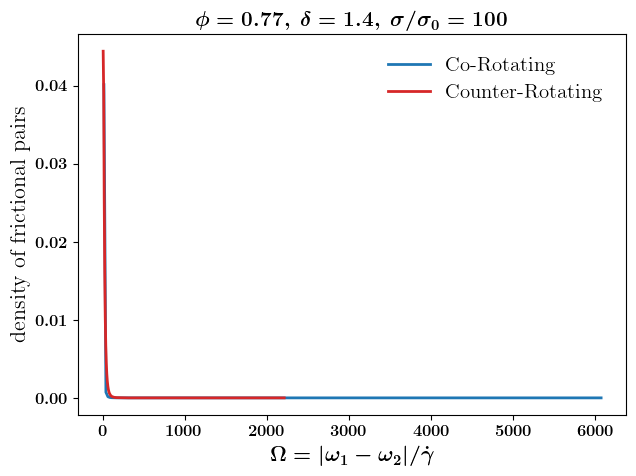

In [98]:
## Plot
labels   = ['Co-rotating pairs', 'Counter-rotating pairs']
colors   = ['tab:blue', 'tab:red']
markers  = ['o', 's']
linestyl = ['-', '--']

for ii, phi in enumerate(phis):
    count, bins = np.histogram(all_corot[phi], bins=250, density=True)#, range=(0, 100))
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    plt.plot(bin_centers, count, label='Co-Rotating', color=colors[0], lw=2)
    
    count, bins = np.histogram(all_courot[phi], bins=350, density=True)#, range=(0, 100))
    bin_centers = 0.5*(bins[:-1] + bins[1:])
    plt.plot(bin_centers, count, label='Counter-Rotating', color=colors[1], lw=2)


plt.legend(fontsize=15, frameon=False, fancybox=False, framealpha=0.9, edgecolor='black',
           labelspacing=0.4, borderpad=0.6, handlelength=2.0)

plt.xlabel(r'$\Omega = |\omega_1 - \omega_2|/\dot \gamma$', fontsize=15)
plt.ylabel('density of frictional pairs', fontsize=16)

#plt.xlim([0, 20])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.yscale('log')
#plt.xscale('log')

plt.title(fr'$\phi = {phi},\ \delta = {ar},\ \sigma/\sigma_0 = 100$', fontsize=15)
plt.tight_layout()
#plt.savefig(f'{fig_save_path}/frictional_pairs_phi_{phi}_ar_{ar}_vr_{vr}.pdf', transparent=True, dpi=500)
plt.show()

## Betti 0 plots

In [48]:
## Betti 0 plot with varying threshold for a case
## filtering the counter rotating and co-rotating differently

npp     = 1000
phi     = 0.75
ar      = '1.4'
vr      = '0.5'
numRuns = 2
off     = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

maxdiff = 0

if os.path.exists(dataname):
    bettiMat_pos = []
    bettiMat_neg = []
    
    with tqdm(total=(len(frames) * len(thresholds) * numRuns), desc="betti calc") as pbar:
    #with tqdm(desc="betti calc") as pbar:
        for l in range(numRuns):
            run = l + 1
            par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
            dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]
            int_file = glob.glob(f'{dataname}/run_{run}/{intFile}')[0]
            rig_file = glob.glob(f'{dataname}/run_{run}/{rigFile}')[0]
            datdata  = np.genfromtxt(dat_file)
            srate    = datdata[:, 2]

            if par_file and rig_file:
                parList    = readFiles.readParFile(open(par_file))
                intList    = readFiles.interactionsList(open(int_file))
                parLines   = open(par_file).readlines()
                thresholds = np.linspace(0, 21, 60)
                #frames     = range(off, 102)
                frames     = range(off, len(srate))

                for frame in frames:
                    chainno_pos  = []
                    chainno_neg  = []
                    
                    frameArr = []
                    intFrame = intList[frame]
                    parFrame = parList[frame]
                    numInts  = intFrame.shape[0]
                    sr       = srate[frame]

                    for i in range(numInts):
                        n1    = int(intFrame[i,  0])
                        n2    = int(intFrame[i,  1])
                        w1    = parFrame[n1, 8]/sr
                        w2    = parFrame[n2, 8]/sr
                        wdiff = np.abs(w1 - w2) * np.sign(w1 * w2)

                        frameArr.append([n1, n2, wdiff])

                    frameArr = np.array(frameArr)
                    n1       = frameArr[:, 0].astype(int)
                    n2       = frameArr[:, 1].astype(int)
                    wdiff    = frameArr[:, 2]
                    #maxdiff  = max(wdiff) if max(wdiff) > maxdiff else maxdiff
                    omega_pos = np.abs(wdiff[wdiff >= 0])
                    omega_neg = np.abs(wdiff[wdiff < 0])
                    
                    for threshold in thresholds: 
                        ## Co-rotating
                        filtered_edges1 = [(i, j) for i, j, w in zip(n1, n2, omega_pos) if w >= threshold]
                        G1 = nx.Graph() # to identify networks
                        G1.add_edges_from(filtered_edges1)

                        chains  = list(nx.connected_components(G1))
                        betti01 = len(chains)
                        #chain_sizes = [len(chain) for chain in chains]
                        chainno_pos.append(betti01)
                        #pbar.update(1)
                        
                        ## Counter rotating
                        filtered_edges2 = [(i, j) for i, j, w in zip(n1, n2, omega_neg) if w >= threshold]
                        G2 = nx.Graph() # to identify networks
                        G2.add_edges_from(filtered_edges2)

                        chains  = list(nx.connected_components(G2))
                        betti02 = len(chains)
                        #chain_sizes = [len(chain) for chain in chains]
                        chainno_neg.append(betti02)
                        pbar.update(1)
                        
                    bettiMat_pos.append(chainno_pos)
                    bettiMat_neg.append(chainno_neg)

betti calc:  60%|█████████████▏        | 228120/380200 [04:42<03:08, 808.40it/s]


In [34]:
bettiMat.shape

(3802, 60)

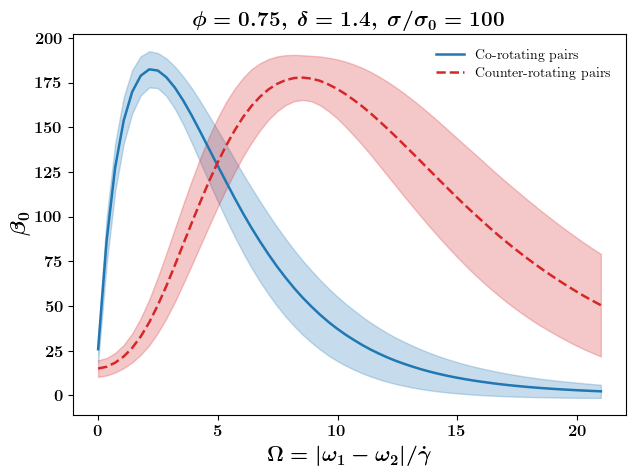

In [49]:
## Plot
labels   = ['Co-rotating pairs', 'Counter-rotating pairs']
colors   = ['tab:blue', 'tab:red']
markers  = ['o', 's']
linestyl = ['-', '--']

for ii, bettiMat in enumerate([bettiMat_pos, bettiMat_neg]):
    bettiMat = np.array(bettiMat)

    col_mean = np.mean(bettiMat, axis=0)
    col_std  = np.std(bettiMat,  axis=0)

    plt.plot(thresholds, col_mean, linestyle=linestyl[ii], marker=markers[ii],
             color=colors[ii], linewidth=1.8, markersize=0, label=labels[ii])
    
    plt.fill_between(thresholds, col_mean - col_std, col_mean + col_std, color=colors[ii], alpha=0.25)


plt.legend(fontsize=10, frameon=False, fancybox=False, framealpha=0.9, edgecolor='black',
           labelspacing=0.4, borderpad=0.6, handlelength=2.0)

plt.xlabel(r'$\Omega = |\omega_1 - \omega_2|/\dot \gamma$', fontsize=15)
plt.ylabel(r'$\beta_0$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.yscale('log')
# plt.xscale('log')

plt.title(rf'$\phi = {phir},\ \delta = {ar},\ \sigma/\sigma_0 = 100$', fontsize=15)
plt.tight_layout()
plt.savefig(f'{fig_save_path}/Betti0_phi_{phir}_ar_{ar}_vr_{vr}_.pdf', transparent=True, dpi=500)
plt.show()

In [37]:
fig_save_path

PosixPath('/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel')

In [17]:
thresholds.shape

(50,)

In [24]:
col_sum.shape

(50,)

In [29]:
## Angular velocity viscualization

npp = 1000
phi = 0.75
ar  = '1.4'
vr  = '0.5'
run = 1
off = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

# Frame details
frames = [off, 200] #start and end frame

if os.path.exists(dataname):
    par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
    dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]

    if par_file and rig_file:
        dataArr  = np.loadtxt(dat_file)
        parList  = readFiles.readParFile(open(par_file))
        parLines = open(par_file).readlines()
        srate    = dataArr[:, 2]
        
        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        # setting up axis and box walls
        newLx = Lx + 2*float(ar)
        newLz = Lz + 2*float(ar)

        for frame in tqdm(range(frames[0], frames[1]), desc='frames'):
            #frame = 102
            fig, ax = plt.subplots(1, 1, figsize=(3,3))

            # plotting all particles
            pr = parList[frame][:, 1]
            px = parList[frame][:, 2]
            py = parList[frame][:, 3]
            w  = parList[frame][:, 8]/srate[frame] #nomalized

            face_color = np.where(w < 0, 'blue', 'r')
            pr_scaled  = (np.abs(w)/np.max(np.abs(w)))*pr

            for ii in range(npp):
                circle = plt.Circle((px[ii],py[ii]), pr_scaled[ii], facecolor=face_color[ii], 
                                    fill=True, edgecolor='none', alpha=0.8)            
                ax.add_artist(circle)

            ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
            ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
            ax.set_title(fr'$\phi = {phir},\; \delta = {ar},\; \sigma/\sigma_0 = 100, \; \dot\gamma = {frame/100:.2f}$', 
                         pad=5, fontweight='bold', fontsize=8)
            ax.axis('off')
            ax.set_aspect('equal')

            directory = f'{fig_save_path}/phi_{phir}_ar_{ar}_vr_{vr}_angvel_vis'
            os.makedirs(directory, exist_ok=True)
            fig.savefig(f'{directory}/{frame}.png', transparent=True, dpi=500)
            plt.close()
            #plt.show()

frames: 100%|█████████████████████████████████| 100/100 [00:51<00:00,  1.95it/s]


In [25]:
np.max(pr_scaled)

np.float64(1.0398992743420339)

In [26]:
srate[frame]

np.float64(0.0478671)

## Angular velocity coupled with rigidity

In [30]:
## Angular velocity weighted as per rigidity
# Some simulation parameters

npp  = 1000
runs = 1
phi  = 0.77
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 6   # number of minimum values
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigFlat   = readFiles.rigListFlat(rigFile)
    totStrain = datdata[-1, 1]
    srate     = datdata[off:, 2]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    #rigFlat = [[x for frame in sublist for x in frame] for sublist in rigdata]
    
    #for i, frame in enumerate(pardata[off:]):
    frame = 715
    angvel = pardata[frame][:, 8]
    pidx   = pardata[frame][:, 0]
#   px     = frame[:, 2]
#   pz     = frame[:, 3]
    sr     = srate[frame]
    angvel /= sr
    rigList = rigFlat[frame]
    
    rigweights = np.zeros(npp)
    rigweights[rigList] = 1
    
    zhi_rig = np.sum(np.absolute(angvel) * np.array(rigweights))/np.sum(rigweights)
    zhi     = np.sum(np.absolute(angvel) * (1 - np.array(rigweights)))/np.sum((1 - np.array(rigweights)))

In [31]:
print(zhi_rig)
print(zhi)

6.35584119105058
6.38639413436277


In [9]:
len(rigdata)

2001

In [15]:
fulllist = []
for sublist in rigdata:
    framelist = []
    for ii in range(len(sublist)):
        framelist.extend(sublist[ii])
        
    fulllist.append(framelist)

In [17]:
fulllist = [[x for frame in sublist for x in frame] for sublist in rigdata]

In [18]:
len(fulllist)

2001

## Sum of angular velocity for non rigid

In [79]:
## Angular velocity weighted as per rigidity
# Some simulation parameters

npp  = 1000
runs = 2
phis = ['0.75', '0.76', '0.77']
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 6   # number of minimum values
#phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []

all_wrig  = {k: None for k in phis}
all_wnrig = {k: None for k in phis}

for phi in tqdm(phis, desc='phis'):
    w_rig_sum  = []
    w_nrig_sum = []

    for l in range(runs):
        dataname  = f"{topDir}/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{l+1}"  
        dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
        parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
        #rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
        rigFile   = open(glob.glob(f'{dataname}/rigPrime.txt' )[0], 'r')
        datdata   = np.genfromtxt(dataFile)
        pardata   = readFiles.readParFile(parFile)
        rigFlat   = readFiles.rigListFlat(rigFile)
        totStrain = datdata[-1, 1]
        srate     = datdata[:, 2]
        parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

        lx = float(parLines[3].split()[2]) 
        lz = float(parLines[5].split()[2])

        for frame in range(off, len(srate)):
            #frame   = 715
            angvel  = pardata[frame][:, 8]
            pidx    = pardata[frame][:, 0]
            sr      = srate[frame]
            angvel /= sr
            rigList = list(set(rigFlat[frame]))

            rigweights = np.zeros(npp)
            rigweights[rigList] = 1

            totrig = len(rigList)
            totnonrig = npp - totrig

            w_rig  = np.sum(np.abs(angvel[rigList]))
            w_nrig = np.sum(np.abs(angvel)) - w_rig

            w_rig_sum.append(w_rig/totrig)
            w_nrig_sum.append(w_nrig/totnonrig)
    
    all_wrig[phi]  = w_rig_sum
    all_wnrig[phi] = w_nrig_sum

phis: 100%|███████████████████████████████████████| 3/3 [00:22<00:00,  7.62s/it]


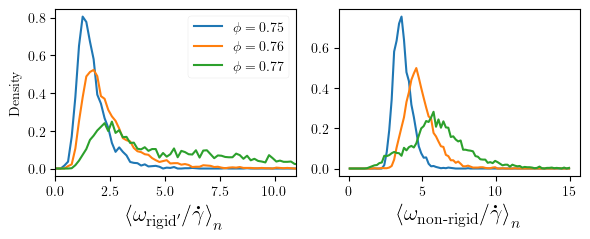

In [80]:
fig, ax = plt.subplots(1,2, figsize=(6,2.5))
for phi_val in all_wnrig.keys():
    counts, bins = np.histogram(all_wrig[phi_val], bins=90, density=True, range=[0, 15])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax[0].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')
    #ax[0].set_title('')
    counts, bins = np.histogram(all_wnrig[phi_val], bins=90, density=True, range=[0, 15])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax[1].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')

for axs in ax:
    ax[0].set_ylabel('Density')
    ax[0].set_xlim([0, 11])
    
ax[0].legend(fontsize=10)
ax[0].set_xlabel(r'$\mathbf{\langle \omega_{\text{rigid}^{\prime}}/\dot\gamma \rangle}_n$', fontsize=16)
#ax[0].set_xlabel(r'$\mathbf{\langle \omega_{\text{rigid}}/\dot\gamma \rangle}_n$', fontsize=16)
ax[1].set_xlabel(r'$\mathbf{\langle \omega_{\text{non-rigid}}/\dot\gamma \rangle}_n$', fontsize=16)

plt.savefig(f"{fig_save_path}/angVel_sum_prime.pdf", bbox_inches='tight', dpi=500)
plt.show()

## Dissipation calc

In [66]:
## Angular velocity weighted as per rigidity
# Some simulation parameters

npp  = 1000
runs = 2
phis = ['0.72', '0.75', '0.76', '0.77']
#phis = ['0.75']
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100

D_corot_rig   = {k: None for k in phis}
D_courot_rig  = {k: None for k in phis}
D_corot_nrig  = {k: None for k in phis}
D_courot_nrig = {k: None for k in phis}

D_corot_bound  = {k: None for k in phis}
D_courot_bound = {k: None for k in phis}

for phi in tqdm(phis, desc='phis'):
    D_all  = [[] for n in range(6)]
    for l in range(runs):
        dataname  = f"{topDir}/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{l+1}"
        if os.path.exists(dataname):
            dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
            parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
            rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
            rigpFile  = open(glob.glob(f'{dataname}/rigPrime.txt' )[0], 'r')
            intFile   = open(glob.glob(f'{dataname}/int_*.dat' )[0], 'r')

            intdata   = readFiles.interactionsList(intFile)
            datdata   = np.genfromtxt(dataFile)
            pardata   = readFiles.readParFile(parFile)
            rigFlat   = readFiles.rigListFlat(rigFile)
            rigpFlat  = readFiles.rigListFlat(rigpFile)
            totStrain = datdata[-1, 1]
            srate     = datdata[: , 2]
            parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

            lx = float(parLines[3].split()[2]) 
            lz = float(parLines[5].split()[2])

            for frame in range(off, len(srate)):
                #frame     = 715
                p1        = intdata[frame][:, 0].astype(int)
                p2        = intdata[frame][:, 1].astype(int)
                normxij   = intdata[frame][:, 2]
                normzij   = intdata[frame][:, 4]
                lubNorm   = intdata[frame][:, 6]
                lubTangx  = intdata[frame][:, 7]
                lubTangz  = intdata[frame][:, 9]
                contState = intdata[frame][:,10]
                contNorm  = intdata[frame][:,11]
                contTangx = intdata[frame][:,12]
                contTangz = intdata[frame][:,14]
                repulNorm = intdata[frame][:,16]
                totInts   = len(p1)
                
                normInts = lubNorm + contNorm + repulNorm
                tangInts = np.linalg.norm(np.array([lubTangx + contTangx, lubTangz + contTangz]), axis=0)
                #mu_eff   = np.divide(tangInts, normInts, out=np.zeros_like(tangInts, dtype=float), 
                                     #where=normInts != 0)
                mu_eff   = np.where(contState==2, 1, 0)
                angvel   = pardata[frame][:, 8]
                pidx     = pardata[frame][:, 0]
                sr       = srate[frame]
                angvel  /= sr
                rigList  = list(set(rigFlat[frame]))
                
                corotbool    = (angvel[p1] * angvel[p2]) > 0 # co-rotation is True
                #dissipation = [(np.abs(angvel[p1[ii]]) - np.abs(angvel[p2[ii]]))*mu_eff[ii] for ii in range(totInts)]
                dissipation  = np.abs(angvel[p1] - angvel[p2])*mu_eff
            
                ## Both interacting particles are rigid
                rigIntLines   = np.zeros(totInts, dtype=bool)
                mask_rig      = [(p1[ii] in rigList) and (p2[ii] in rigList) for ii in range(totInts)]
                rigIntLines[mask_rig] = True
                D_all[0].append(np.mean(dissipation[ corotbool &  rigIntLines]) if np.any( corotbool &  rigIntLines) else 0)
                D_all[1].append(np.mean(dissipation[~corotbool &  rigIntLines]) if np.any(~corotbool &  rigIntLines) else 0)
                
                ## Both interacting particles are non-rigid
                nonrigIntLines = np.zeros(totInts, dtype=bool)
                mask_nonrig    = [(p1[ii] not in rigList) and (p2[ii] not in rigList) for ii in range(totInts)]
                nonrigIntLines[mask_nonrig] = True
                D_all[2].append(np.mean(dissipation[ corotbool & nonrigIntLines]) if np.any( corotbool & nonrigIntLines) else 0)
                D_all[3].append(np.mean(dissipation[~corotbool & nonrigIntLines]) if np.any(~corotbool & nonrigIntLines) else 0)
                
                ## Both interacting particles are at boundary
                boundintLines = np.zeros(totInts, dtype=bool)
                mask_boundary = [(p1[ii] in rigList) ^ (p2[ii] in rigList) for ii in range(totInts)] ##Logical XOR ^
                boundintLines[mask_boundary] = True
                D_all[4].append(np.mean(dissipation[ corotbool & boundintLines]) if np.any( corotbool &  boundintLines) else 0)
                D_all[5].append(np.mean(dissipation[~corotbool & boundintLines]) if np.any(~corotbool &  boundintLines) else 0)
    
    D_corot_rig[phi]   = D_all[0]
    D_courot_rig[phi]  = D_all[1]
    
    D_corot_nrig[phi]  = D_all[2]
    D_courot_nrig[phi] = D_all[3]
    
    D_corot_bound[phi]  = D_all[4]
    D_courot_bound[phi] = D_all[5]

phis: 100%|██████████████████████████████████████| 4/4 [14:08<00:00, 212.10s/it]


In [74]:
len(D_all)

4

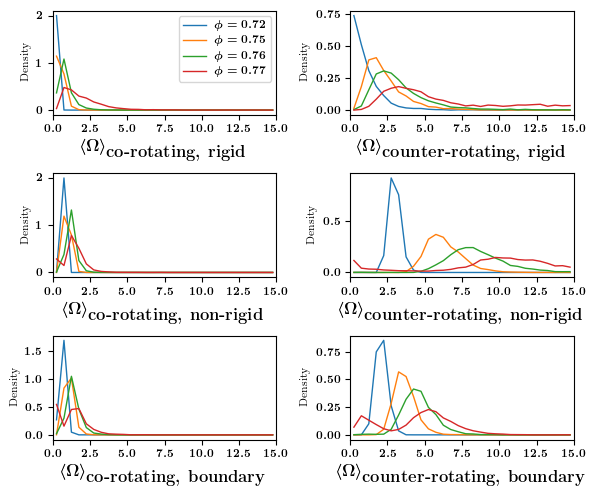

In [94]:
fig, ax = plt.subplots(3,2, figsize=(6, 5))
phis = ['0.72', '0.75', '0.76', '0.77']
binss  = 30
for phi_val in phis:
    counts, bins = np.histogram(D_corot_rig[phi_val], bins=binss, density=True, range=[0, 15])
    bin_centers  = 0.5 * (bins[:-1] + bins[1:])
    ax[0,0].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')
    ax[0,0].set_xlabel(r'$\langle \Omega \rangle_{\textbf{co-rotating, rigid}}$', fontsize=12)
    
    counts, bins = np.histogram(D_courot_rig[phi_val], bins=binss, density=True, range=[0, 15])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax[0,1].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')
    ax[0,1].set_xlabel(r'$\langle \Omega \rangle_{\textbf{counter-rotating, rigid}}$', fontsize=12)
    
    counts, bins = np.histogram(D_corot_nrig[phi_val], bins=binss, density=True, range=[0, 15])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax[1,0].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')
    ax[1,0].set_xlabel(r'$\langle \Omega \rangle_{\textbf{co-rotating, non-rigid}}$', fontsize=12)
    
    counts, bins = np.histogram(D_courot_nrig[phi_val], bins=binss, density=True, range=[0, 15])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax[1,1].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')
    ax[1,1].set_xlabel(r'$\langle \Omega \rangle_{\textbf{counter-rotating, non-rigid}}$', fontsize=12)
    
    ##
    counts, bins = np.histogram(D_corot_bound[phi_val], bins=binss, density=True, range=[0, 15])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax[2,0].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')
    ax[2,0].set_xlabel(r'$\langle \Omega \rangle_{\textbf{co-rotating, boundary}}$', fontsize=12)
    
    counts, bins = np.histogram(D_courot_bound[phi_val], bins=binss, density=True, range=[0, 15])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    ax[2,1].plot(bin_centers, counts, label=fr'$\phi = {phi_val}$')
    ax[2,1].set_xlabel(r'$\langle \Omega \rangle_{\textbf{counter-rotating, boundary}}$', fontsize=12)
    
for axs in ax.flat:
    axs.set_ylabel('Density')
    axs.set_xlim([0, 15])
    
ax[0,0].legend(fontsize=8)

plt.savefig(f"{fig_save_path}/dissipation_noMu.pdf", bbox_inches='tight', dpi=500)
plt.show()

In [ ]:
## Mrig vs dissipation in non rig 

In [68]:
## Angular velocity weighted as per rigidity
# Some simulation parameters

npp  = 1000
runs = 2
phis = ['0.75', '0.76', '0.77']
#phis = ['0.75']
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100

D_nrig = {k: None for k in phis}
mrig   = {k: None for k in phis}

for phi in tqdm(phis, desc='phis'):
    D_all  = []
    m_all  = []
    for l in range(runs):
        dataname  = f"{topDir}/NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{l+1}"
        if os.path.exists(dataname):
            dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
            parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
            rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
            rigpFile  = open(glob.glob(f'{dataname}/rigPrime.txt')[0], 'r')
            frigFile  = open(glob.glob(f'{dataname}/F_rig.txt')[0], 'r')
            frigpFile = open(glob.glob(f'{dataname}/F_prime_rig.txt')[0], 'r')
            intFile   = open(glob.glob(f'{dataname}/int_*.dat' )[0], 'r')

            intdata   = readFiles.interactionsList(intFile)
            datdata   = np.genfromtxt(dataFile)
            pardata   = readFiles.readParFile(parFile)
            rigFlat   = readFiles.rigListFlat(rigFile)
            rigpFlat  = readFiles.rigListFlat(rigpFile)
            totStrain = datdata[-1, 1]
            srate     = datdata[: , 2]
            frig      = np.genfromtxt(frigFile)/npp
            frigp     = np.genfromtxt(frigpFile)/npp
            parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

            lx = float(parLines[3].split()[2]) 
            lz = float(parLines[5].split()[2])

            for frame in range(off, len(srate)):
                #frame     = 715
                p1        = intdata[frame][:, 0].astype(int)
                p2        = intdata[frame][:, 1].astype(int)
                normxij   = intdata[frame][:, 2]
                normzij   = intdata[frame][:, 4]
                lubNorm   = intdata[frame][:, 6]
                lubTangx  = intdata[frame][:, 7]
                contState = intdata[frame][:,10]
                lubTangz  = intdata[frame][:, 9]
                contNorm  = intdata[frame][:,11]
                contTangx = intdata[frame][:,12]
                contTangz = intdata[frame][:,14]
                repulNorm = intdata[frame][:,16]
                totInts   = len(p1)
                
                normInts = lubNorm + contNorm + repulNorm
                tangInts = np.linalg.norm(np.array([lubTangx + contTangx, lubTangz + contTangz]), axis=0)
                #mu_eff   = np.divide(tangInts, normInts, out=np.zeros_like(tangInts, dtype=float), 
                                     #where=normInts != 0)
                mu_eff   = np.where(contState==2, 1, 0)
                angvel   = pardata[frame][:, 8]
                pidx     = pardata[frame][:, 0]
                sr       = srate[frame]
                angvel  /= sr
                rigList  = list(set(rigFlat[frame]))
                
                corotbool    = (angvel[p1] * angvel[p2]) > 0 # co-rotation is True
                dissipation  = np.abs(angvel[p1] - angvel[p2])*np.abs(mu_eff)
            
                nonrigIntLines = np.zeros(totInts, dtype=bool)
                nonrig_mask    = [(p1[ii] not in rigList) and (p2[ii] not in rigList) for ii in range(totInts)]
                nonrigIntLines[nonrig_mask] = True
                
                D_all.append(np.mean(dissipation[nonrigIntLines]) if np.any(nonrigIntLines) else 0)
    
        m_all.extend(frigp[off+1:,1])
        
    D_nrig[phi] = D_all
    mrig[phi]   = m_all

phis: 100%|██████████████████████████████████████| 3/3 [05:13<00:00, 104.48s/it]


In [27]:
len(dissipation)

2403

In [28]:
len(dissipation[nonrigIntLines])

2079

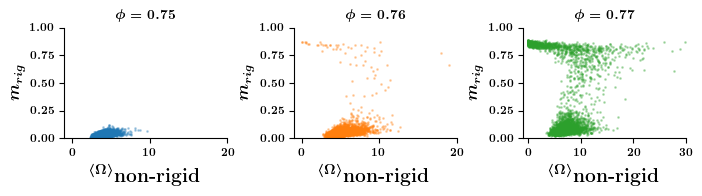

In [88]:
fig, ax = plt.subplots(1, 3, figsize=(7, 2))

colors = plt.cm.tab10.colors

for ii, phi_val in enumerate(phis):
    ax[ii].scatter(D_nrig[phi_val], mrig[phi_val],
               s=1, color=colors[ii % len(colors)], alpha=0.3,
               label=fr'$\phi = {phi_val}$')

    ax[ii].set_xlabel(r'$_{\langle \Omega \rangle_{\textbf{non-rigid}}}$', fontsize=14)
    ax[ii].set_ylabel(r'$m_{rig}$', fontsize=12)
    ax[ii].set_title(fr'$\phi={phi_val}$')
    
    ax[ii].set_xlim(-1, 20)
    ax[ii].set_ylim(0, 1)

    #ax[ii].spines['left'].set_position('zero')
    #ax[ii].spines['bottom'].set_position('zero')
    ax[ii].spines['right'].set_color('none')
    ax[ii].spines['top'].set_color('none')

    ax[ii].xaxis.set_ticks_position('bottom')
    ax[ii].yaxis.set_ticks_position('left')

ax[2].set_xlim(-1, 30)
#ax[0].legend(fontsize=10)
plt.tight_layout()
plt.savefig(f"{fig_save_path}/mrig_dissipation.pdf", bbox_inches='tight', dpi=500)
plt.show()

/var/folders/7z/4v7gv78n0rq_k11539h6b9zc0000gn/T/ipykernel_18616/260608047.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.savefig(f"{fig_save_path}/mrig_dissipation_{phi_val}.pdf", bbox_inches='tight', dpi=500)
/Users/rahul/suspensions/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


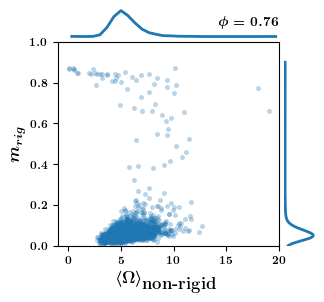

In [92]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
import pandas as pd
from scipy.stats import gaussian_kde

# Example data
phi_val = '0.76'
df = pd.DataFrame({'D_nrig': D_nrig[phi_val],'mrig': mrig[phi_val]})
colors = sns.color_palette("tab10", 1)

# --- Main figure ---
fig, ax = plt.subplots(figsize=(3, 3))

# ---- Scatter plot ----
sns.scatterplot(
    data=df,
    x='D_nrig',
    y='mrig',
    ax=ax,
    s=10,
    color=colors[0],
    alpha=0.3,
    edgecolor=None
)

ax.set_xlabel(r'$\langle \Omega \rangle_{\textbf{non-rigid}}$', fontsize=12)
ax.set_ylabel(r'$m_{rig}$', fontsize=12)
ax.set_title(fr'$\phi={phi_val}$', pad=12, loc='right')
ax.set_xlim(-1, 20)
ax.set_ylim(0, 1)

# ---- Top marginal histogram (above top spine) ----
ax_top = inset_axes(
    ax,
    width="100%",          # full width of main plot
    height="70%",          # small height
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    bbox_transform=ax.transAxes,
    loc='lower left',
    borderpad=0
)

# Use matplotlib hist instead of sns.histplot
counts, bins = np.histogram(df['D_nrig'], bins=30, range=(0, 20), density=True)
centers = 0.5 * (bins[:-1] + bins[1:])

ax_top.plot(centers, counts, color=colors[0], lw=2)
ax_top.set_xlim(ax.get_xlim())
ax_top.axis('off')

# ---- Right marginal histogram (outside right spine) ----
ax_right = inset_axes(
    ax,
    width="70%",          # narrow width
    height="100%",        # full height
    bbox_to_anchor=(1.02, 0, 0.2, 1),
    bbox_transform=ax.transAxes,
    loc='lower left',
    borderpad=0
)

x = df['mrig'].dropna()
kde = gaussian_kde(x)

ys = np.linspace(0, 0.9, 400)
ax_right.plot(kde(ys), ys, color=colors[0], lw=2)
ax_right.set_ylim(ax.get_ylim())
ax_right.axis('off')

#plt.tight_layout()
plt.savefig(f"{fig_save_path}/mrig_dissipation_{phi_val}.pdf", bbox_inches='tight', dpi=500)
plt.show()

## Graph vertex correlation

As per Prof. Jonathan and Kinjal from NJIT - there is a correlation between the no. of vertices and rigid particles subgraphs going upto a graph distance of 3 particles. 
I tried to do a histogram for it below

In [2]:
## Generating BFS (breadth first structure) to capture graph
# Adjencency list
from collections import deque
import networkx as nx

# Identifying edge dupicates
def edgeset(edge_list):
    seen       = set()
    duplicates = []

    for a, b in edge_list:
        norm = tuple(sorted((a, b)))  # normalize
        if norm in seen:
            duplicates.append(norm)
        else:
            seen.add(norm)
            
    return seen, duplicates

## Identifying nodes and edges in the neighbourhood upto a graph distance kk
def neighbors(G, source, kk):
    nodes   = [source]
    visited = {source}
    queue   = deque([(source, 0)]) # doubly linked list. (node, distance) format
    edges   = set()  # store edges as tuples (u,v)

    while queue:
        # Command below justifes why we need BFS linked list (FIFO - first in first out).
        # it process the nodes append first. Untill all run out
        node, dist = queue.popleft()  # this permenantly pops out left most (first entered) element out
        if dist < k:
            for neighbor in G.neighbors(node):
                if neighbor not in visited:
                    edges.add((node, neighbor))
                    visited.add(neighbor)
                    nodes.append(neighbor)
                    queue.append((neighbor, dist+1))
    
    return nodes, edges


####################################################
#parameters
npp  = 1000
runs = 1
phi  = 0.72
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
run  = 1
k    = 3  # graph distance
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []

dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{run}"  
dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
intFile   = open(glob.glob(f'{dataname}/int_*.dat' )[0], 'r')

datdata   = np.genfromtxt(dataFile)
pardata   = readFiles.readParFile(parFile)
rigdata   = readFiles.rigList(rigFile)
intdata   = readFiles.interactionsList(intFile)

totStrain = datdata[-1, 1]
srate     = datdata[off:, 2]
parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()
rigList   = [set([item for sublist in group for item in sublist]) for group in rigdata] # flattend list

lx = float(parLines[3].split()[2]) 
lz = float(parLines[3].split()[2])

In [3]:
# Getting vertex and nodes sum for rigid and non-rigid particles for the histogram

G = []

rigid_edges    = []
nonrigid_edges = []
rigid_nodes    = []
nonrigid_nodes = []

for idx, frame in enumerate(intdata[off:off+1]):
    G     = nx.Graph()
    filtered_frame = frame[frame[:, 10] != 0, :2].astype(int) # interacting particle indices for contact type != 0
    adjecency_list = list(map(tuple, filtered_frame)) #adjecency list or edges in entire snapshot
    G.add_edges_from(adjecency_list)
    
    for n in range(npp):
        if n in G:
            nodes, edges = neighbors(G, source=n, kk=k)
        else:
            # Node not in graph, so skip
            continue
        
        #edge_set, duplicate_set = edgeset(list(edges))
        
        if n in rigList[off+idx]:
            rigid_edges.append(len(edges))
            rigid_nodes.append(len(set(nodes)))
        else:
            nonrigid_edges.append(len(edges))
            nonrigid_nodes.append(len(set(nodes)))

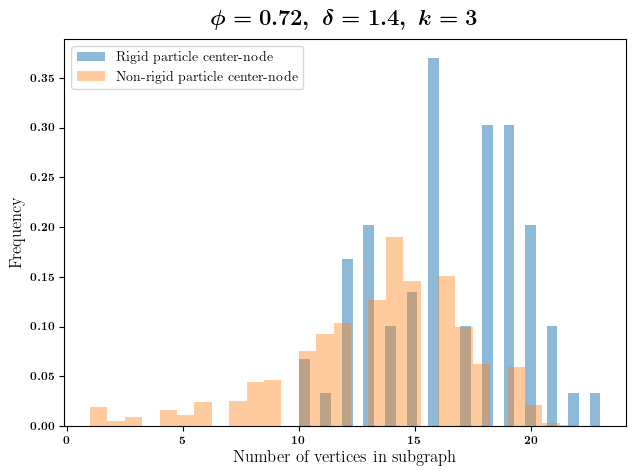

In [4]:
plt.hist(rigid_edges, bins=28, alpha=0.5, label='Rigid particle center-node', density=True)
plt.hist(nonrigid_edges, bins=28, alpha=0.4, label='Non-rigid particle center-node', density=True)

plt.xlabel('Number of vertices in subgraph' ,fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(fontsize =10)
plt.title(f'$\phi= {phi}, \; \delta = {ar}, \; k = {k}$', fontsize = 16, pad =10)
#plt.savefig(f"{fig_save_path}/hist_vertices_phi_{phi}_ar_{ar}.png", bbox_inches="tight", dpi=800, transparent=False)
plt.show()

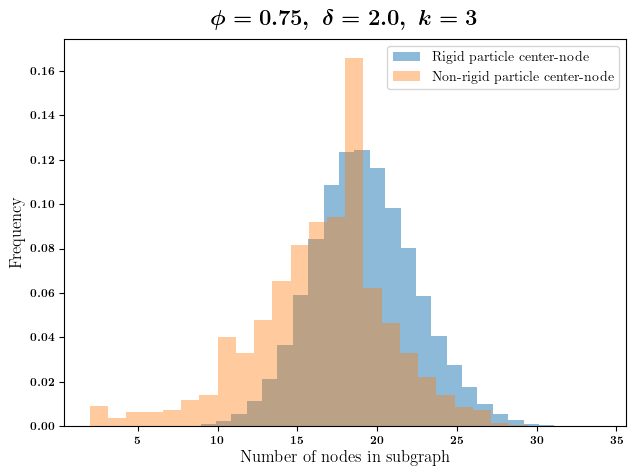

In [14]:
plt.hist(rigid_nodes, bins=28, alpha=0.5, label='Rigid particle center-node', density=True)
plt.hist(nonrigid_nodes, bins=28, alpha=0.4, label='Non-rigid particle center-node', density=True)

plt.xlabel('Number of nodes in subgraph' ,fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.legend(fontsize =10)
plt.title(f'$\phi= {phi}, \; \delta = {ar},\; k = {k}$', fontsize = 16, pad =10)
#plt.savefig(f"{fig_save_path}/hist_nodes_phi_{phi}_ar_{ar}.png", bbox_inches="tight", dpi=800, transparent=False)
plt.show()

In [29]:
## sample adjecency graph

idx     = 100 # sample frame
g_nodes = []
g_edges = []

G     = nx.Graph()
frame = intdata[idx]
filtered_frame = frame[frame[:, 10] != 0, :2].astype(int)
adjecency_list = list(map(tuple, filtered_frame)) #adjecency list or edges in entire snapshot
G.add_edges_from(adjecency_list)

for n in range(npp):
    if n in G:
        nodes, edges = neighbors(G, source=n, k=3)
        #edge_set, duplicate_set = edgeset(list(edges))
        g_nodes.append(nodes)
        g_edges.append(edges)
        
len(g_nodes) # this is the total subgraphs in one frame. Use a number till this range in 'subg_idx' below

867

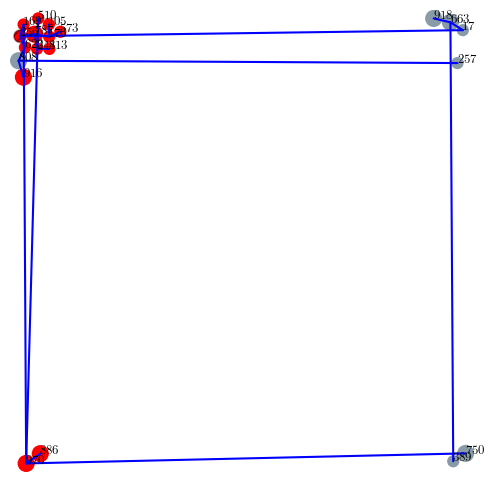

In [31]:
## Plotting adjecency graph
# currently this code cannot resolve boundary subgraphs
fig, ax = plt.subplots(1, 1, figsize=(5,5))

px  = pardata[idx][:,2]
pz  = pardata[idx][:,3]
pr  = pardata[idx][:,1] 

xlim = [np.inf, -np.inf]
zlim = [np.inf, -np.inf]

subg_idx = 200 # 100, 800, 816 # sample subgraph in a frame
graph    = list(g_nodes[subg_idx])
edges    = list(g_edges[subg_idx])

for i in graph:
    if i in rigList[idx]:
        circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='r', fill=True, edgecolor='none') #083d5f
    else:
        circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#8A9BA8', fill=True, edgecolor='none')
    
    ax.add_artist(circle)
    xlim[0] = min(xlim[0], px[i])
    xlim[1] = max(xlim[1], px[i])
    zlim[0] = min(zlim[0], pz[i])
    zlim[1] = max(zlim[1], pz[i])
    
    ax.text(px[i]+0.02, pz[i]+0.02, f'{i}', fontsize=9, color='k', zorder =13)
    
idx0   = graph[0]  
if idx0 in rigList[idx]:
    circle = plt.Circle((px[idx0], pz[idx0]), pr[idx0], facecolor='r', fill=True,
                        edgecolor='k', hatch='////',  linewidth=1.2, alpha = 0.4, zorder=10)
else:
    circle = plt.Circle((px[idx0], pz[idx0]), pr[idx0], facecolor='#8A9BA8', fill=True,
                        edgecolor='k', hatch='//////',  linewidth=1.2, alpha = 0.4, zorder=10)
    
ax.add_patch(circle)

for bond in edges:
    ii, jj = bond
    ax.plot([px[ii], px[jj]],[pz[ii], pz[jj]], color='b', linewidth=1.5, 
            solid_capstyle='round', solid_joinstyle='round', zorder=11)

ax.set_xlim([xlim[0]-ar, xlim[1]+ar])
ax.set_ylim([zlim[0]-ar, zlim[1]+ar])
#ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
ax.axis('off')
ax.set_aspect('equal')

#plt.savefig(f"{fig_save_path}/subgraph_t_{idx}_sg_{subg_idx}.png", bbox_inches="tight", dpi=800, transparent=False)

plt.show()

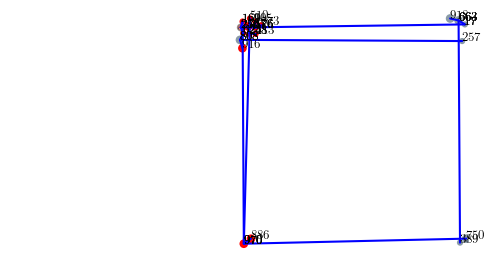

In [34]:
## Plotting adjecency graph
## In progress. Here I want to develop a code to resolove the boundary case issue

fig, ax = plt.subplots(1, 1, figsize=(5,5))

px  = pardata[idx][:,2]
pz  = pardata[idx][:,3]
pr  = pardata[idx][:,1] 

xlim = [np.inf, -np.inf]
zlim = [np.inf, -np.inf]

subg_idx = 200 # sample subgraph in a frame
graph    = list(g_nodes[subg_idx])
edges    = list(g_edges[subg_idx])


for i, j in edges:
    x1 = px[i]
    z1 = pz[i]
    x2 = px[j]
    z2 = pz[j]
    
    p1 = np.array([x1, z1])
    p2 = np.array([x2, z2])

    dist =  np.linalg.norm(p1 - p2)
    
    if dist > lx/2:
        p2[0] -= lx
        p2[1] -= srate[idx]*lz


    
    if i in rigList[idx]:
        circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='r', fill=True, edgecolor='none') #083d5f
    else:
        circle = plt.Circle((px[i],pz[i]), pr[i], facecolor='#8A9BA8', fill=True, edgecolor='none')

    if j in rigList[idx]:
        circle = plt.Circle((px[j],pz[j]), pr[j], facecolor='r', fill=True, edgecolor='none') #083d5f
    else:
        circle = plt.Circle((px[j],pz[j]), pr[j], facecolor='#8A9BA8', fill=True, edgecolor='none')

    ax.add_artist(circle)

    xlim[0] = min(xlim[0], p1[0], p2[0])
    xlim[1] = max(xlim[1], p1[0], p2[0])
    zlim[0] = min(zlim[0], p1[1], p2[1])
    zlim[1] = max(zlim[1], p1[1], p2[1])

    ax.text(px[i]+0.02, pz[i]+0.02, f'{i}', fontsize=9, color='k', zorder =13)
    ax.text(px[j]+0.02, pz[j]+0.02, f'{j}', fontsize=9, color='k', zorder =13)
    
idx0   = graph[0]  
if idx0 in rigList[idx]:
    circle = plt.Circle((px[idx0], pz[idx0]), pr[idx0], facecolor='r', fill=True,
                        edgecolor='k', hatch='////',  linewidth=1.2, alpha = 0.4, zorder=10)
else:
    circle = plt.Circle((px[idx0], pz[idx0]), pr[idx0], facecolor='#8A9BA8', fill=True,
                        edgecolor='k', hatch='//////',  linewidth=1.2, alpha = 0.4, zorder=10)
    
ax.add_patch(circle)

for bond in edges:
    ii, jj = bond
    ax.plot([px[ii], px[jj]],[pz[ii], pz[jj]], color='b', linewidth=1.5, 
            solid_capstyle='round', solid_joinstyle='round', zorder=11)

ax.set_xlim([xlim[0]-ar, xlim[1]+ar])
ax.set_ylim([zlim[0]-ar, zlim[1]+ar])
#ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
ax.axis('off')
ax.set_aspect('equal')

#plt.savefig(f"{fig_save_path}/subgraph_t_{idx}_sg_{subg_idx}.png", bbox_inches="tight", dpi=800, transparent=False)

plt.show()

## Angular velocity vs neighboring particels correlations

In [27]:
## Angular velocity vs neighbouring k particle angular velocity
# Some simulation parameters

npp  = 1000
runs = 1
phi  = 0.77
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 6   # number of minimum values
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    totStrain = datdata[-1, 1]
    srate     = datdata[off:, 2]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for i, frame in enumerate(pardata[off:]):
        angvel = frame[:,8]
        pidx   = frame[:, 0]
        px     = frame[:, 2]
        pz     = frame[:, 3]
        sr     = srate[i]
        
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        
        for ii in pidx:
            idx         = np.argsort(dij[:, int(ii)])[1:k+1]
            neighAngVel = np.mean(angvel[idx])
            neighAngVel_all.append(neighAngVel)

        rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
        color   = np.array(['white'] * npp)
        color[list(rigList[off+i])] = 'r'

        angvel_all.extend(angvel)
        colors_all.extend(list(color))
        
angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)

0.77


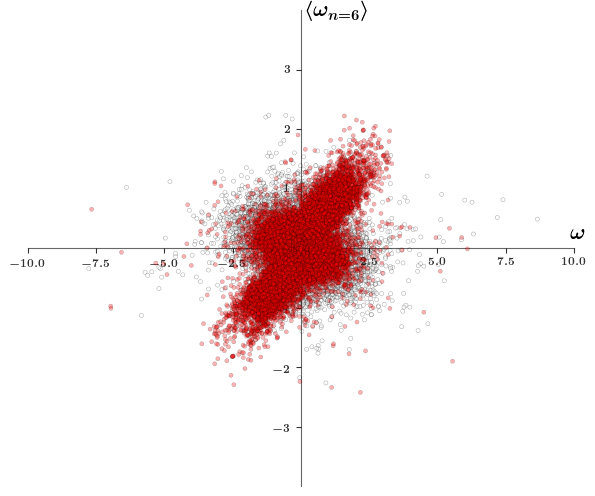

In [28]:
# w vs w_n=k (NOT normalised wrt shear rate)

plt.figure(figsize = (6, 5))

angvel_all      = np.array(angvel_all)
neighAngVel_all = np.array(neighAngVel_all)
colors_all      = np.array(colors_all)

is_red  = colors_all == 'r' # index of red points
not_red = ~is_red             # index of non-red points

plt.scatter(angvel_all[not_red], neighAngVel_all[not_red],      # non-red points below
            s=35, c=colors_all[not_red], alpha=0.4, marker='.',
            linewidths=0.3, edgecolors='k', zorder=1, rasterized=True)

plt.scatter(angvel_all[is_red], neighAngVel_all[is_red],        # red points above
            s=35, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10, rasterized=True)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])
ax.set_ylim(-4, 4)   #angvel_neigh
ax.set_xlim(-10, 10) #angvel

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)
ax.set_xlabel(r'$\omega$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n={k}}} \rangle$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(1.02, 0.55)
ax.yaxis.set_label_coords(0.57, 1.02)
plt.savefig(f"{fig_save_path}/angvel_{k}-neighbor_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800, transparent=False)
plt.tight_layout
print(f'{phi}')
plt.show()

In [12]:
## Angular velocity vs neighbouring k particle angular velocity
# normalized wrt shear rate

npp  = 1000
runs = 1
phi  = 0.74
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7  # number of minimum values
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    srate     = datdata[off:, 2]
    totStrain = datdata[-1, 1]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for i, frame in enumerate(pardata[off:]):
        angvel = frame[:,8]
        pidx   = frame[:, 0]
        px     = frame[:, 2]
        pz     = frame[:, 3]
        sr     = srate[i]
        
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        
        for ii in pidx:
            idx         = np.argsort(dij[:, int(ii)])[1:k+1]
            neighAngVel = np.mean(angvel[idx])
            neighAngVel_all.append(neighAngVel/sr)

        rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
        color   = np.array(['white'] * npp)
        color[list(rigList[off+i])] = 'r'

        angvel_all.extend(angvel/sr)
        colors_all.extend(list(color))

angvel_all = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)

0.77


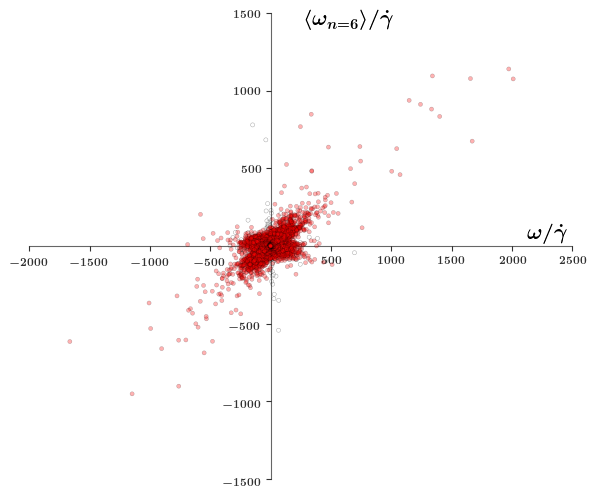

In [10]:
## plot w vs w_n=6 wrt to gamma
plt.figure(figsize = (6, 5))

angvel_all      = np.array(angvel_all)
neighAngVel_all = np.array(neighAngVel_all)
colors_all      = np.array(colors_all)

is_red  = colors_all == 'r' # index of red points
not_red = ~is_red             # index of non-red points

plt.scatter(angvel_all[not_red], neighAngVel_all[not_red],      # non-red points below
            s=35, c=colors_all[not_red], alpha=0.4, marker='.',
            linewidths=0.3, edgecolors='k', zorder=1)

plt.scatter(angvel_all[is_red], neighAngVel_all[is_red],        # red points above
            s=35, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])
#ax.set_ylim(-30, 30)   #angvel_neigh
#ax.set_xlim(-75, 75) #angvel

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)
ax.set_xlabel(r'$\omega/ \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n={k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.99, 0.55)
ax.yaxis.set_label_coords(0.59, 1.01)
plt.savefig(f"{fig_save_path}/angvel_{k}-neighbor_sr_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800, transparent=False)
plt.grid(False)
print(f'{phi}')
plt.show()

0.74


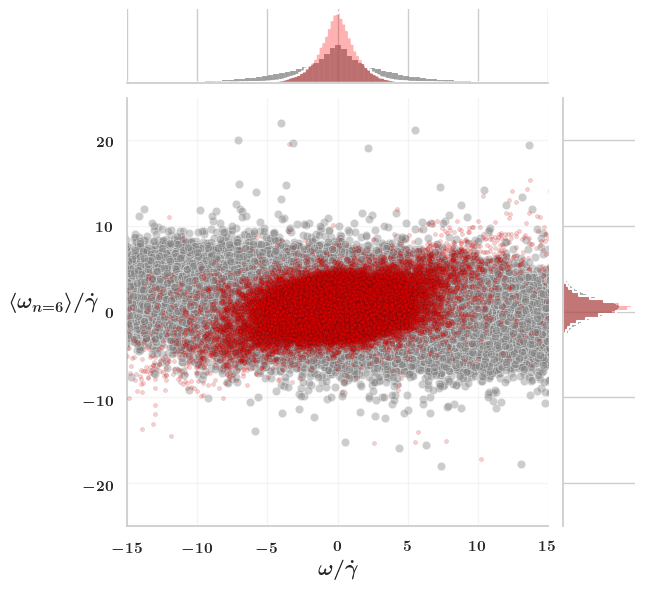

In [13]:
##  sns joint plot with histogram
#plot w vs w_n=6 wrt to gamma

angvel_all      = np.array(angvel_all)
neighAngVel_all = np.array(neighAngVel_all)
colors_all      = np.array(colors_all)

# Create DataFrame
df = pd.DataFrame({
    'angvel': angvel_all,
    'neigh_angvel': neighAngVel_all,
    'color': colors_all
})

# Separate red and not red
df_red = df[df['color'] == 'r']
df_white = df[df['color'] != 'r']

# Set theme
sns.set(style="whitegrid")

# Create base jointplot for white points
jp = sns.jointplot(data=df_white, x='angvel', y='neigh_angvel',
                   kind='scatter', color='gray', alpha=0.4,
                   marginal_kws={'bins': 500, 'fill': True, 'stat': 'density'}, height=6)

# Overlay red points manually
jp.ax_joint.scatter(df_red['angvel'], df_red['neigh_angvel'],
                    color='red', alpha=0.2, s=35, marker='.', linewidths=0.3,
                    edgecolors='k', zorder=10)

# Top marginal histogram (x-axis) for red points
sns.histplot(df_red['angvel'], ax=jp.ax_marg_x, color='red', bins=500,
             stat='density', alpha=0.3, element='step', linewidth=1.5, edgecolor=None)

# Right marginal histogram (y-axis) for red points
sns.histplot(y=df_red['neigh_angvel'], ax=jp.ax_marg_y, color='red', bins=100,
             stat='density', alpha=0.3, element='step', linewidth=1.5, edgecolor=None)

# Set axis limits (optional)
jp.ax_joint.set_xlim(-15, 15)
jp.ax_joint.set_ylim(-25, 25)

# Axis labels
jp.ax_joint.set_xlabel(r'$\omega/ \dot \gamma$', fontsize=15)
jp.ax_joint.set_ylabel(fr'$\langle \omega_{{n={k}}} \rangle / \dot \gamma$', fontsize=15, rotation=0, labelpad=20)

# Grid styling
jp.ax_joint.grid(which='both', alpha=0.2)

# Save and show
jp.figure.savefig(f"{fig_save_path}/angvel_{k}-neighbor_sr_hist_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", dpi=800, bbox_inches='tight')
print(f'{phi}')
plt.show()

In [4]:
2*np.degrees(np.arcsin(1/2.4))

49.248636704328156

In [5]:
2*np.degrees(np.arcsin(1/2))

60.00000000000001

In [4]:
## Angular velocity vs RELEVANT neighbouring <=k particle angular velocity
# normalized wrt shear rate

npp  = 1000
runs = 1
phi  = 0.77
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7  # max number of neighbors
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []
idxlen = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    srate     = datdata[off:, 2]
    totStrain = datdata[-1, 1]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for i, frame in enumerate(pardata[off:]):
        angvel = frame[:, 8]
        pidx   = frame[:, 0]
        pr     = frame[:, 1]
        px     = frame[:, 2]
        pz     = frame[:, 3]
        sr     = srate[i]
        
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        
        for ii in pidx:
            sorted_indices = np.argsort(dij[:, int(ii)]) # all neighbors sorted by distance to particle ii
            within_cutoff  = dij[sorted_indices, int(ii)] <= 1.5 * (1+ar) # distance cuttoff
            idx = sorted_indices[within_cutoff][1:k+1]  # skip self # this list wont crash
            idxlen.append(len(idx))
            
            neighAngVel = np.mean(angvel[idx])     # mean ang vel of nearest neighbors
            neighAngVel_all.append(neighAngVel/sr) 

        rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
        color   = np.array(['white'] * npp)
        color[list(rigList[off+i])] = 'r'

        angvel_all.extend(angvel/sr)
        colors_all.extend(list(color))

angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)
colors_all      = np.array(colors_all)

0.77


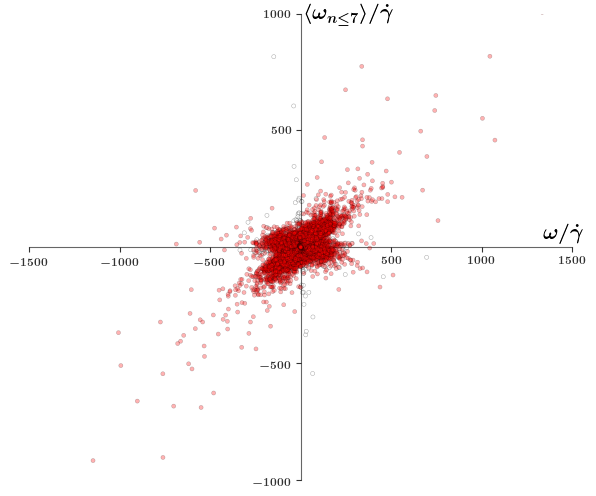

In [8]:
## plot for w vs w_<k

plt.figure(figsize = (6, 5))

is_red  = colors_all == 'r' # index of red points
not_red = ~is_red             # index of non-red points

plt.scatter(angvel_all[not_red], neighAngVel_all[not_red],      # non-red points below
            s=35, c=colors_all[not_red], alpha=0.4, marker='.',
            linewidths=0.3, edgecolors='k', zorder=1)

plt.scatter(angvel_all[is_red], neighAngVel_all[is_red],        # red points above
            s=35, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])
ax.set_ylim(-1000, 1000) #angvel_neigh
ax.set_xlim(-1500, 1500) #angvel

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)
ax.set_xlabel(r'$\omega / \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(1.02, 0.55)
ax.yaxis.set_label_coords(0.59, 1.02)
plt.savefig(f"{fig_save_path}/angvel_<{k}-neighbor_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800, transparent=False)
print(f'{phi}')
plt.show()

0.77


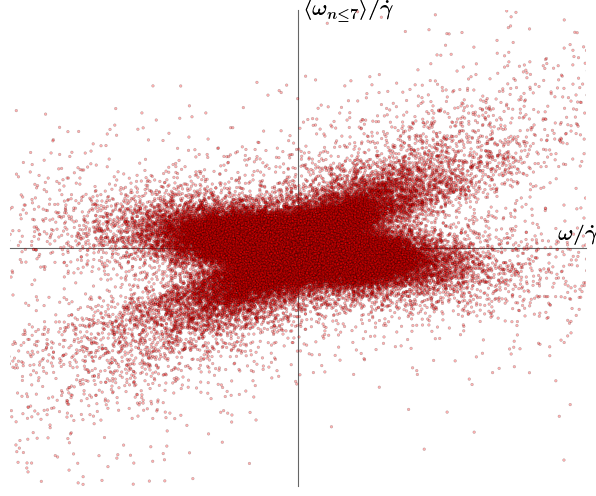

In [6]:
## plot for w vs w_<k

plt.figure(figsize = (6, 5))

is_red  = colors_all == 'r' # index of red points
not_red = ~is_red             # index of non-red points

plt.scatter(angvel_all[is_red], neighAngVel_all[is_red],        # red points above
            s=15, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])
ax.set_ylim(-150, 150) #angvel_neigh
ax.set_xlim(-150, 150) #angvel

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)
ax.set_xlabel(r'$\omega / \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(1.02, 0.55)
ax.yaxis.set_label_coords(0.59, 1.02)
#plt.savefig(f"{fig_save_path}/angvel_<{k}-neighbor_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800, transparent=False)
print(f'{phi}')
plt.show()

In [35]:
## based on quality of neighbors

## Angular velocity vs RELEVANT neighbouring <=k particle angular velocity
# normalized wrt shear rate

npp  = 1000
runs = 1
phi  = 0.77
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7  # max number of neighbors
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []
qual_neigh_all  = [] #quality of neighbors
idxlen = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    srate     = datdata[off:, 2]
    totStrain = datdata[-1, 1]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for i, frame in enumerate(pardata[off:]):
        angvel = frame[:,8]
        pidx   = frame[:, 0]
        pr     = frame[:, 1]
        px     = frame[:, 2]
        pz     = frame[:, 3]
        sr     = srate[i]
        
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
        
        for ii in pidx:
            sorted_indices = np.argsort(dij[:, int(ii)]) # all neighbors sorted by distance to particle ii
            within_cutoff  = dij[sorted_indices, int(ii)] <= 1.5 * (1+ar) # distance cuttoff
            idx = sorted_indices[within_cutoff][1:k+1]  # skip self # this list wont crash
            idxlen.append(len(idx))
            
            # quality of neighbors (1 being all rigid neighbors)
            tot_neigh  = len(idx)
            qual_neigh = 0
            for ij in idx:
                if ij in rigList[i]:
                    qual_neigh += 1
                    
            qual_neigh /= tot_neigh
            
            
            neighAngVel = np.mean(angvel[idx])     # mean ang vel of nearest neighbors
            neighAngVel_all.append(neighAngVel/sr)
            qual_neigh_all.append(qual_neigh)

        color   = np.array(['white'] * npp)
        color[list(rigList[off+i])] = 'r'

        angvel_all.extend(angvel/sr)
        colors_all.extend(list(color))

angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)
colors_all      = np.array(colors_all)
qual_neigh_all  = np.array(qual_neigh_all)

0.77


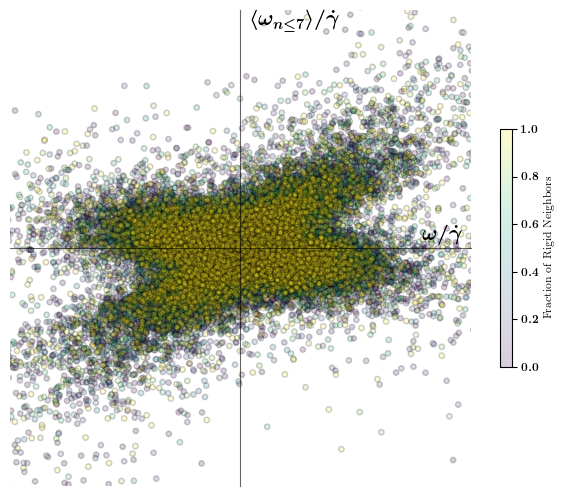

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Identify red and non-red points
is_red  = colors_all == 'r'
not_red = ~is_red

# Extract arrays for red particles
angvel_red     = angvel_all[is_red]
neighangv_red  = neighAngVel_all[is_red]
qual_neigh_red = qual_neigh_all[is_red]

# Sort red points by qual_neigh_red to draw low values first, high last
sorted_idx = np.argsort(qual_neigh_red)
angvel_red_sorted     = angvel_red[sorted_idx]
neighangv_red_sorted  = neighangv_red[sorted_idx]
qual_neigh_red_sorted = qual_neigh_red[sorted_idx]

# Plot
plt.figure(figsize=(6, 5))
sc = plt.scatter(angvel_red_sorted, neighangv_red_sorted,c=qual_neigh_red_sorted, 
                 cmap='viridis', edgecolors='k', s=15, alpha=0.2)

# Axes styling
ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])

ax.set_xlim(-150, 150)
ax.set_ylim(-150, 150)

# ax.set_xlim(-8, 8)
# ax.set_ylim(-8, 8)

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)

# Axis labels
ax.set_xlabel(r'$\omega / \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.98, 0.55)
ax.yaxis.set_label_coords(0.62, 1.00)

# Colorbar
# cbar = plt.colorbar(sc, ax=ax, label="Fraction of Rigid Neighbors")
# cbar.ax.tick_params(labelsize=10)
cbar = plt.colorbar(sc, ax=plt.gca(), label="Fraction of Rigid Neighbors",shrink = 0.5)

plt.savefig(f"{fig_save_path}/angvel_<{k}-neighbor_quality_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800)
print(f'{phi}')
plt.show()

0.74


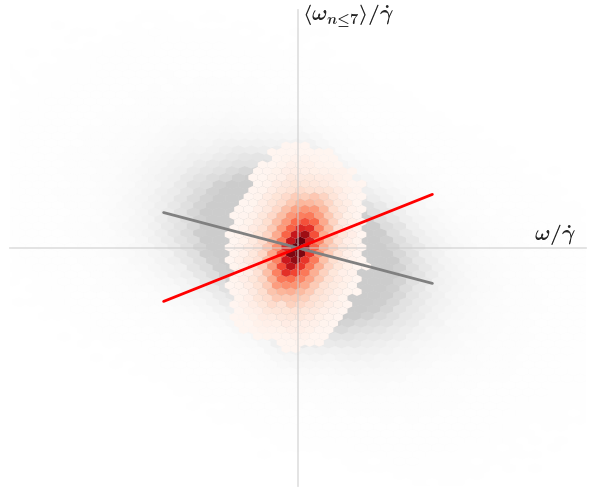

In [57]:
## hexbin plots # plot for linear fit for w vs w_<k

angvel_all      = np.array(angvel_all)
neighAngVel_all = np.array(neighAngVel_all)
colors_all      = np.array(colors_all)

# Masks for red and non-red
is_red  = colors_all == 'r'
not_red = ~is_red

plt.figure(figsize=(6, 5))

# Plot hexbin for non-red points
plt.hexbin(
    angvel_all[not_red], neighAngVel_all[not_red],
    gridsize=300, cmap='Greys', #extent=[-30, 30, -10, 10],
    linewidths=0, mincnt=1e1, alpha=0.2, zorder=0, vmin = 0, vmax = 2e3
)

#Plot hexbin for red points
plt.hexbin(
    angvel_all[is_red], neighAngVel_all[is_red],
    gridsize=200, cmap='Reds', #extent=[-30, 30, -10, 10],
    linewidths=0, mincnt=8e1, alpha=1, zorder=1, vmin = 1e2, vmax = 3e3
)

# --- Linear fitting ---
coeffs_white = np.polyfit(angvel_all[not_red], neighAngVel_all[not_red], deg=1)
m1, c1 = coeffs_white
coeffs_red = np.polyfit(angvel_all[is_red], neighAngVel_all[is_red], deg=1)
m2, c2 = coeffs_red

# Plot fitted lines
x = np.linspace(-7, 7, 100)
yw_fit = m1 * x + c1
yr_fit = m2 * x + c2

plt.plot(x, yw_fit, color='gray', zorder=10, linewidth=2)
plt.plot(x, yr_fit, color='red',  zorder=20, linewidth=2)

# --- Axes and styling ---
ax = plt.gca()

# Move bottom/left spines to zero
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)

# Hide top/right spines
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.tick1line.set_zorder(30)
    tick.label1.set_alpha(0.8)
    tick.label1.set_zorder(30)

# Also for tick labels via get_xticklabels/get_yticklabels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_zorder(30)
    label.set_alpha(0.8)

# Axis labels
ax.set_xlabel(r'$\omega / \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.98, 0.55)
ax.yaxis.set_label_coords(0.59, 1.01)

ax.set_xlim(-15, 15)
ax.set_ylim(-6, 6)

# Optional: Colorbar for density (can be commented out)
# cb = plt.colorbar(label='Counts')
# cb.set_alpha(0.8)
# cb.draw_all()

# Save or show
#plt.savefig(f"{fig_save_path}/angvel_<{k}-neighbor_rigid_hex_liner_fit_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800)
print(f'{phi}')
plt.tight_layout()
plt.grid(False)
plt.show()

0.77


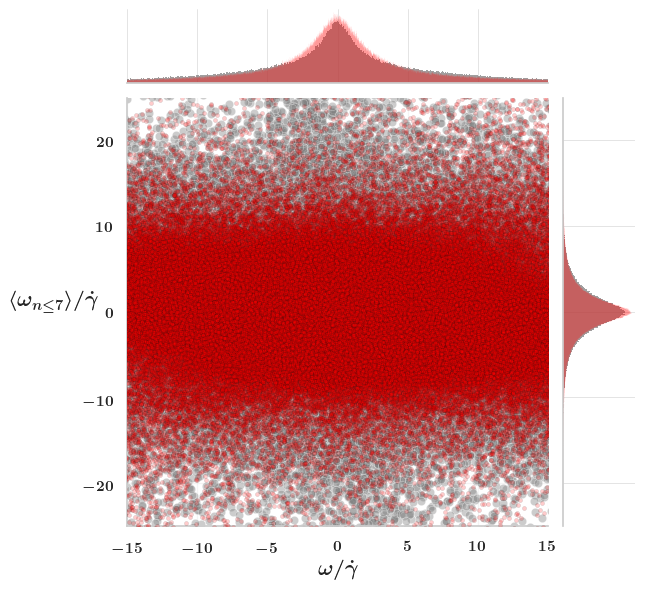

In [10]:
##  sns joint plot with histogram
#plot w vs w_n<=7 wrt to gamma

angvel_all      = np.array(angvel_all)
neighAngVel_all = np.array(neighAngVel_all)
colors_all      = np.array(colors_all)

# Create DataFrame
df = pd.DataFrame({
    'angvel': angvel_all,
    'neigh_angvel': neighAngVel_all,
    'color': colors_all
})

# Separate red and not red
df_red   = df[df['color'] == 'r']
df_white = df[df['color'] != 'r']

# Set theme
sns.set(style="whitegrid")

# Create base jointplot for white points
jp = sns.jointplot(data=df_white, x='angvel', y='neigh_angvel',
                   kind='scatter', color='gray', alpha=0.4,
                   marginal_kws={'bins': 50000, 'fill': True, 'stat': 'density'}, height=6)

# Overlay red points manually
jp.ax_joint.scatter(df_red['angvel'], df_red['neigh_angvel'],
                    color='red', alpha=0.2, s=35, marker='.', linewidths=0.3,
                    edgecolors='k', zorder=10)

# Top marginal histogram (x-axis) for red points
sns.histplot(df_red['angvel'], ax=jp.ax_marg_x, color='red', bins=500000,
             stat='density', alpha=0.4, element='step', linewidth=0, edgecolor=None)

# Right marginal histogram (y-axis) for red points
sns.histplot(y=df_red['neigh_angvel'], ax=jp.ax_marg_y, color='red', bins=100000,
             stat='density', alpha=0.4, element='step', linewidth=0, edgecolor=None)

# X histogram: disable horizontal (y-axis) gridlines
jp.ax_marg_x.grid(False, axis='y')  # Only keep vertical gridlines if any
jp.ax_marg_x.grid(True, axis='x', color='gray', alpha=0.3, linewidth=0.5)

# Y histogram: disable vertical (x-axis) gridlines
jp.ax_marg_y.grid(False, axis='x')  # Only keep horizontal gridlines if any
jp.ax_marg_y.grid(True, axis='y', color='gray', alpha=0.3, linewidth=0.5)

# Set axis limits (optional)
jp.ax_joint.set_xlim(-15, 15)
jp.ax_joint.set_ylim(-25, 25)

# Axis labels
jp.ax_joint.set_xlabel(r'$\omega/ \dot \gamma$', fontsize=15)
jp.ax_joint.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', fontsize=15, rotation=0, labelpad=20)

# Grid styling
jp.ax_joint.grid(which='both', alpha=0.2)

# Save and show
jp.figure.savefig(f"{fig_save_path}/angvel_<{k}-neighbor_sr_hist_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", dpi=800, bbox_inches='tight')
print(f'{phi}')
plt.show()

In [34]:
## plot with lims

# Define your x and y limits
x_min, x_max = -25, 25
y_min, y_max = -25, 25  # Optional: only if you want to restrict by y as well

# Mask for non-red (white) data in desired range
mask_white = (not_red & 
              (angvel_all >= x_min) & (angvel_all <= x_max) & 
              (neighAngVel_all >= y_min) & (neighAngVel_all <= y_max))

# Mask for red data in desired range
mask_red = (is_red & 
            (angvel_all >= x_min) & (angvel_all <= x_max) & 
            (neighAngVel_all >= y_min) & (neighAngVel_all <= y_max))

# Now do the fitting
coeffs_white = np.polyfit(angvel_all[mask_white], neighAngVel_all[mask_white], deg=1)
m1, c1 = coeffs_white

coeffs_red = np.polyfit(angvel_all[mask_red], neighAngVel_all[mask_red], deg=1)
m2, c2 = coeffs_red

(1901000,)

## Angular velocity dumbell

In [10]:
## diff Angular velocity dumbell vs mean neighbouring k particle angular velocity
# Some simulation parameters

npp  = 1000
runs = 1
phi  = 0.72
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7   # number of minimum values
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []

for l in range(runs):
    # Paths
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    intFile   = open(glob.glob(f'{dataname}/int_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')

    # Read data
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    intdata   = readFiles.interactionsList(intFile)
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()
    totStrain = datdata[-1, 1]
    srate     = datdata[off:, 2]
    rigList   = [set(sum(rigFrame, [])) for rigFrame in rigdata] # flatten rig data

    # Box dimensions
    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for t, intFrame in enumerate(intdata[off:]):
        sr = srate[t] # frame shear rate
        
        # All particle data
        parData = pardata[t]
        pidx    = parData[:, 0]
        px      = parData[:, 2]
        pz      = parData[:, 3]
        angvel  = parData[:, 8]

        # Interacting particle data
        p1         = intFrame[:, 0]
        p2         = intFrame[:, 1]
        contState  = intFrame[:, 10]

        # Frictional interactions
        frictCont  = np.array(contState == 2, dtype = bool)
        p1_frict   = p1[frictCont]
        p2_frict   = p2[frictCont]
        pidx_frict = list(zip(p1_frict, p2_frict))
        
        # distance matrix
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij   = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        color = np.array(['white'] * len(pidx_frict))

        for i, pair in enumerate(pidx_frict):
            p1, p2 = map(int, pair)
        
            # Neighbors of p1
            dists = dij[:, p1]
            idx1  = np.argsort(dists)
            mask  = dists[idx1] <= 1.5 * (1 + ar)
            n1    = idx1[mask][1:k+1]  # skip self
        
            # Neighbors of p2
            dists = dij[:, p2]
            idx2  = np.argsort(dists)
            mask  = dists[idx2] <= 1.5 * (1 + ar)
            n2    = idx2[mask][1:k+1]  # skip self
        
            # Filter out self and pair members
            n_all = np.concatenate((n1, n2))
            neigh = [x for x in n_all if x not in pair]
        
            w_diff  = angvel[p1] - angvel[p2]
            w_neigh = np.mean(angvel[neigh])
        
            angvel_all.append(w_diff / sr)
            neighAngVel_all.append(w_neigh / sr)
        
            if p1 in rigList[t] and p2 in rigList[t]:
                color[i] = 'red'

        colors_all.extend(list(color))
        
angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)
colors_all      = np.array(colors_all)

KeyboardInterrupt: 

In [55]:
print("angvel_all shape:", angvel_all.shape)
print("neighAngVel_all shape:", neighAngVel_all.shape)
print("colors_all shape:", colors_all.shape)

angvel_all shape: (2475345,)
neighAngVel_all shape: (2475345,)
colors_all shape: (2475345,)


0.77


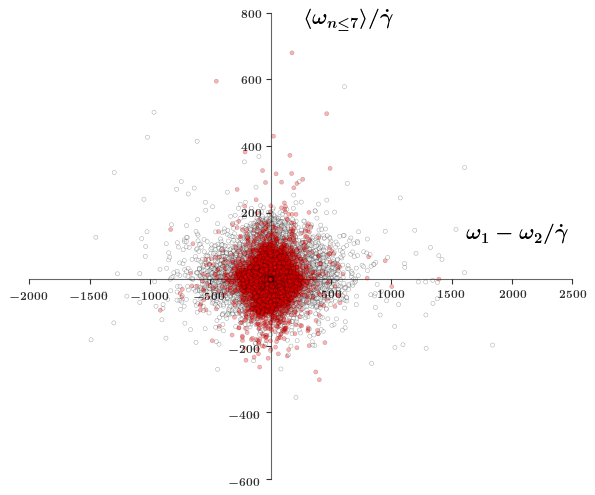

In [40]:
## plot w vs w_n=6 wrt to gamma
plt.figure(figsize = (6, 5))

is_red  = colors_all == 'red' # index of red points
not_red = ~is_red             # index of non-red points

plt.scatter(angvel_all[not_red], neighAngVel_all[not_red],      # non-red points below
            s=35, c=colors_all[not_red], alpha=0.4, marker='.',
            linewidths=0.3, edgecolors='k', zorder=1)

plt.scatter(angvel_all[is_red], neighAngVel_all[is_red],        # red points above
            s=35, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
    
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])
#ax.set_ylim(-30, 30) #angvel_neigh
#ax.set_xlim(-75, 75) #angvel

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)
ax.set_xlabel(r'$\omega_1 - \omega_2/ \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.99, 0.55)
ax.yaxis.set_label_coords(0.59, 1.01)
plt.savefig(f"{fig_save_path}/angvel_{k}-neighbor_sr_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800, transparent=False)
plt.grid(False)
print(f'{phi}')
plt.show()

0.77


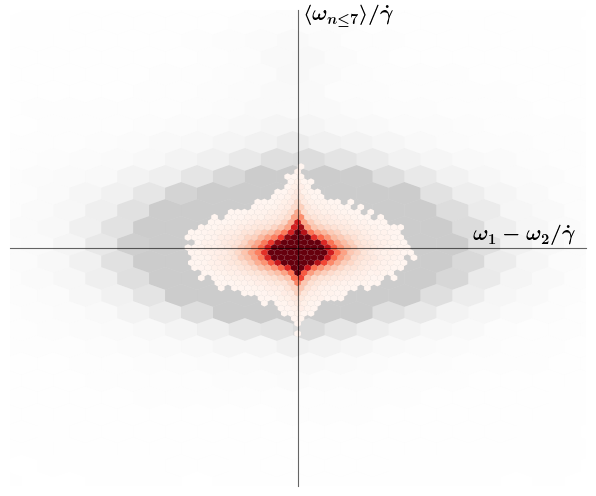

In [54]:
## hexbin plots # plot for linear fit for w vs w_<k

# Masks for red and non-red
is_red  = colors_all == 'red'
not_red = ~is_red

plt.figure(figsize=(6, 5))

# Plot hexbin for non-red points
plt.hexbin(
    angvel_all[not_red], neighAngVel_all[not_red],
    gridsize=300, cmap='Greys', #extent=[-30, 30, -10, 10],
    linewidths=0, mincnt=1e1, alpha=0.2, zorder=0, vmin = 0, vmax = 2e3
)

#Plot hexbin for red points
plt.hexbin(
    angvel_all[is_red], neighAngVel_all[is_red],
    gridsize=1000, cmap='Reds', #extent=[-30, 30, -10, 10],
    linewidths=0, mincnt=8e1, alpha=1, zorder=1, vmin = 1e2, vmax = 3e3
)

# --- Axes and styling ---
ax = plt.gca()

# Move bottom/left spines to zero
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)

# Hide top/right spines
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')

ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.tick1line.set_zorder(30)
    tick.label1.set_alpha(0.8)
    tick.label1.set_zorder(30)

# Also for tick labels via get_xticklabels/get_yticklabels
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_zorder(30)
    label.set_alpha(0.8)

# Axis labels
ax.set_xlabel(r'$\omega_1 - \omega_2 / \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.98, 0.55)
ax.yaxis.set_label_coords(0.59, 1.01)

ax.set_xlim(-100, 100)
ax.set_ylim(-40, 40)

# Optional: Colorbar for density (can be commented out)
# cb = plt.colorbar(label='Counts')
# cb.set_alpha(0.8)
# cb.draw_all()

# Save or show
#plt.savefig(f"{fig_save_path}/angvel_<{k}-neighbor_rigid_hex_liner_fit_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800)
print(f'{phi}')
plt.tight_layout()
plt.grid(False)
plt.show()

In [23]:
## mean Angular velocity dumbell vs mean neighbouring k particle angular velocity
# Some simulation parameters

npp  = 1000
runs = 1
phi  = 0.74
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7   # number of minimum values
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []

for l in range(runs):
    # Paths
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    intFile   = open(glob.glob(f'{dataname}/int_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')

    # Read data
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    intdata   = readFiles.interactionsList(intFile)
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()
    totStrain = datdata[-1, 1]
    srate     = datdata[off:, 2]
    rigList   = [set(sum(rigFrame, [])) for rigFrame in rigdata] # flatten rig data

    # Box dimensions
    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for t, intFrame in enumerate(intdata[off:]):
        sr = srate[t] # frame shear rate
        
        # All particle data
        parData = pardata[t]
        pidx    = parData[:, 0]
        px      = parData[:, 2]
        pz      = parData[:, 3]
        angvel  = parData[:, 8]

        # Interacting particle data
        p1         = intFrame[:, 0]
        p2         = intFrame[:, 1]
        contState  = intFrame[:, 10]

        # Frictional interactions
        frictCont  = np.array(contState == 2, dtype = bool)
        p1_frict   = p1[frictCont]
        p2_frict   = p2[frictCont]
        pidx_frict = list(zip(p1_frict, p2_frict))
        
        # distance matrix
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij   = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        color = np.array(['white'] * len(pidx_frict))

        for i, pair in enumerate(pidx_frict):
            p1, p2 = map(int, pair)
        
            # Neighbors of p1
            dists = dij[:, p1]
            idx1  = np.argsort(dists)
            mask  = dists[idx1] <= 1.5 * (1 + ar)
            n1    = idx1[mask][1:k+1]  # skip self
        
            # Neighbors of p2
            dists = dij[:, p2]
            idx2  = np.argsort(dists)
            mask  = dists[idx2] <= 1.5 * (1 + ar)
            n2    = idx2[mask][1:k+1]  # skip self
        
            # Filter out self and pair members
            n_all = np.concatenate((n1, n2))
            neigh = [x for x in n_all if x not in pair]
        
            #w_diff  = angvel[p1] - angvel[p2]
            w_mean  = np.mean([angvel[p1], angvel[p2]])
            w_neigh = np.mean(angvel[neigh])
        
            #angvel_all.append(w_diff / sr)
            angvel_all.append(w_mean / sr)
            neighAngVel_all.append(w_neigh / sr)
        
            if p1 in rigList[t] and p2 in rigList[t]:
                color[i] = 'red'

        colors_all.extend(list(color))
        
angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)
colors_all      = np.array(colors_all)

0.74


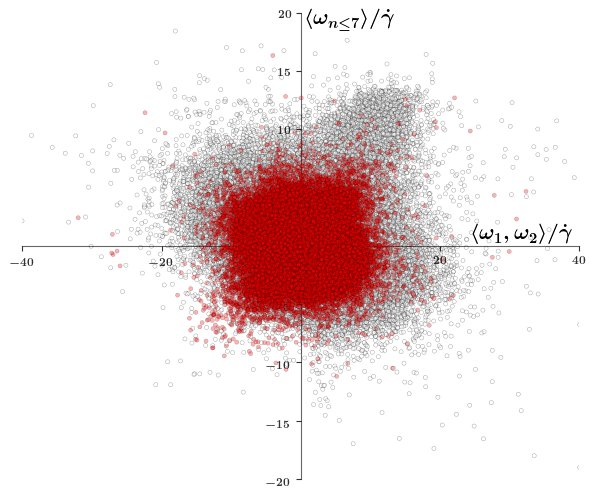

In [25]:
## plot w vs w_n<6 and mean dumbell wrt to gamma

plt.figure(figsize = (6, 5))

is_red  = colors_all == 'red' # index of red points
not_red = ~is_red             # index of non-red points

plt.scatter(angvel_all[not_red], neighAngVel_all[not_red],      # non-red points below
            s=35, c=colors_all[not_red], alpha=0.4, marker='.',
            linewidths=0.3, edgecolors='k', zorder=1)

plt.scatter(angvel_all[is_red], neighAngVel_all[is_red],        # red points above
            s=35, c=colors_all[is_red], alpha=0.3, marker='.',
            linewidths=0.3, edgecolors='k', zorder=10)

ax = plt.gca()
for spine in ['left', 'bottom']:
    ax.spines[spine].set_position('zero')
    ax.spines[spine].set_alpha(0.6)
    
for spine in ['top', 'right']:
    ax.spines[spine].set_color('none')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.set_xticks([t for t in ax.get_xticks() if t != 0])
ax.set_yticks([t for t in ax.get_yticks() if t != 0])
ax.set_ylim(-20, 20) #angvel_neigh
ax.set_xlim(-40, 40) #angvel

#ax.set_ylim(-400, 400) #angvel_neigh
#ax.set_xlim(-750, 750) #angvel

for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.tick1line.set_alpha(0.8)
    tick.label1.set_alpha(0.8)
ax.set_xlabel(r'$\langle \omega_1, \omega_2 \rangle/ \dot \gamma$', labelpad=15, ha='right', fontsize=15)
ax.set_ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', labelpad=10, va='top', rotation=0, fontsize=15)
ax.xaxis.set_label_coords(0.99, 0.55)
ax.yaxis.set_label_coords(0.59, 1.01)
plt.savefig(f"{fig_save_path}/angvel_{k}-neighbor_sr_mean_dumbell_rigid_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800, transparent=False)
plt.grid(False)
print(f'{phi}')
plt.show()

In [12]:
## 2nd moment tensor of elipse

## Angular velocity vs RELEVANT neighbouring <=k particle angular velocity
# normalized wrt shear rate

npp  = 1000
runs = 2
phi  = 0.77
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7  # max number of neighbors
phir = '{:.3f}'.format(phi) if len(str(phi).split('.')[1])>2 else '{:.2f}'.format(phi)

angvel_all      = []
neighAngVel_all = []
colors_all      = []
idxlen = []

for l in range(runs):
    dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"  
    dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
    parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
    rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
    datdata   = np.genfromtxt(dataFile)
    pardata   = readFiles.readParFile(parFile)
    rigdata   = readFiles.rigList(rigFile)
    srate     = datdata[off:, 2]
    totStrain = datdata[-1, 1]
    parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

    lx = float(parLines[3].split()[2]) 
    lz = float(parLines[5].split()[2])
    
    for i, frame in enumerate(pardata[off:]):
        angvel = frame[:,8]
        pidx   = frame[:, 0]
        pr     = frame[:, 1]
        px     = frame[:, 2]
        pz     = frame[:, 3]
        sr     = srate[i]
        
        xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
        dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix
        
        # Lees Edwards boundary:
        dxij[dzij > lz/2.]  -= sr*lx
        dzij[dzij > lz/2.]  -= lz
        
        dxij[dzij < -lz/2.] += sr*lx
        dzij[dzij < -lz/2.] += lz
        
        # X peridodic:
        dxij[dxij >  lx/2.] -= lx
        dxij[dxij < -lx/2.] += lx
    
        dij = np.sqrt(dxij**2 + dzij**2) # norm dist matrix
        
        for ii in pidx:
            sorted_indices = np.argsort(dij[:, int(ii)]) # all neighbors sorted by distance to particle ii
            within_cutoff  = dij[sorted_indices, int(ii)] <= 1.5 * (1+ar) # distance cuttoff
            idx = sorted_indices[within_cutoff][1:k+1]  # skip self # this list wont crash
            idxlen.append(len(idx))
            
            neighAngVel = np.mean(angvel[idx])     # mean ang vel of nearest neighbors
            neighAngVel_all.append(neighAngVel/sr) 

        rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
        color   = np.array(['white'] * npp)
        color[list(rigList[off+i])] = 'r'

        angvel_all.extend(angvel/sr)
        colors_all.extend(list(color))

angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
neighAngVel_all = np.array(neighAngVel_all) - np.mean(neighAngVel_all)
colors_all      = np.array(colors_all)

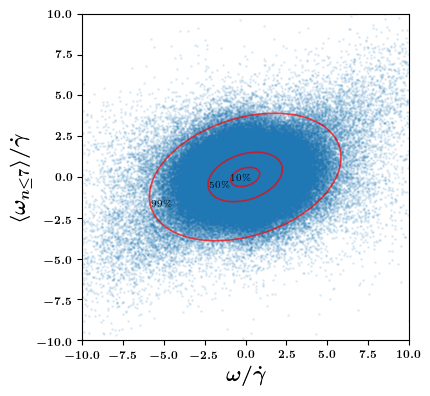

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# Masks for red points
is_red = colors_all == 'r'

x = angvel_all[is_red]
y = neighAngVel_all[is_red]

# Stack into 2D points
points = np.vstack((x, y)).T

# Mean and covariance
mu = np.mean(points, axis=0)
cov = np.cov(points, rowvar=False)

# Eigen-decomposition
eigenvals, eigenvecs = np.linalg.eigh(cov)
order     = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]

# Orientation angle
angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))

# Confidence levels (logarithmic or custom)
conf_levels = np.array([0.1, 0.5, 0.99])

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(x, y, s=1, alpha=0.1)

# Add ellipses with labels
for p in conf_levels:
    chi2_val = chi2.ppf(p, df=2)
    width, height = 2 * np.sqrt(chi2_val * eigenvals)
    
    ell = Ellipse(xy=mu, width=width, height=height, angle=angle,
                  edgecolor='red', facecolor='none', lw=1.2, alpha=0.7)
    ax.add_patch(ell)
    
    # Compute label position on ellipse perimeter (major axis direction)
    r      = np.sqrt(chi2_val)
    dx, dy = eigenvecs[:, 0] * np.sqrt(chi2_val * eigenvals[0])  # major axis
    
    label_x = mu[0] + dx
    label_y = mu[1] + dy*3
    
    ax.text(label_x, label_y, f"{int(p*100)}\\%", fontsize=7, weight='bold')#,
            #bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Mark the mean
#ax.plot(*mu, 'ko', markersize=4)

ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
ax.set_aspect('equal')

#ax.set_title("Log-spaced Confidence Ellipses (10% to 99%)")
plt.xlabel(r'$\omega / \dot \gamma$', fontsize=15)
plt.ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', fontsize=15)

plt.grid(False)
#plt.savefig(f"{fig_save_path}/ellipse_fit_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800)
print(f'{phi})
plt.show()

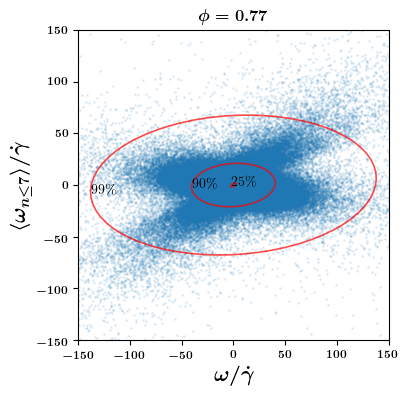

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

#plt.clear()

# Convert input data to NumPy arrays
angvel_all      = np.array(angvel_all)
neighAngVel_all = np.array(neighAngVel_all)
colors_all      = np.array(colors_all)

# Filter red points
is_red = colors_all == 'r'
x = angvel_all[is_red]
y = neighAngVel_all[is_red]
points = np.vstack((x, y)).T

# Global mean and covariance for Mahalanobis distance calculation
mu_all  = np.mean(points, axis=0)
cov_all = np.cov(points, rowvar=False)
inv_cov_all = np.linalg.inv(cov_all)

# Compute Mahalanobis distance squared for all red points
delta = points - mu_all
mahal_sq = np.einsum('ij,jk,ik->i', delta, inv_cov_all, delta)

# Define desired percentiles
percentiles = [25, 90, 99]

# Plotting
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(x, y, s=1, alpha=0.1)

angles_all = []

for p in percentiles:
    # Threshold: select closest p% points
    thresh = np.percentile(mahal_sq, p)
    mask = mahal_sq <= thresh
    selected_points = points[mask]
    
    if len(selected_points) < 5:
        continue  # Too few points to compute meaningful ellipse
    
    # Mean and covariance of selected group
    mu  = np.mean(selected_points, axis=0)
    cov = np.cov(selected_points, rowvar=False)
    inv_cov = np.linalg.inv(cov)

    # Eigen-decomposition of covariance
    eigenvals, eigenvecs = np.linalg.eigh(cov)
    order = np.argsort(eigenvals)[::-1]
    eigenvals = eigenvals[order]
    eigenvecs = eigenvecs[:, order]

    # Orientation of ellipse
    angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))
    angles_all.append(angle)
    
    # Scale ellipse to enclose all selected points
    delta_sel = selected_points - mu
    mahal_sq_sel = np.einsum('ij,jk,ik->i', delta_sel, inv_cov, delta_sel)
    max_mahal = np.sqrt(np.max(mahal_sq_sel))
    width, height = 2 * max_mahal * np.sqrt(eigenvals)

    # Draw ellipse
    ell = Ellipse(xy=mu, width=width, height=height, angle=angle,
                  edgecolor='red', facecolor='none', lw=1.2, alpha=0.7)
    ax.add_patch(ell)

    # Label the ellipse
    dx, dy = eigenvecs[:, 0] * np.sqrt(eigenvals[0]) * max_mahal
    label_x = mu[0] + dx
    label_y = mu[1] + dy
    ax.text(label_x, label_y, fr"{p}\%", fontsize=10, weight='bold')

# Final plot formatting
lims = 150
ax.set_xlim([-lims, lims])
ax.set_ylim([-lims, lims])
ax.set_aspect('equal')
plt.title(fr'$\phi = {phi}$', fontsize = 12)
plt.xlabel(r'$\omega / \dot \gamma$', fontsize=15)
plt.ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', fontsize=15)
plt.savefig(f"{fig_save_path}/ellipse_fit_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800)
plt.grid(False)
#plt.tightlayout
plt.show()

In [18]:
angles_all

[-152.89550177752827, -176.13551162754, -176.42779643658923]

In [49]:
angles_all_phi = np.array([-164.4279462116425, -164.22149890460423, -166.1453584896456],
                         [-158.75185094657812, -162.09445070655897, -163.7807936110359],
                         [-152.89550177752827, -176.13551162754, -176.42779643658923])

[-158.75185094657812, -162.09445070655897, -163.7807936110359]

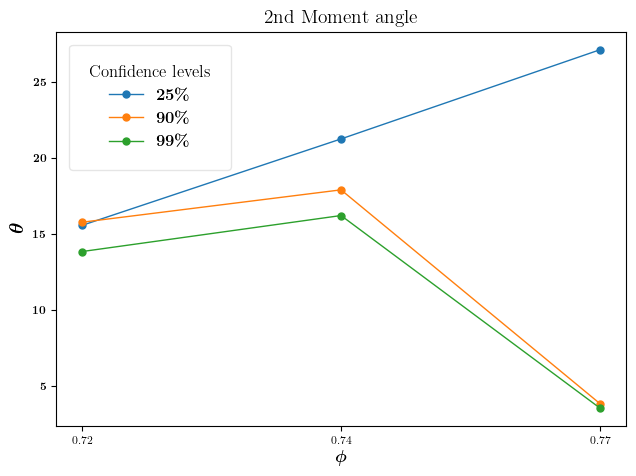

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Original angles (in degrees)
angles_all_phi = np.array([
    [-164.4279462116425, -164.22149890460423, -166.1453584896456],
    [-158.75185094657812, -162.09445070655897, -163.7807936110359],
    [-152.89550177752827, -176.13551162754, -176.42779643658923]
])

# Convert to [0, 360) by taking modulo
angles_all_phi = angles_all_phi % 180

# Transpose to iterate over columns
angles_all_phi = angles_all_phi.T

confidence = [25, 90, 99]

# Plot each column (now row after transpose)
for i, col in enumerate(angles_all_phi):
    plt.plot(col, label=fr'${confidence[i]}\%$', marker='o')

plt.ylabel(r'$\theta$', fontweight= 'bold', fontsize = 14)
plt.title('2nd Moment angle', fontweight= 'bold', fontsize = 14)

plt.legend(title='Confidence levels',title_fontsize=12, fontsize=12, loc='best', frameon=True, 
           facecolor='white', edgecolor='black', framealpha=0.1, borderpad=1.2, labelspacing=0.5, 
           borderaxespad=0.8)

plt.xlabel(r'$\phi$', fontweight= 'bold', fontsize = 12)
plt.xticks(ticks=[0, 1, 2], labels=['0.72', '0.74', '0.77'])
plt.grid(False)
plt.tight_layout()
plt.savefig(f"{fig_save_path}/2ndmoment_angles_.png", bbox_inches="tight", dpi=800)
plt.show()

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.stats import chi2

# Data arrays
# angvel_all      = np.array(angvel_all)
# neighAngVel_all = np.array(neighAngVel_all)
# colors_all      = np.array(colors_all)

# Masks for red points
is_red = colors_all == 'red'

x = angvel_all[is_red]
y = neighAngVel_all[is_red]

# Stack into 2D points
points = np.vstack((x, y)).T

# Mean and covariance
mu = np.mean(points, axis=0)
cov = np.cov(points, rowvar=False)

# Eigen-decomposition
eigenvals, eigenvecs = np.linalg.eigh(cov)
order     = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[order]
eigenvecs = eigenvecs[:, order]

# Orientation angle
angle = np.degrees(np.arctan2(*eigenvecs[:, 0][::-1]))

# Confidence levels (logarithmic or custom)
conf_levels = np.array([0.1, 0.5, 0.99])

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(x, y, s=1, alpha=0.1)

# Add ellipses with labels
for p in conf_levels:
    chi2_val = chi2.ppf(p, df=2)
    width, height = 2 * np.sqrt(chi2_val * eigenvals)
    
    ell = Ellipse(xy=mu, width=width, height=height, angle=angle,
                  edgecolor='red', facecolor='none', lw=1.2, alpha=0.7)
    ax.add_patch(ell)
    
    # Compute label position on ellipse perimeter (major axis direction)
    r      = np.sqrt(chi2_val)
    dx, dy = eigenvecs[:, 0] * np.sqrt(chi2_val * eigenvals[0])  # major axis
    
    label_x = mu[0] + dx
    label_y = mu[1] + dy
    
    ax.text(label_x, label_y, f"{int(p*100)}\\%", fontsize=7, weight='bold')#,
            #bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Mark the mean
#ax.plot(*mu, 'ko', markersize=4)

ax.set_xlim([-100, 100])
ax.set_ylim([-100, 100])
ax.set_aspect('equal')

#ax.set_title("Log-spaced Confidence Ellipses (10% to 99%)")
plt.xlabel(r'$\omega / \dot \gamma$', fontsize=15)
plt.ylabel(fr'$\langle \omega_{{n \leq {k}}} \rangle / \dot \gamma$', fontsize=15)

plt.grid(False)
#plt.savefig(f"{fig_save_path}/ellipse_fit_phi_{phi}_ar_{ar}_vr_{vr}.png", bbox_inches="tight", dpi=800)
plt.show()

/Users/rahul/anaconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/rahul/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/rahul/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/var/folders/7z/4v7gv78n0rq_k11539h6b9zc0000gn/T/ipykernel_35174/3940969213.py:22: RuntimeWarning: Degrees of freedom <= 0 for slice
  cov = np.cov(points, rowvar=False)
/Users/rahul/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/rahul/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
posx a

ValueError: need at least one array to concatenate

<Figure size 500x400 with 1 Axes>

In [4]:
eigenvecs[:, 0]eigenvecs[:, 0]

array([0.1       , 0.12901082, 0.16643791, 0.21472292, 0.27701579,
       0.35738034, 0.46105931, 0.59481639, 0.7673775 , 0.99      ])

In [ ]:
from scipy.stats import gaussian_kde

# 2D density estimation
xy = np.vstack([x, y])
kde = gaussian_kde(xy)
z = kde(xy)

# Sort points by density for better plotting
idx = z.argsort()
x_plot, y_plot, z_plot = x[idx], y[idx], z[idx]

plt.scatter(x_plot, y_plot, c=z_plot, s=10, cmap='viridis')
plt.colorbar(label='Density')

In [ ]:
# Grid-based KDE
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]  # 100x100 grid
positions = np.vstack([X.ravel(), Y.ravel()])

kde = gaussian_kde(np.vstack([x, y]))
Z = np.reshape(kde(positions), X.shape)

# Plot density background
plt.imshow(np.rot90(Z), extent=[xmin, xmax, ymin, ymax], cmap='viridis')
plt.scatter(x, y, s=1, c='white', alpha=0.3)
plt.colorbar(label='Density')


## Filteration using w1-w2

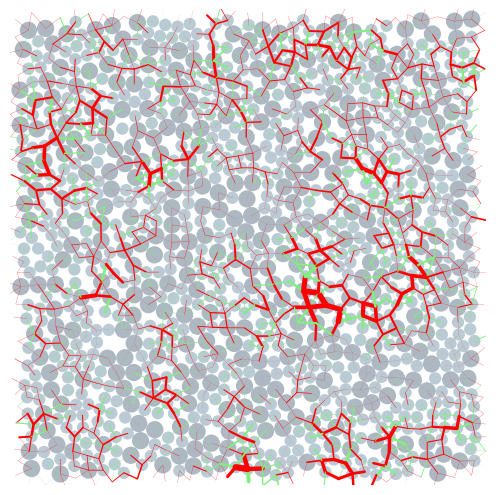

In [33]:
## filteration w1-w2 contact network based on varying frames and constant threshold

npp     = 1000
phi     = 0.76
ar      = '1.4'
vr      = '0.5'
run     = 1
off     = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

# Frame details
startFrame = 500
endFrame   = 501

maxLineWidth = 4.5

if os.path.exists(dataname):
    par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
    dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]
    int_file = glob.glob(f'{dataname}/run_{run}/{intFile}')[0]
    rig_file = glob.glob(f'{dataname}/run_{run}/{rigFile}')[0]

    if par_file and rig_file:
        dataArr  = np.loadtxt(dat_file)
        parList  = readFiles.readParFile(open(par_file))
        intList  = readFiles.interactionsList(open(int_file))
        parLines = open(par_file).readlines()

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        # setting up axis and box walls
        #_, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
        newLx = Lx + 2*float(ar)
        newLz = Lz + 2*float(ar)

        for frame in range(startFrame, endFrame):
            frameArr = []
            intFrame = intList[frame]
            parFrame = parList[frame]
            numInts  = intFrame.shape[0]
            
            for i in range(numInts):
                n1    = int(intFrame[i,  0])
                n2    = int(intFrame[i,  1])
                px1   = parFrame[n1, 2]
                py1   = parFrame[n1, 3]
                px2   = parFrame[n2, 2]
                py2   = parFrame[n2, 3]
                a1    = parFrame[n1, 1]
                a2    = parFrame[n2, 1]
                w1    = parFrame[n1, 8]
                w2    = parFrame[n2, 8]
                nxij  = intFrame[i,  2]
                nyij  = intFrame[i,  4]
                gapij = intFrame[i,  5]
                cs    = intFrame[i, 10]

                frameArr.append([n1, n2, px1, py1, px2, py2, a1, a2, w1, w2, nxij, nyij, gapij, cs])
                
            frameArr = np.array(frameArr)
            
            # plot parameters
            wdiff         = np.abs(frameArr[:, 8] - frameArr[:, 9])
            contLineWidth = wdiff * maxLineWidth / np.max(wdiff)
            intColor      = np.array(['r']*numInts, dtype=object)
            contLess      = np.array(frameArr[:, -1] == 0, dtype=bool)
            fricLess      = np.array(frameArr[:, -1] == 1, dtype=bool)
            if contLess.size > 0: intColor[contLess] = '#80EF80'
            if fricLess.size > 0: intColor[fricLess] = 'tab:cyan'

            fig, ax = plt.subplots(1, 1, figsize=(5,5))

            # plotting all particles
            px = parFrame[:, 2]
            py = parFrame[:, 3]
            pr = parFrame[:, 1]
            for j in range(npp):
                if pr[j] == 1:
                    circle = plt.Circle((px[j],py[j]), pr[j], facecolor='#9fb5c4', fill=True, edgecolor='none', alpha=0.7)
                else:
                    circle = plt.Circle((px[j],py[j]), pr[j], facecolor='#8a9ba8', fill=True, edgecolor='none', alpha=0.7)
                ax.add_artist(circle)

            # plotting interactions
            for k in range(numInts):
                p1   = int(frameArr[k, 0])
                p2   = int(frameArr[k, 1])
                pos1 = np.array([frameArr[k, 2], frameArr[k, 3]]) # particle 1 x-,y-position
                pos2 = np.array([frameArr[k, 4], frameArr[k, 5]]) # particle 2 x-,y-position
                gap  = frameArr[k, -2]
                nij  = np.array([frameArr[k, 10], frameArr[k, 11]])  # normal vector 1 to 2
                pir  = pr[p1]
                pjr  = pr[p2]
                rij  = nij * (gap + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                p11  = pos1 + rij
                
                ax.plot([pos1[0], p11[0]],[pos1[1], p11[1]], color=intColor[k], linewidth=contLineWidth[k], solid_capstyle='round', solid_joinstyle='round')

                if (np.sign(nij[0]) != np.sign((pos2 - pos1)[0])) or (np.sign(nij[1]) != np.sign((pos2 - pos1)[1])):
                    p22 = pos2 - rij
                    ax.plot([pos2[0], p22[0]], [pos2[1], p22[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')

            ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
            ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
            #ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=10, fontweight='bold')
            ax.axis('off')
            ax.set_aspect('equal')

#             directory = f'{fig_save_path}phi_{phii}_ar_{ar[k]}_vr_{vr[l]}_int'
#             os.makedirs(directory, exist_ok=True)
#             fig.savefig(f'{directory}/{frame}.png', dpi=400)
#             print(f'>     Processed frame: {frame}/{endFrame-1}      ')
#             plt.close()
            plt.show()

In [97]:
## Lubrication vs frictional contacts
## filteration w1-w2 contact network based on varying threshold and constant frame

npp = 1000
phi = 0.77
ar  = '1.4'
vr  = '0.5'
run = 1
off = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

# Frame details
frame = 1200
thresholds = np.linspace(0, 2, 6)
#thresholds = [0.25]
maxLineWidth = 4

if os.path.exists(dataname):
    par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
    dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]
    int_file = glob.glob(f'{dataname}/run_{run}/{intFile}')[0]
    rig_file = glob.glob(f'{dataname}/run_{run}/{rigFile}')[0]

    if par_file and rig_file:
        dataArr  = np.loadtxt(dat_file)
        parList  = readFiles.readParFile(open(par_file))
        intList  = readFiles.interactionsList(open(int_file))
        parLines = open(par_file).readlines()

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        # setting up axis and box walls
        #_, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
        newLx = Lx + 2*float(ar)
        newLz = Lz + 2*float(ar)

        #for frame in range(startFrame, endFrame):
        
        frameArr = []
        intFrame = intList[frame]
        parFrame = parList[frame]
        numInts  = intFrame.shape[0]

        for i in range(numInts):
            n1    = int(intFrame[i,  0])
            n2    = int(intFrame[i,  1])
            px1   = parFrame[n1, 2]
            py1   = parFrame[n1, 3]
            px2   = parFrame[n2, 2]
            py2   = parFrame[n2, 3]
            a1    = parFrame[n1, 1]
            a2    = parFrame[n2, 1]
            w1    = parFrame[n1, 8]
            w2    = parFrame[n2, 8]
            nxij  = intFrame[i,  2]
            nyij  = intFrame[i,  4]
            gapij = intFrame[i,  5]
            cs    = intFrame[i, 10]

            frameArr.append([n1, n2, px1, py1, px2, py2, a1, a2, w1, w2, nxij, nyij, gapij, cs])

        frameArr = np.array(frameArr)

        # plot parameters
        wdiff         = np.abs(frameArr[:, 8] - frameArr[:, 9])
        contLineWidth = wdiff * maxLineWidth / np.max(wdiff) + 0.3
        intColor      = np.array(['r']*numInts, dtype=object)
        contLess      = np.array(frameArr[:, -1] == 0, dtype=bool)
        fricLess      = np.array(frameArr[:, -1] == 1, dtype=bool)
        if contLess.size > 0: intColor[contLess] = '#80EF80'
        if fricLess.size > 0: intColor[fricLess] = 'tab:cyan'

        # plotting interactions
        for ii, threshold in enumerate(thresholds):
            fig, ax = plt.subplots(1, 1, figsize=(3,3))

            # plotting all particles
            px = parFrame[:, 2]
            py = parFrame[:, 3]
            pr = parFrame[:, 1]
            for j in range(npp):
                circle = plt.Circle((px[j],py[j]), 0.4, facecolor='#9fb5c4', fill=True, edgecolor='none', alpha=0.6)            
                ax.add_artist(circle)
            
            indices      = np.where(wdiff > threshold)[0]
            filtered_arr = frameArr[indices, :]

            for k in range(filtered_arr.shape[0]):
                p1   = int(frameArr[k, 0])
                p2   = int(frameArr[k, 1])
                pos1 = np.array([frameArr[k, 2], frameArr[k, 3]]) # particle 1 x-,y-position
                pos2 = np.array([frameArr[k, 4], frameArr[k, 5]]) # particle 2 x-,y-position
                gap  = frameArr[k, -2]
                nij  = np.array([frameArr[k, 10], frameArr[k, 11]])  # normal vector 1 to 2
                pir  = pr[p1]
                pjr  = pr[p2]
                rij  = nij * (gap + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                p11  = pos1 + rij

                ax.plot([pos1[0], p11[0]],[pos1[1], p11[1]], color=intColor[k], linewidth=contLineWidth[k], solid_capstyle='round', solid_joinstyle='round')

                if (np.sign(nij[0]) != np.sign((pos2 - pos1)[0])) or (np.sign(nij[1]) != np.sign((pos2 - pos1)[1])):
                    p22 = pos2 - rij
                    ax.plot([pos2[0], p22[0]], [pos2[1], p22[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')

            ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
            ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
            ax.set_title(fr'$\Omega = {threshold:.2f}$', pad=5, fontweight='bold')
            ax.axis('off')
            ax.set_aspect('equal')

            directory = f'{fig_save_path}/phi_{phir}_ar_{ar}_vr_{vr}_angvel_diff'
            os.makedirs(directory, exist_ok=True)
            fig.savefig(f'{directory}/t_{threshold:.2f}.svg', transparent=True, dpi=500)
            print(f'>     Processed frame: {ii+1}/{len(thresholds)}      ')
            plt.close()
            plt.show()

>     Processed frame: 1/6      
>     Processed frame: 2/6      
>     Processed frame: 3/6      
>     Processed frame: 4/6      
>     Processed frame: 5/6      
>     Processed frame: 6/6      


In [70]:
## co-rotating vs counter-rotating
## filteration w1-w2 contact network based on varying threshold and constant frame

npp = 1000
phi = 0.77
ar  = '1.4'
vr  = '0.5'
run = 1
off = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

# Frame details
frame = 1200
thresholds = np.linspace(0, 2, 6)
#thresholds = [0.25]
maxLineWidth = 4

if os.path.exists(dataname):
    par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
    dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]
    int_file = glob.glob(f'{dataname}/run_{run}/{intFile}')[0]
    rig_file = glob.glob(f'{dataname}/run_{run}/{rigFile}')[0]

    if par_file and rig_file:
        dataArr  = np.loadtxt(dat_file)
        parList  = readFiles.readParFile(open(par_file))
        intList  = readFiles.interactionsList(open(int_file))
        parLines = open(par_file).readlines()

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        # setting up axis and box walls
        #_, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
        newLx = Lx + 2*float(ar)
        newLz = Lz + 2*float(ar)

        #for frame in range(startFrame, endFrame):
        
        frameArr = []
        intFrame = intList[frame]
        parFrame = parList[frame]
        numInts  = intFrame.shape[0]

        for i in range(numInts):
            n1    = int(intFrame[i,  0])
            n2    = int(intFrame[i,  1])
            px1   = parFrame[n1, 2]
            py1   = parFrame[n1, 3]
            px2   = parFrame[n2, 2]
            py2   = parFrame[n2, 3]
            a1    = parFrame[n1, 1]
            a2    = parFrame[n2, 1]
            w1    = parFrame[n1, 8]
            w2    = parFrame[n2, 8]
            nxij  = intFrame[i,  2]
            nyij  = intFrame[i,  4]
            gapij = intFrame[i,  5]
            cs    = intFrame[i, 10]

            frameArr.append([n1, n2, px1, py1, px2, py2, a1, a2, w1, w2, nxij, nyij, gapij, cs])

        frameArr = np.array(frameArr)

        # plot parameters
        wdiff         = frameArr[:, 8] - frameArr[:, 9]
        contLineWidth = np.abs(wdiff) * maxLineWidth / np.max(np.abs(wdiff)) + 0.2
        intColor      = np.array(['r']*numInts, dtype=object)
        coRotating    = np.array(np.sign(wdiff) ==  1, dtype=bool)
        antiRotating  = np.array(np.sign(wdiff) == -1, dtype=bool)
        intColor[coRotating]   = '#80EF80'
        intColor[antiRotating] = 'navy'

        # plotting interactions
        for ii, threshold in enumerate(thresholds):
            fig, ax = plt.subplots(1, 1, figsize=(3,3))

            # plotting all particles
            px = parFrame[:, 2]
            py = parFrame[:, 3]
            pr = parFrame[:, 1]
            for j in range(npp):
                circle = plt.Circle((px[j],py[j]), 0.4, facecolor='#9fb5c4', fill=True, edgecolor='none', alpha=0.6)            
                ax.add_artist(circle)
            
            indices      = np.where(np.abs(wdiff) > threshold)[0]
            filtered_arr = frameArr[indices, :]

            for k in range(filtered_arr.shape[0]):
                p1   = int(frameArr[k, 0])
                p2   = int(frameArr[k, 1])
                pos1 = np.array([frameArr[k, 2], frameArr[k, 3]]) # particle 1 x-,y-position
                pos2 = np.array([frameArr[k, 4], frameArr[k, 5]]) # particle 2 x-,y-position
                gap  = frameArr[k, -2]
                nij  = np.array([frameArr[k, 10], frameArr[k, 11]])  # normal vector 1 to 2
                pir  = pr[p1]
                pjr  = pr[p2]
                rij  = nij * (gap + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                p11  = pos1 + rij

                ax.plot([pos1[0], p11[0]],[pos1[1], p11[1]], color=intColor[k], linewidth=contLineWidth[k], solid_capstyle='round', solid_joinstyle='round')

                if (np.sign(nij[0]) != np.sign((pos2 - pos1)[0])) or (np.sign(nij[1]) != np.sign((pos2 - pos1)[1])):
                    p22 = pos2 - rij
                    ax.plot([pos2[0], p22[0]], [pos2[1], p22[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')

            ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
            ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
            ax.set_title(fr'$\Omega = {threshold:.2f}$', pad=5, fontweight='bold')
            ax.axis('off')
            ax.set_aspect('equal')

            directory = f'{fig_save_path}/phi_{phir}_ar_{ar}_vr_{vr}_angvel_diff_rotating'
            os.makedirs(directory, exist_ok=True)
            fig.savefig(f'{directory}/t_{threshold:.2f}.svg', transparent=True, dpi=500)
            print(f'>     Processed frame: {ii+1}/{len(thresholds)}      ')
            plt.close()
            plt.show()

>     Processed frame: 1/6      
>     Processed frame: 2/6      
>     Processed frame: 3/6      
>     Processed frame: 4/6      
>     Processed frame: 5/6      
>     Processed frame: 6/6      


In [42]:
## Betti 0 plot with varying threshold for a case
## All chains


npp     = 1000
phi     = 0.72
ar      = '1.4'
vr      = '0.5'
numRuns = 2
off     = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

# Frame details
# startFrame = 100
# endFrame   = 2001

maxdiff = 0

if os.path.exists(dataname):
    bettiMat   = []
    for l in range(numRuns):
        run = l + 1
        par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
        dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]
        int_file = glob.glob(f'{dataname}/run_{run}/{intFile}')[0]
        rig_file = glob.glob(f'{dataname}/run_{run}/{rigFile}')[0]
        datdata  = np.genfromtxt(dat_file)
        srate    = datdata[:, 2]

        if par_file and rig_file:
            parList    = readFiles.readParFile(open(par_file))
            intList    = readFiles.interactionsList(open(int_file))
            parLines   = open(par_file).readlines()
            thresholds = np.linspace(0, 20, 50)

            for frame in tqdm(range(off, 102)):# len(srate))):
                chainno  = []
                frameArr = []
                intFrame = intList[frame]
                parFrame = parList[frame]
                numInts  = intFrame.shape[0]
                sr       = srate[frame]

                for i in range(numInts):
                    n1    = int(intFrame[i,  0])
                    n2    = int(intFrame[i,  1])
                    w1    = parFrame[n1, 8]/sr
                    w2    = parFrame[n2, 8]/sr
                    wdiff = np.abs(w1 - w2)

                    frameArr.append([n1, n2, wdiff])

                frameArr = np.array(frameArr)
                n1       = frameArr[:, 0].astype(int)
                n2       = frameArr[:, 1].astype(int)
                wdiff    = frameArr[:, 2]
                maxdiff  = max(wdiff) if max(wdiff) > maxdiff else maxdiff

                for threshold in thresholds: 
                    filtered_edges = [(i, j) for i, j, w in zip(n1, n2, wdiff) if w >= threshold] # filtering
                    G = nx.Graph() # to identify networks
                    G.add_edges_from(filtered_edges)

                    chains = list(nx.connected_components(G))
                    betti0 = len(chains)
                    #chain_sizes = [len(chain) for chain in chains]
                    chainno.append(betti0)

                bettiMat.append(chainno)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 24.97it/s]


In [36]:
len(bettiMat)

4

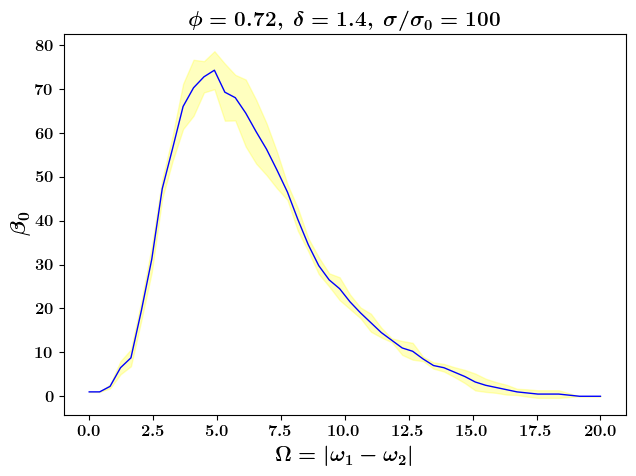

In [48]:
## Plot
bettiMat = np.array(bettiMat)

col_sum = np.mean(bettiMat, axis=0)
col_std = np.std(bettiMat,  axis=0)

# Smooth line without markers
plt.plot(thresholds, col_sum, '-', color='blue')  # Solid line

# Shaded region (yellow and transparent)
plt.fill_between(thresholds, col_sum - col_std, col_sum + col_std, color='yellow', alpha=0.25, label='±1 Std Dev')
plt.xlabel(r'$\Omega = |\omega_1 - \omega_2|$', fontsize=15)
plt.ylabel(r'$\beta_0$', fontsize=16)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.title(rf'$\phi = {phir},\ \delta = {ar},\ \sigma/\sigma_0 = 100$', fontsize=15)
plt.tight_layout()
#plt.savefig(f'{fig_save_path}/Betti0_phi_{phir}_ar_{ar}_vr_{vr}.svg', transparent=True, dpi=500)
plt.show()

In [38]:
bettiMat.shape

(4, 100)

In [39]:
## co-rotating vs counter-rotating

npp = 1000
phi = 0.77
ar  = '1.4'
vr  = '0.5'
run = 1
off = 100

parFile  = 'par_*.dat'
datFile  = 'data_*.dat'
intFile  = 'int_*.dat'
rigFile  = 'rig_*.dat'
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

# Frame details
frames = [500, 700, 1200, 1800, 2000]
#thresholds = np.linspace(0, 2, 6)
#thresholds = [0.25]
maxLineWidth = 4

if os.path.exists(dataname):
    par_file = glob.glob(f'{dataname}/run_{run}/{parFile}')[0]
    dat_file = glob.glob(f'{dataname}/run_{run}/{datFile}')[0]
    int_file = glob.glob(f'{dataname}/run_{run}/{intFile}')[0]
    rig_file = glob.glob(f'{dataname}/run_{run}/{rigFile}')[0]
    
    if par_file and rig_file:
        dataArr  = np.loadtxt(dat_file)
        parList  = readFiles.readParFile(open(par_file))
        intList  = readFiles.interactionsList(open(int_file))
        parLines = open(par_file).readlines()
        rigdata  = readFiles.rigList(open(rig_file))
        rigList  = [set(sum(rigFrame, [])) for rigFrame in rigdata] # flatten rig data

        # box dimensions
        Lx = float(parLines[3].split()[2]) 
        Lz = float(parLines[3].split()[2])

        # setting up axis and box walls
        #_, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
        newLx = Lx + 2*float(ar)
        newLz = Lz + 2*float(ar)

        #for frame in range(startFrame, endFrame):
        for ii, frame in enumerate(frames):
            frameArr = []
            intFrame = intList[frame]
            parFrame = parList[frame]
            numInts  = intFrame.shape[0]

            for i in range(numInts):
                n1    = int(intFrame[i,  0])
                n2    = int(intFrame[i,  1])
                px1   = parFrame[n1, 2]
                py1   = parFrame[n1, 3]
                px2   = parFrame[n2, 2]
                py2   = parFrame[n2, 3]
                a1    = parFrame[n1, 1]
                a2    = parFrame[n2, 1]
                w1    = parFrame[n1, 8]
                w2    = parFrame[n2, 8]
                nxij  = intFrame[i,  2]
                nyij  = intFrame[i,  4]
                gapij = intFrame[i,  5]
                cs    = intFrame[i, 10]

                frameArr.append([n1, n2, px1, py1, px2, py2, a1, a2, w1, w2, nxij, nyij, gapij, cs])

            frameArr = np.array(frameArr)

            # plot parameters
            wdiff         = frameArr[:, 8] - frameArr[:, 9]
            contLineWidth = np.abs(wdiff) * maxLineWidth / np.max(np.abs(wdiff)) + 0.2
            intColor      = np.array(['r']*numInts, dtype=object)
            coRotating    = np.array(np.sign(wdiff) ==  1, dtype=bool)
            antiRotating  = np.array(np.sign(wdiff) == -1, dtype=bool)
            intColor[coRotating]   = '#228B22'
            intColor[antiRotating] = 'navy'

            # plotting interactions
            fig, ax = plt.subplots(1, 1, figsize=(3,3))

            # plotting all particles
            px = parFrame[:, 2]
            py = parFrame[:, 3]
            pr = parFrame[:, 1]
            for j in range(npp):
                circle = plt.Circle((px[j],py[j]), 0.4, facecolor='#9fb5c4', fill=True, edgecolor='none', alpha=0.4)            
                ax.add_artist(circle)
            
            for jj in rigList[frame]:
                circle = plt.Circle((px[jj], py[jj]), 0.6, facecolor='red', fill=True, edgecolor='none', alpha=0.8, zorder=20)           
                ax.add_artist(circle)
            
            contactState = frameArr[:, -1]
            indices      = np.where(contactState == 2)[0]
            filtered_arr = frameArr[indices, :]

            for k in range(filtered_arr.shape[0]):
                p1   = int(frameArr[k, 0])
                p2   = int(frameArr[k, 1])
                pos1 = np.array([frameArr[k, 2], frameArr[k, 3]]) # particle 1 x-,y-position
                pos2 = np.array([frameArr[k, 4], frameArr[k, 5]]) # particle 2 x-,y-position
                gap  = frameArr[k, -2]
                nij  = np.array([frameArr[k, 10], frameArr[k, 11]])  # normal vector 1 to 2
                pir  = pr[p1]
                pjr  = pr[p2]
                rij  = nij * (gap + 2.) * (pir + pjr) * 0.5 # vector length between partcle 1 and 2
                p11  = pos1 + rij

                ax.plot([pos1[0], p11[0]],[pos1[1], p11[1]], color=intColor[k], linewidth=contLineWidth[k], solid_capstyle='round', solid_joinstyle='round')

                if (np.sign(nij[0]) != np.sign((pos2 - pos1)[0])) or (np.sign(nij[1]) != np.sign((pos2 - pos1)[1])):
                    p22 = pos2 - rij
                    ax.plot([pos2[0], p22[0]], [pos2[1], p22[1]], color=intColor[0], linewidth=contLineWidth[0], solid_capstyle='round', solid_joinstyle='round')

            ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
            ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
            ax.set_title(fr'$\gamma = {frame/100:.2f}$', pad=5, fontweight='bold')
            ax.axis('off')
            ax.set_aspect('equal')

            directory = f'{fig_save_path}/phi_{phir}_ar_{ar}_vr_{vr}_angvel_diff_rotating_w_rigid_frictional'
            os.makedirs(directory, exist_ok=True)
            fig.savefig(f'{directory}/t_{frame:.0f}.png', transparent=True, dpi=500)
            #print(f'>     Processed frame: {ii+1}/{len(thresholds)}      ')
            print(f'>     Processed frame: {ii+1}/{len(frames)}      ')
            plt.close()
            #plt.show()

>     Processed frame: 1/5      
>     Processed frame: 2/5      
>     Processed frame: 3/5      
>     Processed frame: 4/5      
>     Processed frame: 5/5      


In [32]:
frameArr.shape

(2394, 14)

In [34]:
filtered_arr.shape

(1, 1296, 14)

In [38]:
indices[0].shape

(1296,)

In [46]:
## Rough (delete later)
import numpy as np

# Threshold for |w1 - w2| to define a "valid" contact
threshold = 1

# Extract columns
n1 = frameArr[:, 1].astype(int)
n2 = frameArr[:, 2].astype(int)
wdiff = np.abs(frameArr[:, 8] - frameArr[:, 9])

# Filter the edges based on threshold
filtered_edges = [(i, j) for i, j, w in zip(n1, n2, wdiff) if w >= threshold]

# Build graph and find chains
G = nx.Graph()
G.add_edges_from(filtered_edges)

chains = list(nx.connected_components(G))
num_chains = len(chains)
chain_sizes = [len(chain) for chain in chains]

print(f"Number of chains: {num_chains}")
print(f"Sizes of chains: {chain_sizes}")

Number of chains: 13
Sizes of chains: [10, 4, 5, 2, 3, 6, 7, 2, 2, 2, 3, 2, 2]


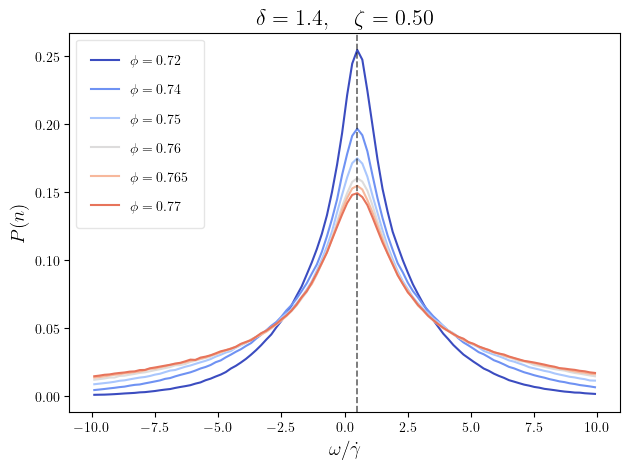

In [40]:
## angular velocity distribution normalised wrt the instantaneous shear rate

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

npp     = 1000
phi     = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar      = '1.4'
vr      = '0.5'
numRuns = 2
off     = 100

topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
#cmap          = plt.get_cmap("viridis",  len(phi))
cmap          = plt.get_cmap("coolwarm")

for i, phii in enumerate(phi):
    phir = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    angVelAll1 = []
    dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"
    if os.path.exists(dataname):
        for k in range(numRuns):
            par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
            dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
            if par_file:
                data     = np.loadtxt(dat_file)
                parList  = readFiles.readParFile(open(par_file))
                srate    = data[:, 2]
                
                for frame in range(off, len(parList)):
                    frameList = parList[frame]
                    angVely   = frameList[:, 8]/srate[frame] #nomalised
                    angVelAll1.extend(angVely)
                    
        angVelAll   = np.array(angVelAll1)
        hist, bins  = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, label = fr'$\phi = {phir}$', color = cmap(i / (7 - 1)))

plt.axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
plt.xlabel(r'$\omega/ \dot \gamma$', fontsize=14)
plt.ylabel(r'$P(n)$' , fontsize=14)
plt.title(fr'$\delta = {ar}, \quad \zeta = {float(vr):.2f}$', fontsize=16)
plt.legend(fontsize=10, loc='upper left', labelspacing=1.2, borderpad=1.1, framealpha=0.5, ncol=1)
#plt.grid(True, alpha=0.2)

plt.savefig(f'{fig_save_path}angVel_norm_ar{ar}_vr_{vr}.pdf', bbox_inches="tight", dpi=400)
plt.show()

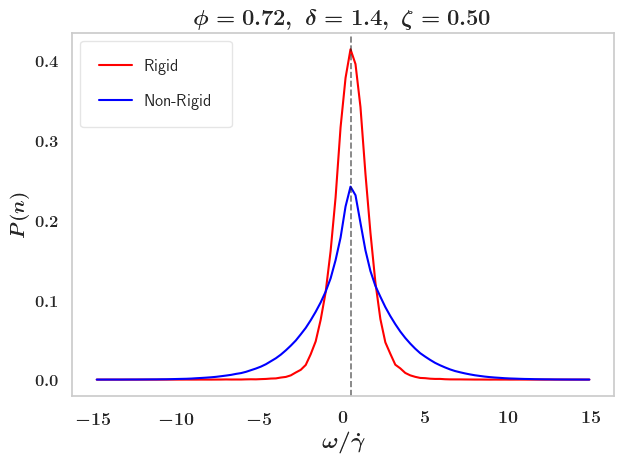

In [18]:
# angular velocity for rigid and non rigid particles
## angular velocity distribution normalised wrt the instantaneous shear rate

plt.rcParams["text.usetex"]         = True
#plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
#plt.rcParams["figure.autolayout"]   = True

npp     = 1000
phi     = 0.72
ar      = '1.4'
vr      = '0.5'
numRuns = 2
off     = 100
wRange  = 15 # range of angular velocity for histogram

particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
rigFile       = 'rig_*.dat'
cmap          = plt.get_cmap("coolwarm")
#cmap         = plt.get_cmap("viridis",  len(phi))

angVelAll1, angVelAll2 = [], []
phir     = f"{phi:.3f}" if phi != round(phi, 2) else f"{phi:.2f}"
dataname = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"

if os.path.exists(dataname):
    for k in range(numRuns):
        par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
        dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
        rig_file = glob.glob(f'{dataname}/run_{k+1}/{rigFile}')[0]
        
        if par_file and rig_file:
            data    = np.loadtxt(dat_file)
            parList = readFiles.readParFile(open(par_file))
            rigList = readFiles.rigList(open(rig_file))
            srate   = data[:, 2]
            
            for frame in range(off, len(parList)):
                frameList      = parList[frame]
                rigParts       = [i for sublist in rigList[frame] for i in sublist]
                nonRigParts    = list(set(np.arange(npp)) - set(rigParts))
                angVelyRig     = frameList[rigParts,    8]/srate[frame] #nomalised
                angVelyNonRig  = frameList[nonRigParts, 8]/srate[frame] #nomalised
                angVelAll1.extend(angVelyRig)
                angVelAll2.extend(angVelyNonRig)
                
    angVelAllRig    = np.array(angVelAll1)
    hist, bins      = np.histogram(angVelAllRig, bins=100, range=(-wRange, wRange), density=True)
    bin_centers     = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(bin_centers, hist, label = 'Rigid', color = 'red', linewidth=1.5)
   
    angVelAllNonRig = np.array(angVelAll2)
    hist, bins      = np.histogram(angVelAllNonRig, bins=100, range=(-wRange, wRange), density=True)
    bin_centers     = 0.5 * (bins[:-1] + bins[1:])
    plt.plot(bin_centers, hist, label = 'Non-Rigid', color = 'blue', linewidth=1.5)

plt.axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
#plt.axvline(x=0.0, color='k', linestyle='--', linewidth=1.2, alpha=0.6)

plt.xlabel(r'$\omega/ \dot \gamma$', fontsize=16, fontweight='bold')
plt.ylabel(r'$P(n)$', fontsize=14, fontweight='bold')
plt.title(fr'$\phi = {phi}, \; \delta = {ar}, \; \zeta = {float(vr):.2f}$', fontsize=16)
plt.legend(fontsize=12, loc='upper left', labelspacing=1.2, borderpad=1.1, framealpha=0.5, ncol=1)
plt.xticks(fontsize=13, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
#plt.grid(True, alpha=0.2)
plt.grid(False)

plt.savefig(f'{fig_save_path}/angVel_rigid_phi{phir}ar{ar}_vr_{vr}.pdf', bbox_inches="tight", dpi=400)
plt.show()

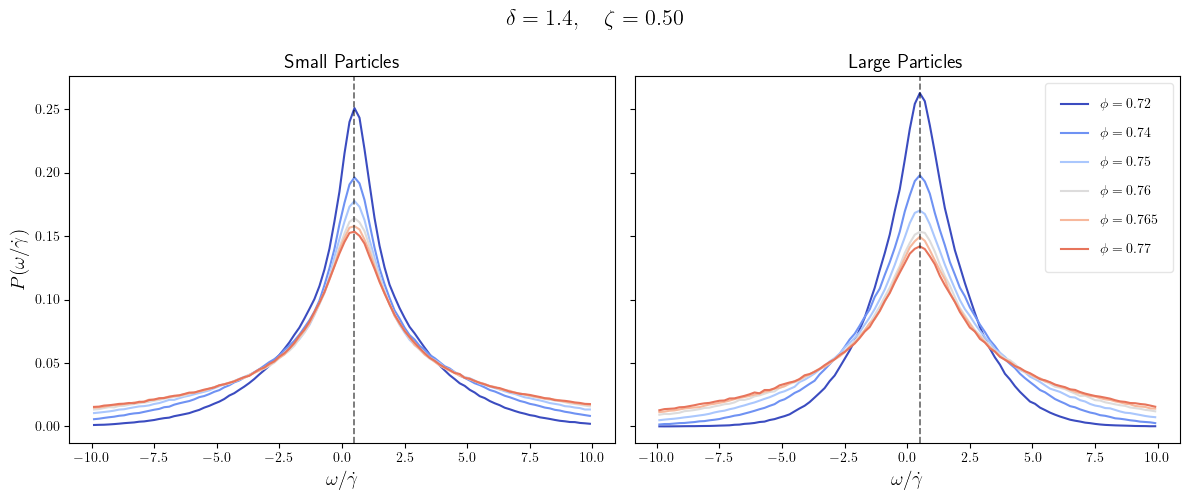

In [4]:
## angular velocity distribution normalized wrt the instantaneous shear rate
## with size

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import readFiles  # assuming this is your custom module

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

# Parameters
npp = 1000
phi = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar  = '1.4'
vr  = '0.5'
numRuns = 2
off     = 100

# Paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
cmap          = plt.get_cmap("coolwarm")

# Create figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.subplots_adjust(wspace=0.1)  # Adjust space between subplots

for i, phii in enumerate(phi):
    phir     = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"
    angVelAlls, angVelAlll = [], []
    if os.path.exists(dataname):
        for k in range(numRuns):
            try:
                par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
                dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
                
                data     = np.loadtxt(dat_file)
                parList  = readFiles.readParFile(open(par_file))
                srate    = data[:, 2]
                
                for frame in range(off, len(parList)):
                    frameList = parList[frame]
                    parSize   = np.array(frameList[:, 1])
                    smallPar  = np.where(parSize == 1)[0]  # indices of small particles
                    largePar  = np.where(parSize != 1)[0]  # indices of large particles
                    
                    # Normalized angular velocities
                    angVelyS = frameList[smallPar, 8]/srate[frame]
                    angVelyL = frameList[largePar, 8]/srate[frame]
                    angVelAlls.extend(angVelyS)
                    angVelAlll.extend(angVelyL)
                    
            except (IndexError, FileNotFoundError):
                continue
                
        # Plot for small particles
        if angVelAlls:
            angVelAll = np.array(angVelAlls)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[0].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(7 - 1)))
        
        # Plot for large particles
        if angVelAlll:
            angVelAll = np.array(angVelAlll)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[1].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(7 - 1)))

# Add vertical reference lines
ax[0].axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
ax[1].axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)

# Set labels and titles
ax[0].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=14)
ax[0].set_ylabel(r'$P(\omega/\dot{\gamma})$', fontsize=14)
ax[0].set_title('Small Particles', fontsize=14)

ax[1].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=14)
ax[1].set_title('Large Particles', fontsize=14)

# Main title
fig.suptitle(fr'$\delta = {ar}, \quad \zeta = {float(vr):.2f}$', fontsize=16, y=0.99)

# Add legend to the right of the right subplot
ax[1].legend(fontsize=10, loc='upper right', 
            labelspacing=1.2, borderpad=1.1, framealpha=0.5)

plt.tight_layout()
plt.savefig(f'{fig_save_path}angVel_snl_ar{ar}_vr_{vr}.svg', bbox_inches="tight", dpi=400)
plt.show()

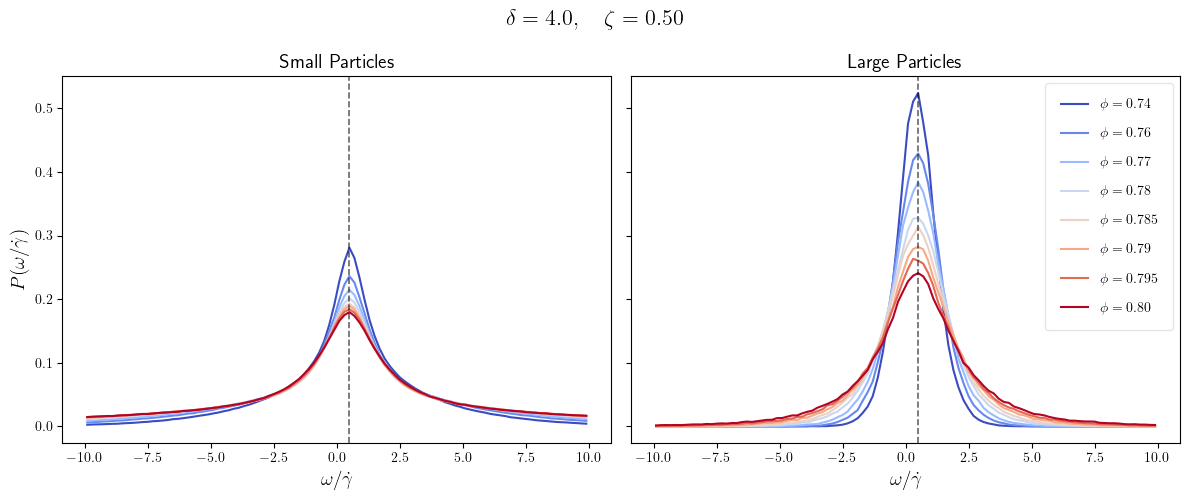

In [6]:
## angular velocity distribution normalized wrt the instantaneous shear rate
## with size

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import readFiles  # assuming this is your custom module

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

# Parameters
npp = 1000
phi = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar  = '4.0'
vr  = '0.5'
numRuns = 2
off     = 100

# Paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
cmap          = plt.get_cmap("coolwarm")
ii = -1
# Create figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.subplots_adjust(wspace=0.1)  # Adjust space between subplots

for i, phii in enumerate(phi):
    phir     = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"
    angVelAlls, angVelAlll = [], []
    if os.path.exists(dataname):
        for k in range(numRuns):
            try:
                par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
                dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
                
                data     = np.loadtxt(dat_file)
                parList  = readFiles.readParFile(open(par_file))
                srate    = data[:, 2]
                
                for frame in range(off, len(parList)):
                    frameList = parList[frame]
                    parSize   = np.array(frameList[:, 1])
                    smallPar  = np.where(parSize == 1)[0]  # indices of small particles
                    largePar  = np.where(parSize != 1)[0]  # indices of large particles
                    
                    # Normalized angular velocities
                    angVelyS = frameList[smallPar, 8]/srate[frame]
                    angVelyL = frameList[largePar, 8]/srate[frame]
                    angVelAlls.extend(angVelyS)
                    angVelAlll.extend(angVelyL)
                    
            except (IndexError, FileNotFoundError):
                continue
                
        # Plot for small particles
        if angVelAlls:
            ii += 1
            angVelAll = np.array(angVelAlls)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[0].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(ii/(8 - 1)))
        
        # Plot for large particles
        if angVelAlll:
            angVelAll = np.array(angVelAlll)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[1].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(ii/(8 - 1)))

# Add vertical reference lines
ax[0].axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
ax[1].axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)

# Set labels and titles
ax[0].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=14)
ax[0].set_ylabel(r'$P(\omega/\dot{\gamma})$', fontsize=14)
ax[0].set_title('Small Particles', fontsize=14)

ax[1].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=14)
ax[1].set_title('Large Particles', fontsize=14)

# Main title
fig.suptitle(fr'$\delta = {ar}, \quad \zeta = {float(vr):.2f}$', fontsize=16, y=0.99)

# Add legend to the right of the right subplot
ax[1].legend(fontsize=10, loc='upper right', 
             labelspacing=1.2, borderpad=1.1, framealpha=0.5)

plt.tight_layout()
plt.savefig(f'{fig_save_path}angVel_snl_ar{ar}_vr_{vr}.svg', bbox_inches="tight", dpi=400)
plt.show()

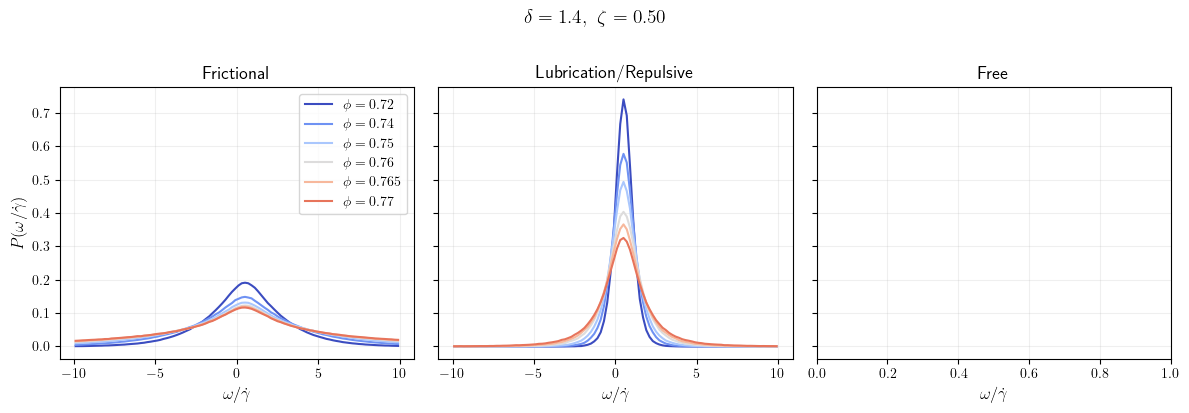

In [1]:
## angular velocity distribution normalized wrt the instantaneous shear rate
## with size

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import readFiles  # assuming this is your custom module

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

# Parameters
npp = 1000
phi = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar  = '1.4'
vr  = '0.5'
numRuns = 2
off     = 100

# Paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
intFile       = 'int_*.dat'
cmap          = plt.get_cmap("coolwarm")

allIndices = list(range(0, npp))

# Create figure with two subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
plt.subplots_adjust(wspace=0.1)  # Adjust space between subplots

for i, phii in enumerate(phi):
    phir     = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"
    angVelfrict, angVellub,  angVelfree= [], [], []
    
    if os.path.exists(dataname):
        for k in range(numRuns):
            try:
                par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
                dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
                intPath  = open(glob.glob(f'{dataname}/run_{k+1}/{intFile}')[0])

                data     = np.loadtxt(dat_file)
                parList  = readFiles.readParFile(open(par_file))
                intList  = readFiles.interactionsList(intPath)
                srate    = data[:, 2]

                #frictIndex, lubIndex, freeIndex = [], [], []
                
                for frame in range(off, len(parList)):
                    frameParList = parList[frame]
                    frameIntList = intList[frame]

                    contState = frameIntList[:, 10].astype(int)
                    particle1 = frameIntList[:, 0].astype(int)
                    particle2 = frameIntList[:, 1].astype(int)
                    
                    frictStateIndices = np.where(contState == 2)[0] # frictional
                    lubStateIndices   = np.where(contState == 0)[0] # lubrication & repulsion
                    lubParticles      = np.unique(np.concatenate([particle1[lubStateIndices]  , particle2[lubStateIndices]]))
                    
                    fricIndices = np.unique(np.concatenate([particle1[frictStateIndices], particle2[frictStateIndices]]))
                    lubIndices  = np.setdiff1d(lubParticles, fricIndices)
                    freeIndices = np.setdiff1d(np.arange(npp), np.union1d(fricIndices, lubParticles))
                    
                    # Normalized angular velocities
                    angVelyfric = frameParList[fricIndices, 8]/srate[frame]
                    angVelylub  = frameParList[lubIndices , 8]/srate[frame]
                    angVelyfree = frameParList[freeIndices, 8]/srate[frame]
                    
                    angVelfrict.extend(angVelyfric)
                    angVellub.extend(angVelylub)
                    angVelfree.extend(angVelyfree)
                    
            except (IndexError, FileNotFoundError):
                continue
                
        # Plot for small particles
        if len(angVelfrict) > 0:
            angVelAll = np.array(angVelfrict)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[0].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(7 - 1)))
        
        # Plot for large particles
        if len(angVellub) > 0:
            angVelAll = np.array(angVellub)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[1].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(7 - 1)))

        if len(angVelyfree) > 0:
            angVelAll = np.array(angVelyfree)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[2].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(7 - 1)))

for j, title in enumerate(['Frictional', 'Lubrication/Repulsive', 'Free']):
    ax[j].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=12)
    ax[j].set_title(title, fontsize=13)
    ax[j].grid(True, alpha=0.2)
    
ax[0].set_ylabel(r'$P(\omega/\dot{\gamma})$', fontsize=12)

# Add legend to the rightmost plot
ax[0].legend(fontsize=10, loc='upper right', framealpha=0.8, title_fontsize=10)

# Main title
fig.suptitle(fr'$\delta = {ar},\ \zeta = {float(vr):.2f}$',fontsize=14, y=1.02)

plt.tight_layout()
plt.savefig(f'{fig_save_path}angVel_contact_types_ar{ar}_vr_{vr}.svg', bbox_inches="tight", dpi=400)
plt.show()

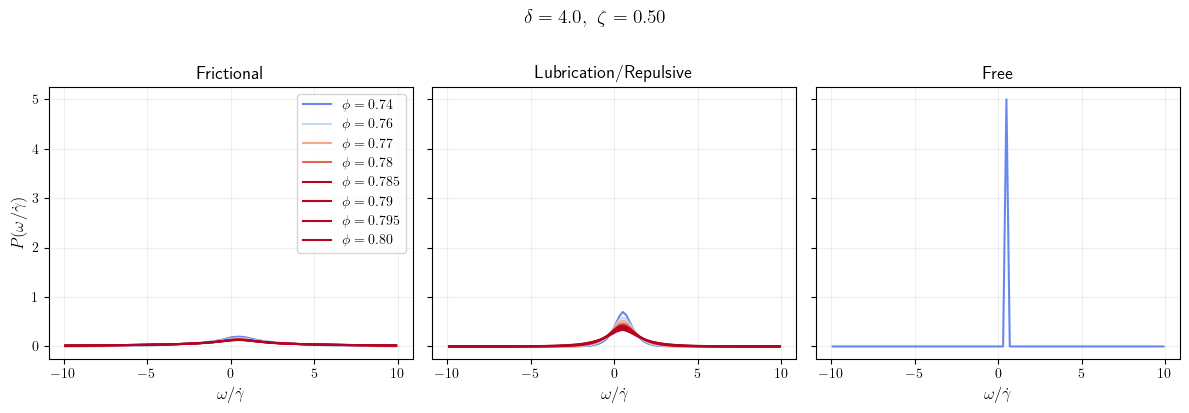

In [1]:
## angular velocity distribution normalized wrt the instantaneous shear rate
## with size

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import readFiles  # assuming this is your custom module

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

# Parameters
npp = 1000
phi = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar  = '4.0'
vr  = '0.5'
numRuns = 2
off     = 100

# Paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
intFile       = 'int_*.dat'
cmap          = plt.get_cmap("coolwarm")

allIndices = list(range(0, npp))

# Create figure with two subplots side by side
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
plt.subplots_adjust(wspace=0.1)  # Adjust space between subplots

for i, phii in enumerate(phi):
    phir     = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"
    angVelfrict, angVellub,  angVelfree= [], [], []
    
    if os.path.exists(dataname):
        for k in range(numRuns):
            try:
                par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
                dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
                intPath  = open(glob.glob(f'{dataname}/run_{k+1}/{intFile}')[0])

                data     = np.loadtxt(dat_file)
                parList  = readFiles.readParFile(open(par_file))
                intList  = readFiles.interactionsList(intPath)
                srate    = data[:, 2]

                #frictIndex, lubIndex, freeIndex = [], [], []
                
                for frame in range(off, len(parList)):
                    frameParList = parList[frame]
                    frameIntList = intList[frame]

                    contState = frameIntList[:, 10].astype(int)
                    particle1 = frameIntList[:, 0].astype(int)
                    particle2 = frameIntList[:, 1].astype(int)
                    
                    frictStateIndices = np.where(contState == 2)[0] # frictional
                    lubStateIndices   = np.where(contState == 0)[0] # lubrication & repulsion
                    lubParticles      = np.unique(np.concatenate([particle1[lubStateIndices]  , particle2[lubStateIndices]]))
                    
                    fricIndices = np.unique(np.concatenate([particle1[frictStateIndices], particle2[frictStateIndices]]))
                    lubIndices  = np.setdiff1d(lubParticles, fricIndices)
                    freeIndices = np.setdiff1d(np.arange(npp), np.union1d(fricIndices, lubParticles))
                    
                    # Normalized angular velocities
                    angVelyfric = frameParList[fricIndices, 8]/srate[frame]
                    angVelylub  = frameParList[lubIndices , 8]/srate[frame]
                    angVelyfree = frameParList[freeIndices, 8]/srate[frame]
                    
                    angVelfrict.extend(angVelyfric)
                    angVellub.extend(angVelylub)
                    angVelfree.extend(angVelyfree)
                    
            except (IndexError, FileNotFoundError):
                continue
                
        # Plot for small particles
        if len(angVelfrict) > 0:
            angVelAll = np.array(angVelfrict)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[0].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(8 - 1)))
        
        # Plot for large particles
        if len(angVellub) > 0:
            angVelAll = np.array(angVellub)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[1].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(8 - 1)))

        if len(angVelyfree) > 0:
            angVelAll = np.array(angVelyfree)
            hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[2].plot(bin_centers, hist, label=fr'$\phi = {phir}$', color = cmap(i/(8 - 1)))

for j, title in enumerate(['Frictional', 'Lubrication/Repulsive', 'Free']):
    ax[j].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=12)
    ax[j].set_title(title, fontsize=13)
    ax[j].grid(True, alpha=0.2)
    
ax[0].set_ylabel(r'$P(\omega/\dot{\gamma})$', fontsize=12)

# Add legend to the rightmost plot
ax[0].legend(fontsize=10, loc='upper right', framealpha=0.8, title_fontsize=10)

# Main title
fig.suptitle(fr'$\delta = {ar},\ \zeta = {float(vr):.2f}$',fontsize=14, y=1.02)

plt.tight_layout()
plt.savefig(f'{fig_save_path}angVel_contact_types_ar{ar}_vr_{vr}.svg', bbox_inches="tight", dpi=400)
plt.show()

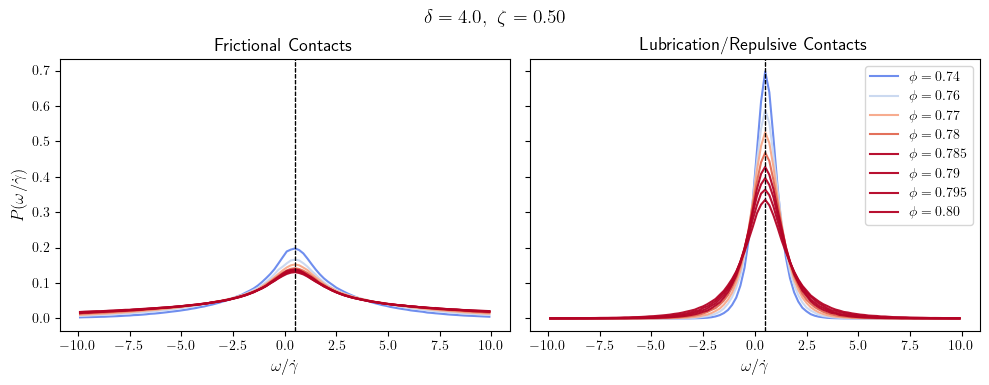

In [1]:
## angular velocity distribution normalized wrt the instantaneous shear rate
## with size (frictional and lubrication contacts only)

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import readFiles  # assuming this is your custom module

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

# Parameters
npp     = 1000
phi     = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar      = '4.0'
vr      = '0.5'
numRuns = 2
off     = 100

# Paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
intFile       = 'int_*.dat'
cmap          = plt.get_cmap("coolwarm")

# Create figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize = (10, 4), sharey=True)
plt.subplots_adjust(wspace = 0.15)  # Adjust space between subplots

for i, phii in enumerate(phi):
    phir     = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"
    angVelfrict, angVellub = [], []
    
    if os.path.exists(dataname):
        for k in range(numRuns):
            try:
                par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
                dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
                int_file = glob.glob(f'{dataname}/run_{k+1}/{intFile}')[0]

                data    = np.loadtxt(dat_file)
                parList = readFiles.readParFile(open(par_file))
                intList = readFiles.interactionsList(open(int_file))
                srate   = data[:, 2]

                for frame in range(off, len(parList)):
                    frameList    = parList[frame]
                    frameIntList = intList[frame]

                    # Contact analysis
                    contState = frameIntList[:, 10].astype(int)
                    particle1 = frameIntList[:, 0].astype(int)
                    particle2 = frameIntList[:, 1].astype(int)
                    
                    # Get particle indices for each contact type
                    frict_indices = np.where(contState == 2)[0]
                    lub_indices   = np.where(contState == 0)[0]
                    lubIndices    = np.unique(np.concatenate([particle1[lub_indices], particle2[lub_indices]]))
                    
                    frict_particles = np.unique(np.concatenate([particle1[frict_indices], particle2[frict_indices]]))
                    lub_particles   = np.setdiff1d(lubIndices, frict_particles)

                    # Get normalized angular velocities
                    if frict_particles.size > 0:
                        angVelfrict.extend(frameList[frict_particles, 8]/srate[frame])
                        
                    if lub_particles.size > 0:
                        angVellub.extend(frameList[lub_particles, 8]/srate[frame])
                    
            except (IndexError, FileNotFoundError) as e:
                print(f"Error processing {dataname}/run_{k+1}: {e}")
                continue
                
    # Plot histograms for each contact type
    for j, (angVel, title) in enumerate(zip([angVelfrict, angVellub], ['Frictional', 'Lubrication/Repulsive'])):
        if len(angVel) > 0:
            angVel = np.array(angVel)
            hist, bins = np.histogram(angVel, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            ax[j].plot(bin_centers, hist, label=fr'$\phi = {phir}$', 
                       color=cmap(i/(8-1)), alpha=0.95)
            ax[j].axvline(x=0.5, color='k', linestyle='--', linewidth=.8, alpha=0.4)

# Set common labels and titles
for j, title in enumerate(['Frictional Contacts', 'Lubrication/Repulsive Contacts']):
    ax[j].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=12)
    ax[j].set_title(title, fontsize=13)
    #ax[j].grid(True, alpha=0.2)
    
ax[0].set_ylabel(r'$P(\omega/\dot{\gamma})$', fontsize=12)

# Add legend to the right subplot
ax[1].legend(fontsize=10, loc='upper right', framealpha=0.8)

fig.suptitle(fr'$\delta = {ar},\ \zeta = {float(vr):.2f}$',fontsize=14, y=.95)

plt.tight_layout()
plt.savefig(f'{fig_save_path}angVel_2contact_types_ar{ar}_vr_{vr}.svg', bbox_inches="tight", dpi=400)
plt.show()

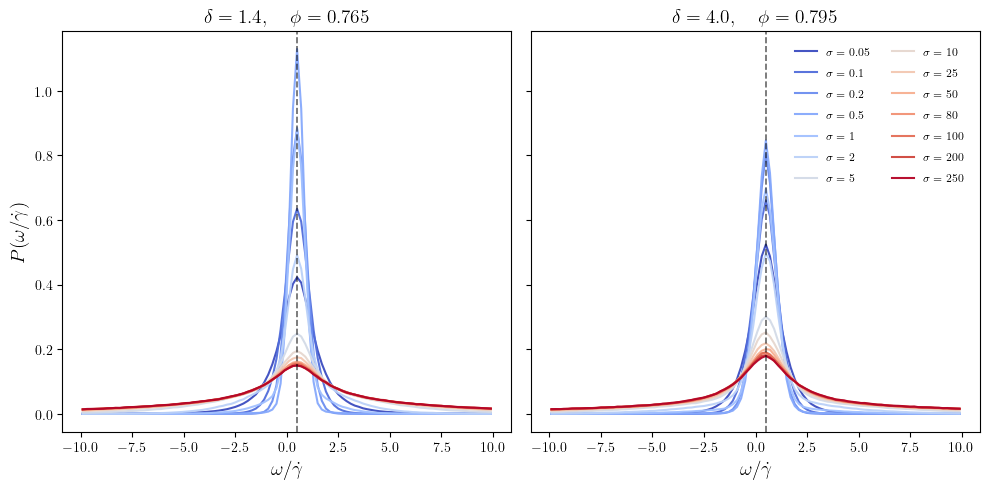

In [35]:
## angular velocity distribution normalized wrt the instantaneous shear rate
## for different stress values

import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import readFiles  # assuming this is your custom module

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"] = True

# Parameters
npp = 1000
stress = ['0.05','0.1','0.2', '0.5', '1', '2','5', '10', '25', '50', '80', '100', '200', '250']
stress_vals = [float(s) for s in stress]
vr = '0.5'

# phi and ar need to be of the same length
phi = [0.765, 0.795]
ar  = [1.4, 4.0]  # Different aspect ratios

numRun = 1
off = 50

# Paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/flow_curves/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile = 'data_*.dat'
cmap = plt.get_cmap("coolwarm")

# Create figure with two subplots side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
plt.subplots_adjust(wspace=0.1)  # Adjust space between subplots

for j, (arj, phij) in enumerate(zip(ar, phi)):
    angVelAll1 = []
    for s, stress_val in enumerate(stress):
        dataname = f'{topDir}stress_{stress[s]}r/NP_{npp}/phi_{phij}/ar_{arj}/Vr_{vr}/run_{numRun}'
        if os.path.exists(dataname):
            try:
                par_file = glob.glob(f'{dataname}/{particleFile}')[0]
                dat_file = glob.glob(f'{dataname}/{dataFile}')[0]
                if par_file:
                    data    = np.loadtxt(dat_file)
                    parList = readFiles.readParFile(open(par_file))
                    srate   = data[:, 2]
                    
                    angVelAll1 = []  # Reset for each stress value
                    for frame in range(off, len(parList)):
                        frameList = parList[frame]
                        angVely = frameList[:, 8]/srate[frame]  # normalized
                        angVelAll1.extend(angVely)
                    
                    # Plot for current stress value
                    if angVelAll1:
                        angVelAll = np.array(angVelAll1)
                        hist, bins = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
                        bin_centers = 0.5 * (bins[:-1] + bins[1:])
                        ax[j].plot(bin_centers, hist, label=fr'$\sigma = {stress[s]}$', 
                                   color=cmap(s / (len(stress) - 1)), alpha=0.95)
                        
            except (IndexError, FileNotFoundError) as e:
                print(f"Error processing {dataname}: {e}")
                continue
    
    # Subplot formatting
    ax[j].axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
    ax[j].set_xlabel(r'$\omega/\dot{\gamma}$', fontsize=14)
    ax[j].set_title(fr'$\delta = {arj}, \quad \phi = {phij}$', fontsize=14)
    #ax[j].grid(True, alpha=0.2)
    
ax[0].set_ylabel(r'$P(\omega/\dot{\gamma})$', fontsize=14)

# Add legend to the right subplot
ax[1].legend(fontsize=8, loc='upper right', labelspacing=1, borderpad=1, frameon=False, ncol=2)

#plt.suptitle(fr'Angular Velocity Distribution ($\zeta = {float(vr):.2f}$)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig(f'{fig_save_path}angVel_stress_comparison.pdf', bbox_inches="tight", dpi=400)
plt.show()

In [19]:
angVelyfree

array([], dtype=float64)

In [20]:
freeIndices

array([], dtype=int64)

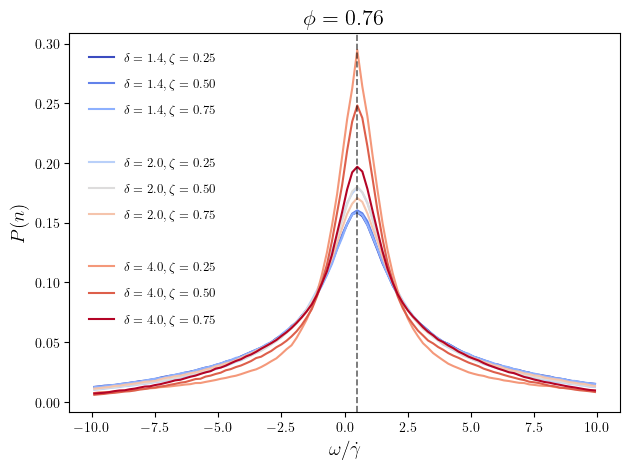

In [39]:
## angular velocity distribution normalised wrt the instantaneous shear rate
plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

npp     = 1000
phi     = '0.76'
ar      = [1.4, 2.0, 4.0] 
vr      = ['0.25', '0.5', '0.75']
numRuns = 2
off     = 100
cmax    = len(ar)*len(vr)

topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
#cmap          = plt.get_cmap("viridis",  len(phi))
cmap          = plt.get_cmap("coolwarm")

for i, ari in enumerate(ar):
    for j, vrj in enumerate(vr):
        angVelAll1 = []
        dataname   = f"{topDir}NP_{npp}/phi_{phi}/ar_{ari:.1f}/Vr_{vrj}"
        if os.path.exists(dataname):
            for k in range(numRuns):
                par_file = glob.glob(f'{dataname}/run_{k+1}/{particleFile}')[0]
                dat_file = glob.glob(f'{dataname}/run_{k+1}/{dataFile}')[0]
                if par_file:
                    parList = readFiles.readParFile(open(par_file))
                    data    = np.loadtxt(dat_file)
                    srate   = data[:, 2]
                    
                    for frame in range(off, len(parList)):
                        frameList = parList[frame]
                        angVely   = frameList[:, 8]/srate[frame] #nomalised
                        angVelAll1.extend(angVely)
                    
            angVelAll   = np.array(angVelAll1)
            hist, bins  = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            color_index = i * len(ar) + j
            plt.plot(bin_centers, hist, label = fr'$\delta = {ari:.1f}, \zeta = {float(vrj):.2f}$', color = cmap(color_index / (cmax - 1)))
    plt.plot([], [], ' ', label=" ")

plt.axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
plt.xlabel(r'$\omega/ \dot \gamma$', fontsize=14)
plt.ylabel(r'$P(n)$' , fontsize=14)
plt.title(fr'$\phi = {phi}$', fontsize=16)
plt.legend(fontsize=9, loc='upper left', labelspacing=1.2, borderpad=1.1, ncol=1, frameon=False)
#plt.grid(True, alpha=0.2)

plt.savefig(f'{fig_save_path}angVel_norm_phi{phi}.pdf', bbox_inches="tight", dpi=400)
plt.show()

In [10]:
data = np.loadtxt('/media/rahul/rahul_2TB/high_bidispersity/new_data/NP_1000/phi_0.77/ar_1.4/Vr_0.25/run_1/data_random_seed_params_stress100r_shear.dat')
srate = data[:,2]

In [16]:
np.where(srate < 0)[0]

array([1020])

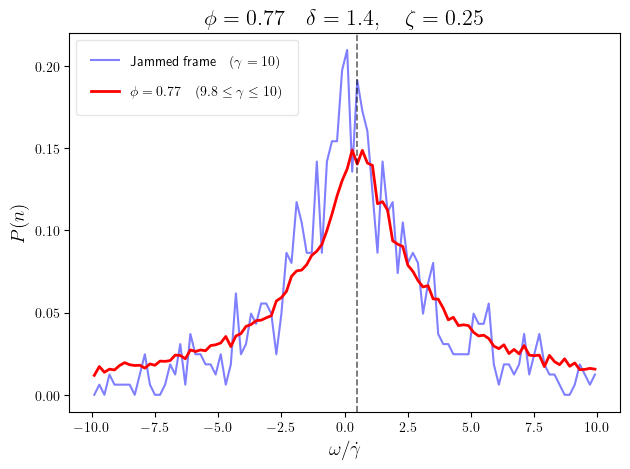

In [34]:
## angular velocity distribution near jamming

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

npp     = 1000
phi     = '0.77'
ar      = '1.4'
vr      = '0.25'
numRun  = 1
off     = 100

jamFrame   = 1020
startFrame = 980 #off

topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
#cmap          = plt.get_cmap("viridis",  len(phi))
cmap          = plt.get_cmap("coolwarm")

angVelAll1 = []
dataname   = f"{topDir}NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
if os.path.exists(dataname):
    par_file = glob.glob(f'{dataname}/{particleFile}')[0]
    dat_file = glob.glob(f'{dataname}/{dataFile}')[0]
    if par_file:
        data     = np.loadtxt(dat_file)
        parList  = readFiles.readParFile(open(par_file))
        srate    = data[:, 2]

        # jammed frame
        frameList   = parList[jamFrame]
        angVely     = frameList[:, 8]/srate[jamFrame]
        hist, bins  = np.histogram(angVely, bins=100, range=(-10, 10), density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, label=fr'$\text{{Jammed frame}} \quad (\gamma = {jamFrame/100:.0f})$', 
                 color='blue', alpha=0.5)

        # Upto jamming
        for frame in range(startFrame, jamFrame+1):
            frameList = parList[frame]
            angVely   = frameList[:, 8]/srate[frame] #nomalised
            angVelAll1.extend(angVely)
                    
        angVelAll   = np.array(angVelAll1)
        hist, bins  = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, label = fr'$\phi = {phi} \quad (9.8 \leq \gamma \leq {jamFrame/100:.0f})$', color = 'red', linewidth=2)

plt.axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
plt.xlabel(r'$\omega/ \dot \gamma$', fontsize=14)
plt.ylabel(r'$P(n)$' , fontsize=14)
plt.title(fr'$\phi = {phi} \quad \delta = {ar}, \quad \zeta = {float(vr):.2f}$', fontsize=16)
plt.legend(fontsize=10, loc='upper left', labelspacing=1.2, borderpad=1.1, framealpha=0.5, ncol=1)
#plt.grid(False, alpha=0.2)

plt.savefig(f'{fig_save_path}angVel_jamm2_phi{phi}_ar{ar}_vr_{vr}.pdf', bbox_inches="tight", dpi=400)
plt.show()

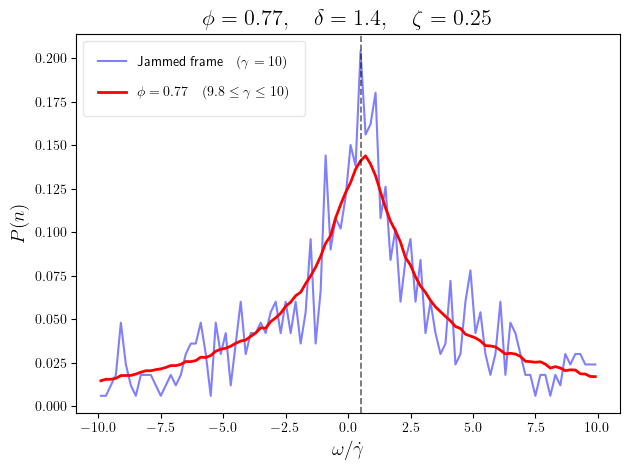

In [28]:
## angular velocity distribution near jamming

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

npp     = 1000
phi     = '0.77'
ar      = '1.4'
vr      = '0.25'
numRun  = 1
off     = 100

jamFrame   = 980+440
startFrame = 980 #off

#topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'
particleFile  = 'par_*.dat'
dataFile      = 'data_*.dat'
#cmap          = plt.get_cmap("viridis",  len(phi))
cmap          = plt.get_cmap("coolwarm")

angVelAll1 = []
dataname   = "/Users/rahul/Documents/simulations/bidisperse/NP_1000/phi_0.77/ar_1.4/Vr_0.25/run_till10"
if os.path.exists(dataname):
    par_file = glob.glob(f'{dataname}/{particleFile}')[0]
    dat_file = glob.glob(f'{dataname}/{dataFile}')[0]
    if par_file:
        data     = np.loadtxt(dat_file)
        parList  = readFiles.readParFile(open(par_file))
        srate    = data[:, 2]

        # jammed frame
        frameList   = parList[jamFrame]
        angVely     = frameList[:, 8]/srate[jamFrame]
        hist, bins  = np.histogram(angVely, bins=100, range=(-10, 10), density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, label=fr'$\text{{Jammed frame}} \quad (\gamma = 10)$', 
                 color='blue', alpha=0.5)

        # Upto jamming
        for frame in range(startFrame, jamFrame+1):
            frameList = parList[frame]
            angVely   = frameList[:, 8]/srate[frame] #nomalised
            angVelAll1.extend(angVely)
                    
        angVelAll   = np.array(angVelAll1)
        hist, bins  = np.histogram(angVelAll, bins=100, range=(-10, 10), density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, label = fr'$\phi = {phi} \quad (9.8 \leq \gamma \leq 10)$', color = 'red', linewidth=2)

plt.axvline(x=0.5, color='k', linestyle='--', linewidth=1.2, alpha=0.6)
plt.xlabel(r'$\omega/ \dot \gamma$', fontsize=14)
plt.ylabel(r'$P(n)$' , fontsize=14)
plt.title(fr'$\phi = {phi}, \quad \delta = {ar}, \quad \zeta = {float(vr):.2f}$', fontsize=16)
plt.legend(fontsize=10, loc='upper left', labelspacing=1.2, borderpad=1.1, framealpha=0.5, ncol=1)
#plt.grid(False, alpha=0.2)

plt.savefig(f'{fig_save_path}angVel_jamm3_phi{phi}_ar{ar}_vr_{vr}.pdf', bbox_inches="tight", dpi=400)
plt.show()

In [39]:
## rig snapshots with grain boudnary

import os
import sys
import glob
import matplotlib                       # type: ignore
import numpy             as     np      # type: ignore
import matplotlib.pyplot as     plt     # type: ignore
import readFiles

'''
Feb 3, 2025
RVP

This script produces snapshots with rigid clusters for a given range of strain units.
Snapshots are produced for all the phi and ar values mentioned.
NOTE: snapshots produced for just one run (run = 1)

Command to execute in terminal:
python3 makeRigSnapshots.py
'''

# mac paths
topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# linux paths
#topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
#fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters.
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRum = 1

# Particles data file.
parFile = 'par_*.dat'
rigFile = 'rig_*.dat'

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "text.usetex": True,
    "figure.autolayout": True,
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "font.size":        10,
    "xtick.labelsize":  10,
    "ytick.labelsize":  10,
    "patch.linewidth":  .2,
    "lines.markersize":  5,
    "hatch.linewidth":  .2
})
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.use('Agg')
cmap = plt.get_cmap('gist_rainbow') 

# Frame details
startFrame = 900
endFrame   = 1000

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = topDir + 'NP_' + str(npp) + '/phi_' + phii + '/ar_' + str(ar[k]) + '/Vr_' + vr[l]
            if os.path.exists(dataname):
                particleFile  = open(glob.glob(f'{dataname}/run_{numRum}/{parFile}')[0])
                parLines      = particleFile.readlines()
                particlesList = readFiles.readParFile(particleFile)
                
                rigFilePath   = glob.glob(f'{dataname}/run_{numRum}/{rigFile}')
                if not rigFilePath:
                    print(f"Error: {rigFile} not found at {dataname}/run_{numRum}")
                    sys.exit(1)
                rigidFile     = open(rigFilePath[0])
                rigClusterIDs = readFiles.rigList(rigidFile)
                clusterIDsAll = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in samplelist for num in sublist}) for samplelist in rigClusterIDs]
                
                clusterIDs = []
                for samplelist in rigClusterIDs:
                    if len(samplelist[0]) < 2:
                        clusterIDs.append([np.nan])
                    else:
                        clusterIDs.append(samplelist)

                # Box dimensions.
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                directory = f'{fig_save_path}phi_{phii}_ar_{ar[k]}_vr_{vr[l]}_rig2'
                os.makedirs(directory, exist_ok=True)
                
                for frame in range(startFrame, endFrame):
                    # Particle sizes and radii.
                    px = particlesList[frame][:,2]
                    pz = particlesList[frame][:,3]
                    pr = particlesList[frame][:,1]

                    # Setting up axis and box walls.
                    fig, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                    newLx   = Lx + 2*np.max(pr)
                    newLz   = Lz + 2*np.max(pr)

                    allPart      = particlesList[frame][:,0]
                    rigidPart    = clusterIDsAll[frame]
                    notRigidPart = allPart[np.isin(allPart, rigidPart) == False]

                    ax.clear()
                    for index in notRigidPart:
                        index  = int(index)
                        circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='w', edgecolor='k', linewidth=0.5, zorder=1)
                        ax.add_artist(circle)
                    
                    numClusters = len(clusterIDs[frame])  # Example: number of variables
                    colors      = [cmap(i/numClusters) for i in range(numClusters)]
                    
                    for ii, rigSubList in enumerate(clusterIDs[frame]):
                        if rigSubList:
                            for index in set(rigSubList):
                                circle = plt.Circle((px[index],pz[index]), pr[index], facecolor = colors[ii], edgecolor=None, zorder=2)
                                ax.add_artist(circle)

                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    ax.axis('off')
                    ax.set_aspect('equal')
                    ax.set_title(fr'$\phi = {phii}, \;\delta = {ar[k]}, \; \zeta = {float(vr[l]):.2f},\; \gamma = {frame/100:.2f}$', 
                                 fontsize=7, pad=6, fontweight='bold', x=0.5)
                    fig.savefig(f'{directory}/{frame}.png', dpi=400)
                    print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    plt.close(fig)
            else:
                print(f"{dataname} - Not Found")

>     Processed frame: 900/999      
>     Processed frame: 901/999      
>     Processed frame: 902/999      
>     Processed frame: 903/999      
>     Processed frame: 904/999      
>     Processed frame: 905/999      
>     Processed frame: 906/999      
>     Processed frame: 907/999      
>     Processed frame: 908/999      
>     Processed frame: 909/999      
>     Processed frame: 910/999      
>     Processed frame: 911/999      
>     Processed frame: 912/999      
>     Processed frame: 913/999      
>     Processed frame: 914/999      
>     Processed frame: 915/999      
>     Processed frame: 916/999      
>     Processed frame: 917/999      
>     Processed frame: 918/999      
>     Processed frame: 919/999      
>     Processed frame: 920/999      
>     Processed frame: 921/999      
>     Processed frame: 922/999      
>     Processed frame: 923/999      
>     Processed frame: 924/999      
>     Processed frame: 925/999      
>     Processed frame: 926/999      
>

In [6]:
clusterIDs = []  # final output list

for samplelist in rigClusterIDs:
    # Case 1: if the first sublist has less than 2 elements
    if len(samplelist[0]) < 2:
        clusterIDs.append([np.nan])
    else:
        clusterIDs.append(samplelist)

#clusterIDs.append(list(unique_ids))

In [3]:
# angular velocity system snapshots
# liner colormap scale with arrow

import os
import glob
import matplotlib               # type: ignore
import numpy as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors
import readFiles
import gc


# mac paths
#topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
#fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# linux paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"] = True

# Frame details
startFrame = 926
endFrame   = 1000

for i, phii in enumerate(phi):
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for j, arj in enumerate(ar):
        for k, vrk in enumerate(vr):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{arj}/Vr_{vrk}/run_{numRun}"
            if os.path.exists(dataname):
                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                parList  = readFiles.readParFile(parPath)

                # Box size & colormap
                Lx, Lz       = float(parLines[3].split()[2]), float(parLines[3].split()[2])
                newLx, newLz = Lx + 2*arj, Lz + 2*arj
                minAngVelres = -0.5
                maxAngVelres =  0.5
                colorNorm    = mcolors.Normalize(vmin=minAngVelres, vmax=maxAngVelres)
                    
                for frame in range(startFrame, endFrame):
                    #frame = 1500
                    frameList = parList[frame]
    
                    pIndex  = frameList[:,0]
                    pr      = frameList[:,1]
                    px      = frameList[:,2]
                    pz      = frameList[:,3]
                    velx    = frameList[:,4]
                    velz    = frameList[:,6]
                    angVely = frameList[:,8]
    
                    # Plot params
                    colors  = plt.cm.coolwarm(colorNorm(angVely))
                    fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)
    
                    # plotting all particles 
                    for i in range(npp):
                        circle = plt.Circle((px[i],pz[i]), pr[i], facecolor=colors[i], fill=True, edgecolor='none')
                        ax.add_artist(circle)
                        #ax.arrow(px[i], pz[i], velx[i], velz[i], head_width=0.05, head_length=0.05, fc='k', ec='k') 
                        ax.quiver(px[i], pz[i], velx[i], velz[i], angles='xy', scale_units='xy', scale=.6, 
                                  color    = 'k',  width      = 0.0018,                    # Makes arrow shaft very thin
                                  headwidth = 3,   headlength = 3,      headaxislength=2,  # Makes arrowhead smaller
                                  linewidth = 0.1, zorder     = 10)
    
                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    ax.set_title(fr'$\phi = {phii}, \;\delta = {arj}, \; \zeta = {float(vrk):.2f},\; \gamma = {frame/100:.2f}$', 
                                 fontsize=7, pad=6, fontweight='bold', x=0.5)
                    ax.axis('off')
                    ax.set_aspect('equal')
    
                    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=colorNorm)  # Using 'RdYlBu' colormap
                    sm.set_array([])
                    cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.02, shrink=1.0, aspect=30)
                    cbar.set_label(r"$\omega$", fontsize=5, labelpad=-2)
                    cbar.outline.set_linewidth(0.4)
                    cbar.set_ticks(np.linspace(-0.5, 0.5, 7))
                    cbar.set_ticklabels([r'$-0.5$', r'$-0.3$', r'$-0.1$', r'$0$', r'$0.1$', r'$0.3$', r'$0.5$'])
                    cbar.ax.tick_params(labelsize=5, width=0.4)
                    fig.tight_layout()
    
                    directory = f'{fig_save_path}phi_{phii}_ar_{arj}_vr_{vrk}_angV_transV'
                    os.makedirs(directory, exist_ok=True)
                    #fig.savefig(f'{fig_save_path}/{frame}.svg', dpi=400, bbox_inches="tight")
                    fig.savefig(f'{directory}/{frame}.png', dpi=400, bbox_inches="tight")
                    print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    plt.close()
                    gc.collect()
    
                    #plt.show()

>     Processed frame: 926/999      
>     Processed frame: 927/999      
>     Processed frame: 928/999      
>     Processed frame: 929/999      
>     Processed frame: 930/999      
>     Processed frame: 931/999      
>     Processed frame: 932/999      
>     Processed frame: 933/999      
>     Processed frame: 934/999      
>     Processed frame: 935/999      
>     Processed frame: 936/999      
>     Processed frame: 937/999      
>     Processed frame: 938/999      
>     Processed frame: 939/999      
>     Processed frame: 940/999      
>     Processed frame: 941/999      
>     Processed frame: 942/999      
>     Processed frame: 943/999      
>     Processed frame: 944/999      
>     Processed frame: 945/999      
>     Processed frame: 946/999      
>     Processed frame: 947/999      
>     Processed frame: 948/999      
>     Processed frame: 949/999      
>     Processed frame: 950/999      
>     Processed frame: 951/999      
>     Processed frame: 952/999      
>

In [9]:
# angular velocity system snapshots
# liner colormap scale with arrow
# normalised wrt shear rate

import os
import glob
import matplotlib               # type: ignore
import numpy as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors
import readFiles
import gc


# mac paths
topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# linux paths
#topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
#fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 
dataFile        = 'data_*.dat'

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"] = True

# Frame details
startFrame = 600
endFrame   = 1000

for i, phii in enumerate(phi):
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for j, arj in enumerate(ar):
        for k, vrk in enumerate(vr):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{arj}/Vr_{vrk}/run_{numRun}"
            if os.path.exists(dataname):
                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                dat_file = glob.glob(f'{dataname}/{dataFile}')[0]
                
                parLines = parPath.readlines()
                parList  = readFiles.readParFile(parPath)
                data     = np.loadtxt(dat_file)
                srate    = data[:, 2]

                # Box size & colormap
                Lx, Lz       = float(parLines[3].split()[2]), float(parLines[3].split()[2])
                newLx, newLz = Lx + 2*arj, Lz + 2*arj
                minAngVelres = -0.5
                maxAngVelres =  0.5
                colorNorm    = mcolors.Normalize(vmin=minAngVelres, vmax=maxAngVelres)
                    
                for frame in tqdm(range(startFrame, endFrame), desc='Processing frames'):
                    #frame = 1500
                    frameList = parList[frame]
    
                    pIndex  = frameList[:,0]
                    pr      = frameList[:,1]
                    px      = frameList[:,2]
                    pz      = frameList[:,3]
                    velx    = frameList[:,4]
                    velz    = frameList[:,6]
                    angVely = frameList[:,8]
                    
                    angVelyNorm = angVely/srate[frame]
                    colorNorm   = mcolors.Normalize(vmin=-20, vmax=20)
                    colors      = plt.cm.coolwarm(colorNorm(angVelyNorm))
                    
                    fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)
    
                    # plotting all particles 
                    for i in range(npp):
                        circle = plt.Circle((px[i],pz[i]), pr[i], facecolor=colors[i], fill=True, edgecolor='none')
                        ax.add_artist(circle)
                        #ax.arrow(px[i], pz[i], velx[i], velz[i], head_width=0.05, head_length=0.05, fc='k', ec='k') 
                        ax.quiver(px[i], pz[i], velx[i], velz[i], angles='xy', scale_units='xy', scale=.6, 
                                  color    = 'k',  width      = 0.0018,                    # Makes arrow shaft very thin
                                  headwidth = 3,   headlength = 3,      headaxislength=2,  # Makes arrowhead smaller
                                  linewidth = 0.1, zorder     = 10)
    
                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    ax.set_title(fr'$\phi = {phii}, \;\delta = {arj}, \; \zeta = {float(vrk):.2f},\; \gamma = {frame/100:.2f}$', 
                                 fontsize=7, pad=6, fontweight='bold', x=0.5)
                    ax.axis('off')
                    ax.set_aspect('equal')
    
                    sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=colorNorm)  # Using 'RdYlBu' colormap
                    sm.set_array([])
                    cbar = plt.colorbar(sm, ax=ax, fraction=0.02, pad=0.02, shrink=1.0, aspect=30)
                    cbar.set_label(r"$\omega/ \dot \gamma$", fontsize=5, labelpad=-2)
                    cbar.outline.set_linewidth(0.4)
                    #cbar.set_ticks(np.linspace(-0.5, 0.5, 7))
                    #cbar.set_ticklabels([r'$-0.5$', r'$-0.3$', r'$-0.1$', r'$0$', r'$0.1$', r'$0.3$', r'$0.5$'])
                    cbar.ax.tick_params(labelsize=5, width=0.4)
                    fig.tight_layout()
    
                    directory = f'{fig_save_path}phi_{phii}_ar_{arj}_vr_{vrk}_angV_transV2'
                    os.makedirs(directory, exist_ok=True)
                    #fig.savefig(f'{fig_save_path}/{frame}.svg', dpi=400, bbox_inches="tight")
                    fig.savefig(f'{directory}/{frame}.png', dpi=500, bbox_inches="tight")
                    print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    plt.close()
                    gc.collect()
    
                    #plt.show()

>     Processed frame: 714/717      
>     Processed frame: 715/717      
>     Processed frame: 716/717      
>     Processed frame: 717/717      


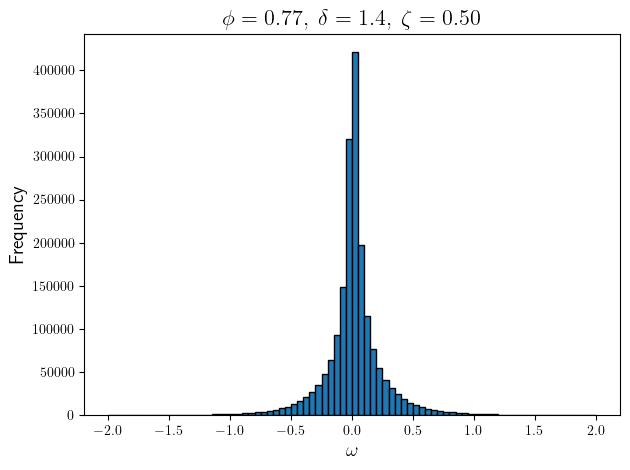

In [27]:
## angular velocity histogram #angvelhist

import matplotlib.pyplot as plt
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

npp    = 1000
phi    = '0.77'
ar     = '1.4'
vr     = '0.5'
numRun = 1
off    = 100

# Particles data file
particleFile    = 'par_*.dat'

plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

angVelAll = []
dataname = f"{topDir}NP_{npp}/phi_{phi}/ar_{ar}/Vr_{vr}/run_{numRun}"
if os.path.exists(dataname):
    parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
    parLines = parPath.readlines()
    parList  = readFiles.readParFile(parPath)
    
    for frame in range(off,len(parList)):
        frameList = parList[frame]
        angVely   = frameList[:,8]
        angVelAll.append(angVely)
else:
    print(f'Path DNE - {dataname}')

angVelFlat = [i for sublist in angVelAll for i in sublist]
plt.hist(angVelFlat, bins=80, edgecolor="black", range=(-2, 2))
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel(r'Frequency', fontsize=14)
#plt.yscale('log')
plt.title(fr'$\phi = {phi}, \;\delta = {ar}, \; \zeta = {float(vr):.2f}$', fontsize=16)
plt.savefig(f'{fig_save_path}phi_{phi}_ar_{ar}_vr_{vr}_hist_angV.svg', dpi=400)                
plt.show()

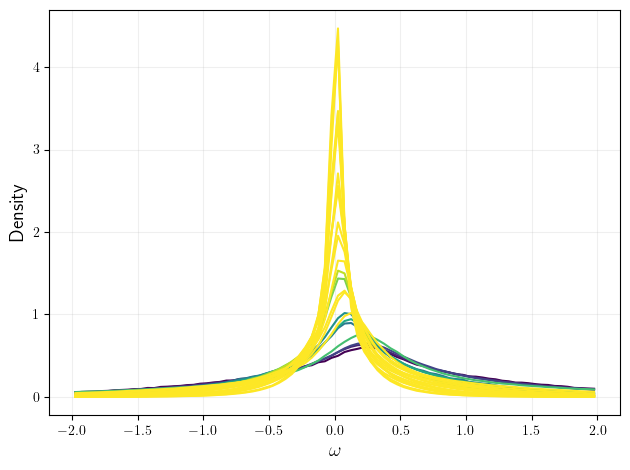

In [36]:
## angular velocity distribution normalised wrt the instantaneous shear rate

fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

npp     = 1000
phi     = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar      = [1.0, 1.4, 2.0, 4.0] 
vr      = '0.5'
numRuns = 2
off     = 100

topDir       = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
particleFile = 'par_*.dat'
dataFile     = 'data_*.dat'

# Plot setup
plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

cmap = plt.get_cmap("viridis", len(phi))  # Viridis colormap

for i, phii in enumerate(phi):
    phir = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    for j, arj in enumerate(ar):
        angVelAll1 = []
        for k in range(numRuns):
            dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{arj:.1f}/Vr_{vr}/run_{k+1}"
            if os.path.exists(dataname):
                par_files = glob.glob(f'{dataname}/{particleFile}')
                if par_files:
                    with open(par_files[0]) as parPath:
                        parList = readFiles.readParFile(parPath)
                        
                    for frame in range(off, len(parList)):
                        frameList = parList[frame]
                        angVely   = frameList[:, 8]
                        angVelAll1.extend(angVely)
                    
        color_index = i * len(ar) + j
        angVelAll   = np.array(angVelAll1)
        hist, bins  = np.histogram(angVelAll, bins=80, range=(-2, 2), density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, label = fr'$\phi = {phir}, \delta = {arj:.2f}$', color = cmap(color_index))

# Final plot setup
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.title(fr'$\delta = {arj:.1f}, \zeta = {float(vr):.2f}$', fontsize=16)
#plt.legend(fontsize=10, loc='upper right', labelspacing=0.5, borderpad=0.5)
plt.grid(True, alpha=0.2)

#plt.savefig(f'{fig_save_path}angVel_density_phiScan_ar_{ar}_vr_{vr}.svg', dpi=400)
plt.show()

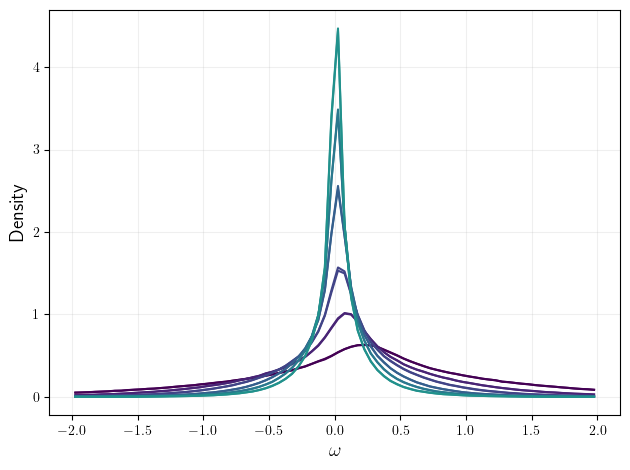

In [38]:
## angular velocity distribution normalised wrt the instantaneous shear rate

fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

npp     = 1000
phi     = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77, 0.78, 0.785, 0.79, 0.795, 0.8]
ar      = '1.4'
vr      = '0.5'
numRuns = 2
off     = 100

topDir       = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
particleFile = 'par_*.dat'
dataFile     = 'data_*.dat'

# Plot setup
plt.rcParams["text.usetex"]         = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"]   = True

cmap = plt.get_cmap("viridis", len(phi))  # Viridis colormap

for i, phii in enumerate(phi):
    phir = f"{phii:.3f}" if phii != round(phii, 2) else f"{phii:.2f}"
    angVelAll1 = []
    for k in range(numRuns):
        dataname = f"{topDir}NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{k+1}"
        if os.path.exists(dataname):
            par_files = glob.glob(f'{dataname}/{particleFile}')
            if par_files:
                with open(par_files[0]) as parPath:
                    parList = readFiles.readParFile(parPath)
                    
                for frame in range(off, len(parList)):
                    frameList = parList[frame]
                    angVely   = frameList[:, 8]
                    angVelAll1.extend(angVely)
                    
        angVelAll   = np.array(angVelAll1)
        hist, bins  = np.histogram(angVelAll, bins=80, range=(-2, 2), density=True)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        plt.plot(bin_centers, hist, label = fr'$\phi = {phir}, \delta = {arj:.2f}$', color = cmap(i))

# Final plot setup
plt.xlabel(r'$\omega$', fontsize=14)
plt.ylabel('Density', fontsize=14)
#plt.title(fr'$\delta = {arj:.1f}, \zeta = {float(vr):.2f}$', fontsize=16)
plt.legend(fontsize=6, loc='upper right', labelspacing=0.5, borderpad=0.5)
plt.grid(True, alpha=0.2)

#plt.savefig(f'{fig_save_path}angVel_density_phiScan_ar_{ar}_vr_{vr}.svg', dpi=400)
plt.show()

In [68]:
for i, ari in enumerate(ar):
    for j, vrj in enumerate(vr):
        color_index = i * len(ar) + j
        print(color_index)

0
1
2
3
4
5
6
7
8


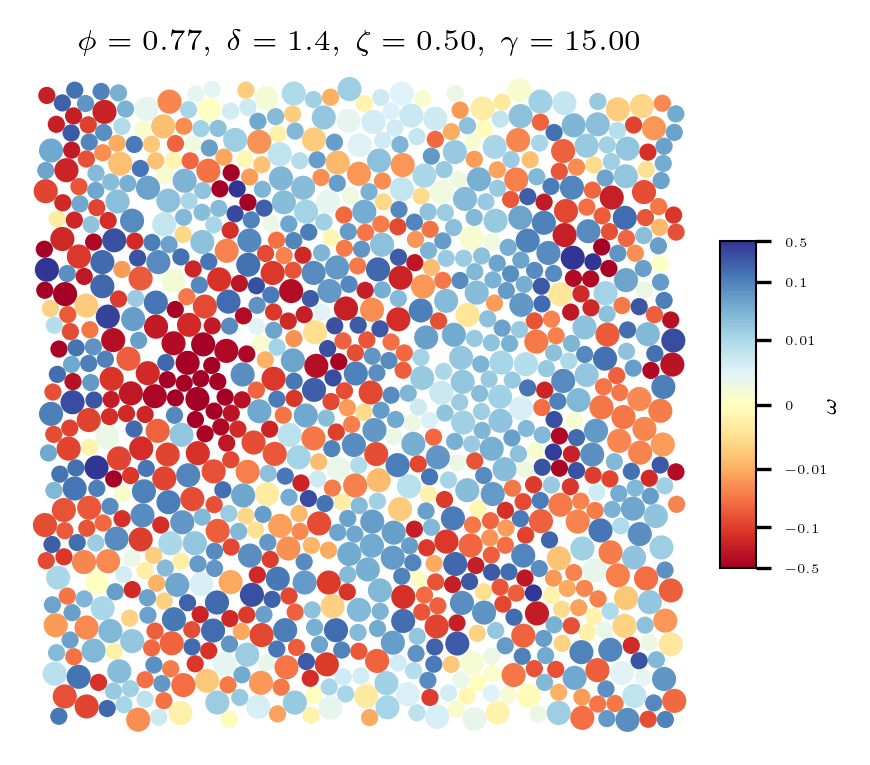

In [8]:
# colormap log scale

import os
import glob
import matplotlib               # type: ignore
import numpy             as np  # type: ignore
import matplotlib.pyplot as plt # type: ignore
import matplotlib.colors as mcolors
import readFiles

'''
Feb 5, 2025
RVP

This script produces snapshots of normal force interactions for a given range of strain units.
NOTE: Script creates a directory to store snapshots if it does not exist already
'''

# mac paths
#topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
#fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# linux paths
topDir        = '/media/rahul/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

# Simulation parameters
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRun = 1

# Particles data file
particleFile    = 'par_*.dat' 
interactionFile = 'int_*.dat' 

plt.rcParams["text.usetex"] = True
plt.rcParams["text.latex.preamble"] = r"\usepackage{amsmath}"  
plt.rcParams["figure.autolayout"] = True

# Frame details
startFrame = 600
endFrame   = 1000

cmap= 'RdYlBu'

for i, phii in enumerate(phi):
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for j, arj in enumerate(ar):
        for k, vrk in enumerate(vr):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{arj}/Vr_{vrk}/run_{numRun}"
            if os.path.exists(dataname):
                parPath  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines = parPath.readlines()
                parList  = readFiles.readParFile(parPath)

                # box dimensions
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                # setting up axis and box walls
                #_, ax = plt.subplots(1, 1, figsize=(5,5), dpi = 500)
                newLx = Lx + 2*arj
                newLz = Lz + 2*arj
                
                #for frame in range(startFrame, endFrame):
                frame = 1500
                frameList = parList[frame]

                pIndex  = frameList[:,0]
                pr      = frameList[:,1]
                px      = frameList[:,2]
                pz      = frameList[:,3]
                velx    = frameList[:,4]
                velz    = frameList[:,6]
                angVely = frameList[:,8]

                minAngVelres = -.5
                maxAngVelres = .5
                colorNorm = mcolors.SymLogNorm(linthresh=.01, vmin=minAngVelres, vmax=maxAngVelres, base=10)
                colors    = plt.cm.RdYlBu(colorNorm(angVely))

                fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi=300)

                # plotting all particles 
                for i in range(npp):
                    circle = plt.Circle((px[i],pz[i]), pr[i], facecolor=colors[i], fill=True, edgecolor='none')
                    ax.add_artist(circle)
                    #ax.text(px[i], pz[i], f'{density[i]:.2f}', ha='center', va='center', fontsize=8, color='black')

                ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                ax.set_title(fr'$\phi = {phii}, \;\delta = {arj}, \; \zeta = {float(vrk):.2f},\; \gamma = {frame/100:.2f}$', 
                             fontsize=7, pad=6, fontweight='bold')
                ax.axis('off')
                ax.set_aspect('equal')

                sm = plt.cm.ScalarMappable(cmap="RdYlBu", norm=colorNorm)
                sm.set_array([])  
                cbar = plt.colorbar(sm, ax=ax, fraction=0.05, pad=0.04, shrink=0.5, aspect=9)
                cbar.set_label(r"$\omega$", fontsize=5, labelpad=-2)
                cbar.ax.tick_params(labelsize=3)
                cbar.outline.set_linewidth(0.5)
                cbar.set_ticks([-0.5, -0.1, -0.01, 0, 0.01, 0.1, 0.5])
                cbar.set_ticklabels([r'$-0.5$', r'$-0.1$', r'$-0.01$', r'$0$', r'$0.01$', r'$0.1$', r'$0.5$'])

                fig.tight_layout()

#                 directory = f'{fig_save_path}phi_{phii}_ar_{arj}_vr_{vrk}_angV'
#                 os.makedirs(directory, exist_ok=True)
#                 fig.savefig(f'{directory}/{frame}.png', dpi=400)
#                 print(f'>     Processed frame: {frame}/{endFrame-1}      ')
#                 plt.close()

                plt.show()

In [65]:
## Rigid cluster snapshots

# Input and output paths

topDir        = '/Volumes/rahul_2TB/high_bidispersity/new_data/'
fig_save_path = '/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/'

# Path errors.
print(f"Error: Path '{topDir}' not found. Check mount point") if not os.path.exists(topDir) else None
print(f"Error: Path '{fig_save_path}' not found. Check mount point") if not os.path.exists(fig_save_path) else None

particleFile  = 'par_*.dat' 
rigFile       = 'rig_*.dat'

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phi[j]) if len(str(phi[j]).split('.')[1]) > 2 else '{:.2f}'.format(phi[j])
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = f"{topDir}NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}/run_{numRun}"
            if os.path.exists(dataname):
                particleFile  = open(glob.glob(f'{dataname}/{particleFile}')[0])
                parLines      = particleFile.readlines()
                particlesList = readFiles.readParFile(particleFile)
                
                rigFilePath   = glob.glob(f'{dataname}/{rigFile}')
                if not rigFilePath:
                    print(f"Error: {rigFile} not found at {dataname}")
                    sys.exit(1)
                rigidFile     = open(rigFilePath[0])
                rigClusterIDs = readFiles.rigList(rigidFile)
                clusterIDs    = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in samplelist for num in sublist}) for samplelist in rigClusterIDs]

                # Box dimensions.
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                for frame in range(startFrame, endFrame):
                    # Particle sizes and radii.
                    #frame = 1500
                    px = particlesList[frame][:,2]
                    pz = particlesList[frame][:,3]
                    pr = particlesList[frame][:,1]

                    # Setting up axis and box walls.
                    fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi = 300)
                    newLx   = Lx + 2*np.max(pr)
                    newLz   = Lz + 2*np.max(pr)

                    allPart      = particlesList[frame][:,0]
                    rigidPart    = clusterIDs[frame]
                    notRigidPart = allPart[np.isin(allPart, rigidPart) == False]

                    ax.clear()
                    for index in notRigidPart:
                        index  = int(index)
                        circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='w', edgecolor='k', linewidth=0.3, zorder=1)
                        ax.add_artist(circle)

                    for index in rigidPart:
                        circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='#A00000', edgecolor=None, zorder=2)
                        ax.add_artist(circle)

                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    ax.axis('off')
                    ax.set_aspect('equal')
                    #ax.set_title(rf"$\boldsymbol{{\gamma}} = \mathbf{{{frame/100:.2f}}}$", fontsize=16, pad=8, color=tColor)
                    ax.set_title(fr'$\phi = {phii}, \;\delta = {ar[k]}, \; \zeta = {float(vr[l]):.2f},\; \gamma = {frame/100:.2f}$', fontsize=7, pad=6, fontweight='bold')

                    #Saving figure
                    directory = f'{fig_save_path}phi_{phii}_ar_{ar[k]}_vr_{vr[l]}_rig'
                    os.makedirs(directory, exist_ok=True)
                    fig.savefig(f'{directory}/{frame}.png', dpi=400)
                    print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    plt.close()

>     Processed frame: 600/999      
>     Processed frame: 601/999      
>     Processed frame: 602/999      
>     Processed frame: 603/999      
>     Processed frame: 604/999      
>     Processed frame: 605/999      
>     Processed frame: 606/999      
>     Processed frame: 607/999      
>     Processed frame: 608/999      
>     Processed frame: 609/999      
>     Processed frame: 610/999      
>     Processed frame: 611/999      
>     Processed frame: 612/999      
>     Processed frame: 613/999      
>     Processed frame: 614/999      
>     Processed frame: 615/999      
>     Processed frame: 616/999      
>     Processed frame: 617/999      
>     Processed frame: 618/999      
>     Processed frame: 619/999      
>     Processed frame: 620/999      
>     Processed frame: 621/999      
>     Processed frame: 622/999      
>     Processed frame: 623/999      
>     Processed frame: 624/999      
>     Processed frame: 625/999      
>     Processed frame: 626/999      
>

>     Processed frame: 822/999      
>     Processed frame: 823/999      
>     Processed frame: 824/999      
>     Processed frame: 825/999      
>     Processed frame: 826/999      
>     Processed frame: 827/999      
>     Processed frame: 828/999      
>     Processed frame: 829/999      
>     Processed frame: 830/999      
>     Processed frame: 831/999      
>     Processed frame: 832/999      
>     Processed frame: 833/999      
>     Processed frame: 834/999      
>     Processed frame: 835/999      
>     Processed frame: 836/999      
>     Processed frame: 837/999      
>     Processed frame: 838/999      
>     Processed frame: 839/999      
>     Processed frame: 840/999      
>     Processed frame: 841/999      
>     Processed frame: 842/999      
>     Processed frame: 843/999      
>     Processed frame: 844/999      
>     Processed frame: 845/999      
>     Processed frame: 846/999      
>     Processed frame: 847/999      
>     Processed frame: 848/999      
>

In [127]:
## getting the correlation for the plots

npp  = 1000
runs = 2
phi  = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77]
vr   = '0.5'
ar   = 1.4 #[1.0, 1.4, 2.0, 4.0]
off  = 100
k    = 7  # max number of neighbors

slope_nonrig = []
slope_rig    = []
r_nonrig     = []
r_rig        = []

for phii in tqdm(phi):
    angvel_all      = []
    neighAngVel_all = []
    colors_all      = []
    idxlen = []
    
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    dataname1  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}"
    if os.path.exists(dataname1):
        for l in range(runs):
            dataname  = f"{topDir}/NP_{npp}/phi_{phir}/ar_{ar}/Vr_{vr}/run_{l+1}"
            dataFile  = open(glob.glob(f'{dataname}/data_*.dat')[0], 'r')
            parFile   = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r')
            rigFile   = open(glob.glob(f'{dataname}/rig_*.dat' )[0], 'r')
            datdata   = np.genfromtxt(dataFile)
            pardata   = readFiles.readParFile(parFile)
            rigdata   = readFiles.rigList(rigFile)
            srate     = datdata[off:, 2]
            totStrain = datdata[-1, 1]
            parLines  = open(glob.glob(f'{dataname}/par_*.dat' )[0], 'r').readlines()

            lx = float(parLines[3].split()[2]) 
            lz = float(parLines[5].split()[2])

            for i, frame in enumerate(pardata[off:]):
                angvel = frame[:,8]
                pidx   = frame[:, 0]
                pr     = frame[:, 1]
                px     = frame[:, 2]
                pz     = frame[:, 3]
                sr     = srate[i]

                xmat, zmat = np.outer(px, np.ones(len(px))), np.outer(pz, np.ones(len(pz))) # broadcasting position array
                dxij, dzij = xmat.transpose() - xmat, zmat.transpose() - zmat        # distance matrix

                # Lees Edwards boundary:
                dxij[dzij > lz/2.]  -= sr*lx
                dzij[dzij > lz/2.]  -= lz

                dxij[dzij < -lz/2.] += sr*lx
                dzij[dzij < -lz/2.] += lz

                # X peridodic:
                dxij[dxij >  lx/2.] -= lx
                dxij[dxij < -lx/2.] += lx

                dij = np.sqrt(dxij**2 + dzij**2) # norm dist matrix

                for ii in pidx:
                    sorted_indices = np.argsort(dij[:, int(ii)]) # all neighbors sorted by distance to particle ii
                    within_cutoff  = dij[sorted_indices, int(ii)] <= 1.5 * (1+ar) # distance cuttoff
                    idx = sorted_indices[within_cutoff][1:k+1]  # skip self # this list wont crash
                    idxlen.append(len(idx))

                    neighAngVel = np.mean(angvel[idx])     # mean ang vel of nearest neighbors
                    neighAngVel_all.append(neighAngVel/sr) 

                rigList = [set(sum(rigFrame, [])) for rigFrame in rigdata]
                color   = np.array(['white'] * npp)
                color[list(rigList[off+i])] = 'r'

                angvel_all.extend(angvel/sr)
                colors_all.extend(list(color))

        angvel_all      = np.array(angvel_all) - np.mean(angvel_all)
        neighAngVel_all = np.array(neighAngVel_all)
        colors_all      = np.array(colors_all)

        # Masks for red and non-red
        is_red  = colors_all == 'r'
        not_red = ~is_red

        w_nonrig  = angvel_all[not_red]
        wn_nonrig = neighAngVel_all[not_red]
        w_rig     = angvel_all[is_red]
        wn_rig    = neighAngVel_all[is_red]


        # --- Linear fitting ---
        coeffs_nonrig = np.polyfit(w_nonrig, wn_nonrig, deg=1)
        coeffs_rig    = np.polyfit(w_rig, wn_rig, deg=1)
        m1, c1 = coeffs_nonrig
        m2, c2 = coeffs_rig

        slope_nonrig.append(m1)
        slope_rig.append(m2) 
        
        # --- Correlation R ---
        r1 = np.corrcoef(w_nonrig, wn_nonrig)[0, 1]
        r2 = np.corrcoef(w_rig, wn_rig)[0, 1]
        
        r_nonrig.append(r1)
        r_rig.append(r2)

    else:
        slope_nonrig.append(np.nan)
        slope_rig.append(np.nan)
        r_nonrig.append(np.nan)
        r_rig.append(np.nan)

100%|████████████████████████████████████████████| 6/6 [49:30<00:00, 495.10s/it]


In [151]:
## saving the pickle file

import pickle

data = {
    'slope_nonrig': slope_nonrig,
    'slope_rig': slope_rig,
    'r_nonrig': r_nonrig,
    'r_rig': r_rig
}

# Save to pickle file
with open('fit_results.pkl', 'wb') as f:
    pickle.dump(data, f)

print("Data saved to fit_results.pkl")

Data saved to fit_results.pkl


In [22]:
## reading the pickle file

import pickle
with open('fit_results.pkl', 'rb') as f:
    data = pickle.load(f)

# Access the lists
slope_nonrig = data['slope_nonrig']
slope_rig    = data['slope_rig']
r_nonrig     = data['r_nonrig']
r_rig        = data['r_rig']

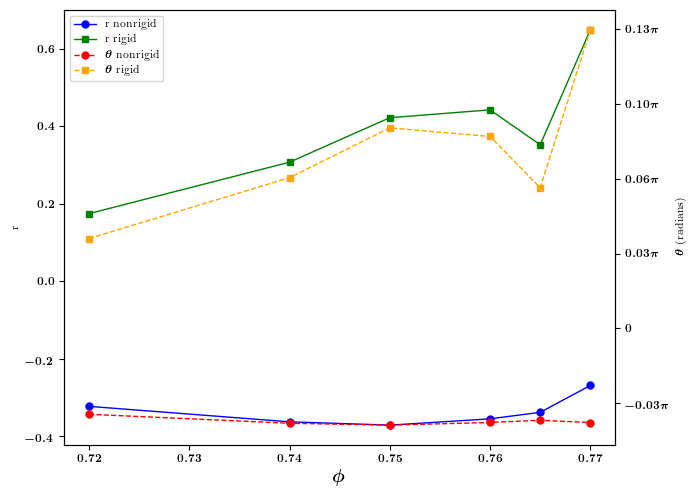

In [4]:
# Convert slope to angle in radians
phi  = [0.72, 0.74, 0.75, 0.76, 0.765, 0.77]

angle_nonrig = np.arctan(slope_nonrig)
angle_rig    = np.arctan(slope_rig)

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(7, 5))

# --- Plot r values on left y-axis
ax1.plot(phi, r_nonrig, 'o-', label='r nonrigid', color='blue')
ax1.plot(phi, r_rig, 's-', label='r rigid', color='green')
ax1.set_ylabel('r', color='black')
ax1.set_xlabel(r'$\phi$', fontsize=13)
ax1.tick_params(axis='y', labelcolor='black')

# --- Twin axis for angle (from slope) on the right
ax2 = ax1.twinx()
ax2.plot(phi, angle_nonrig, 'o--', label=r'$\theta$ nonrigid', color='red')
ax2.plot(phi, angle_rig, 's--', label=r'$\theta$ rigid', color='orange')
ax2.set_ylabel(r'$\theta$ (radians)', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Format ticks in terms of π
from matplotlib.ticker import FuncFormatter

def pi_formatter(x, pos):
    frac = x / np.pi
    if np.isclose(frac, 0): return r"$0$"
    elif np.isclose(frac, 1): return r"$\pi$"
    elif np.isclose(frac, -1): return r"$-\pi$"
    elif np.isclose(frac, 0.5): return r"$\frac{\pi}{2}$"
    elif np.isclose(frac, -0.5): return r"$-\frac{\pi}{2}$"
    else: return r"${:.2f}\pi$".format(frac)

ax2.yaxis.set_major_formatter(FuncFormatter(pi_formatter))

# Optional: set angle axis limits
#ax2.set_ylim(0, np.pi/2)  # adjust as needed

# --- Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

#plt.title(r'$r$ and $\theta = \arctan(\mathrm{slope})$ vs $\phi$', fontsize=14)
plt.show()

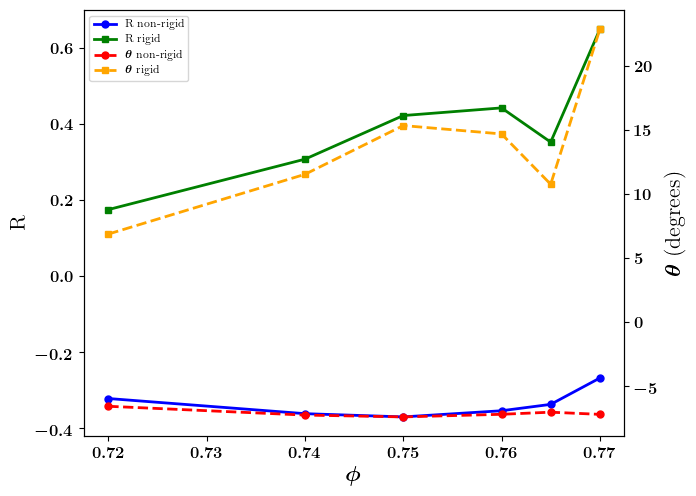

In [12]:

angle_nonrig = np.degrees(np.arctan(slope_nonrig))
angle_rig    = np.degrees(np.arctan(slope_rig))

# Create figure and axes
fig, ax1 = plt.subplots(figsize=(7, 5))

# --- Plot r values on left y-axis
ax1.plot(phi, r_nonrig, 'o-', label='R non-rigid', color='blue', linewidth=2)
ax1.plot(phi, r_rig, 's-', label='R rigid', color='green', linewidth=2)
ax1.set_ylabel('R', color='black', fontsize=16)
ax1.set_xlabel(r'$\phi$', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black', labelsize=12)
ax1.tick_params(axis='x', labelcolor='black', labelsize=12)

# --- Twin axis for angle (from slope) on the right
ax2 = ax1.twinx()
ax2.plot(phi, angle_nonrig, 'o--', label=r'$\theta$ non-rigid', color='red', linewidth=2)
ax2.plot(phi, angle_rig, 's--', label=r'$\theta$ rigid', color='orange', linewidth=2)
ax2.set_ylabel(r'$\theta$ (degrees)', color='black', fontsize=16)
ax2.tick_params(axis='y', labelcolor='black', labelsize=12)


# --- Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

#plt.title(r'$r$ and $\theta = \arctan(\mathrm{slope})$ vs $\phi$', fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
## checking for reading of rigPrime

frames:   0%|                                             | 0/1 [00:00<?, ?it/s]

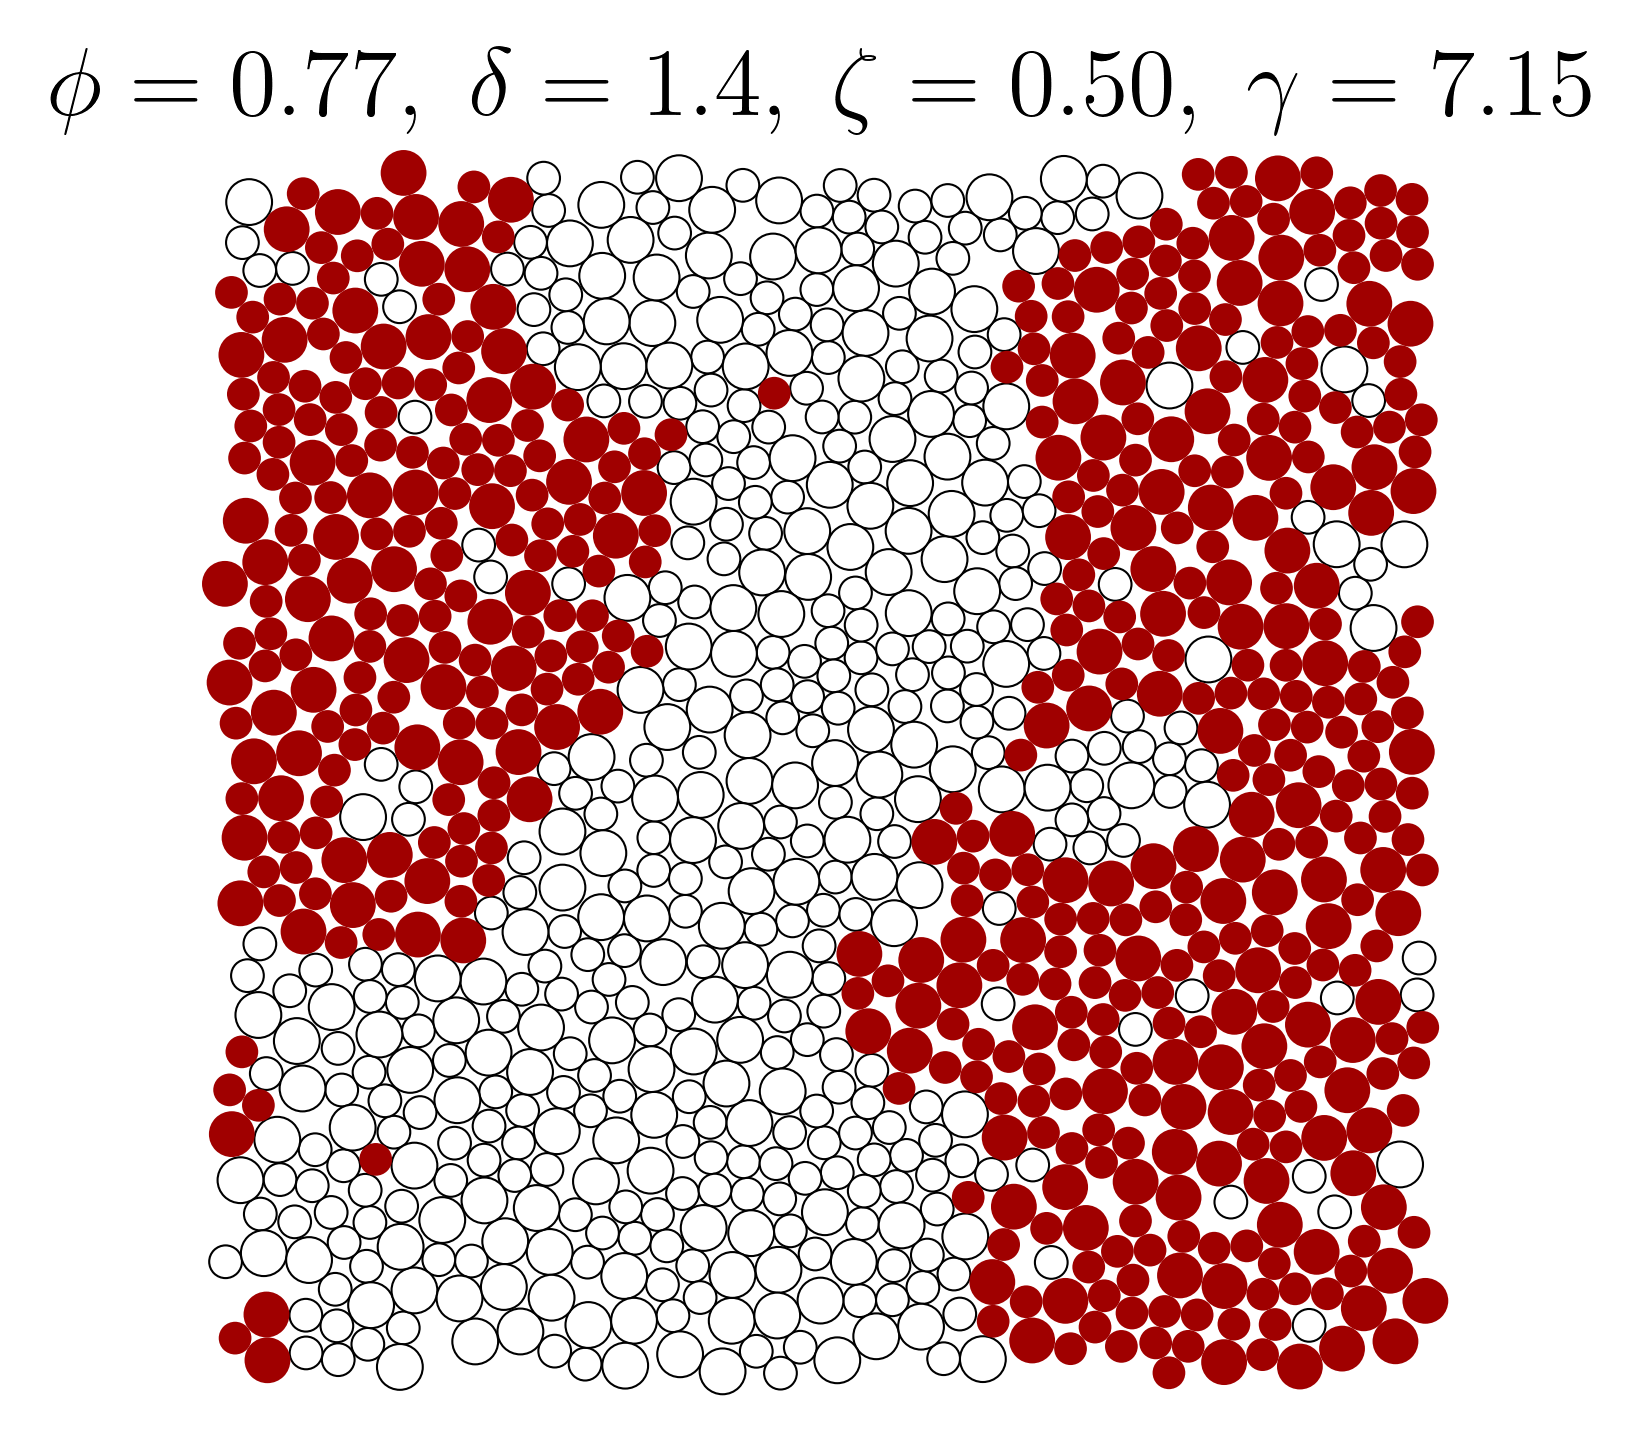

In [2]:
import os
import sys
import glob
import platform
from   tqdm              import tqdm # type: ignore
from   pathlib           import Path
import matplotlib                    # type: ignore
import numpy             as     np   # type: ignore
import matplotlib.pyplot as     plt  # type: ignore
import src.readFiles as readFiles    # type: ignore

'''
Feb 3, 2025
RVP

This script produces snapshots with rigid clusters for a given range of strain units.
Snapshots are produced for all the phi and ar values mentioned.
NOTE: snapshots produced for just one run (run = 1)

Command to execute in terminal:
python3 makeRigSnapshots.py
'''
system_platform = platform.system()

if system_platform == 'Darwin':  # macOS
    topDir = Path("/Volumes/rahul_2TB/rigid/mu_inf/")
    fig_save_path = Path("/Users/rahul/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/")
elif system_platform == 'Linux':
    topDir = Path("/media/rahul_2TB/rigid/mu_inf/")
    fig_save_path = Path("/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/research/bidisperse_project/figures/ang_vel/")
else:
    raise OSError(f"Unsupported OS: {system_platform}")

# Validate paths
for path in [topDir, fig_save_path]:
    if not path.exists():
        print(f"Error: Path '{path}' not found. Check mount point.")

# Simulation parameters.
npp    = 1000
phi    = [0.77] #, 0.71, 0.72, 0.73, 0.74, 0.75, 0.76]
ar     = [1.4]  #, 1.4, 1.8, 2.0, 4.0]
vr     = ['0.5']
numRum = 1

# Particles data file.
parFile = 'par_*.dat'
#rigFile = 'rig_*.dat'
rigFile = 'rigPrime.txt'

plt.rcParams.update({
    "figure.max_open_warning": 0,
    "text.usetex": True,
    "figure.autolayout": True,
    "font.family": "STIXGeneral",
    "mathtext.fontset": "stix",
    "font.size":        10,
    "xtick.labelsize":  10,
    "ytick.labelsize":  10,
    "patch.linewidth":  .2,
    "lines.markersize":  5,
    "hatch.linewidth":  .2
})
plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
#matplotlib.use('Agg')

# Frame details
# startFrame = 100
# endFrame   = 1650
#or
frames     = [715]

for j in range(len(phi)):
    phii = phi[j]
    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1]) > 2 else '{:.2f}'.format(phii)
    for k in range(len(ar)):
        for l in range(len(vr)):
            dataname = topDir / f"NP_{npp}/phi_{phii}/ar_{ar[k]}/Vr_{vr[l]}"
            if os.path.exists(dataname):
                particleFile  = open(glob.glob(f'{dataname}/run_{numRum}/{parFile}')[0])
                parLines      = particleFile.readlines()
                particlesList = readFiles.readParFile(particleFile)

                rigFilePath   = glob.glob(f'{dataname}/run_{numRum}/{rigFile}')
                if not rigFilePath:
                    print(f"Error: {rigFile} not found at {dataname}/run_{numRum}")
                    sys.exit(1)
                rigidFile     = open(rigFilePath[0])
                rigClusterIDs = readFiles.rigList(rigidFile)
                clusterIDs    = [[np.nan] if len(samplelist[0]) < 2 else list({int(num) for sublist in samplelist for num in sublist}) for samplelist in rigClusterIDs]

                # Box dimensions.
                Lx = float(parLines[3].split()[2]) 
                Lz = float(parLines[3].split()[2])

                directory = f'{fig_save_path}/phi_{phii}_ar_{ar[k]}_vr_{vr[l]}_rig'
                os.makedirs(directory, exist_ok=True)
                
                #for frame in tqdm(range(startFrame, endFrame), desc="Outer loop"):
                for frame in tqdm(frames, desc="frames", leave=False):
                    # Particle sizes and radii.
                    px = particlesList[frame][:,2]
                    pz = particlesList[frame][:,3]
                    pr = particlesList[frame][:,1]

                    # Setting up axis and box walls.
                    fig, ax = plt.subplots(1, 1, figsize=(3,3), dpi = 500)
                    newLx   = Lx + 2*np.max(pr)
                    newLz   = Lz + 2*np.max(pr)

                    allPart      = particlesList[frame][:,0]
                    rigidPart    = clusterIDs[frame]
                    notRigidPart = allPart[np.isin(allPart, rigidPart) == False]

                    ax.clear()
                    for index in notRigidPart:
                        index  = int(index)
                        circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='w', edgecolor='k', linewidth=0.3, zorder=1)
                        ax.add_artist(circle)
                    
                    for index in rigidPart:
                        circle = plt.Circle((px[index],pz[index]), pr[index], facecolor='#A00000', edgecolor=None, zorder=2)
                        ax.add_artist(circle)

                    ax.set_xlim([-(newLx/2+0.2),(newLx/2+0.2)])
                    ax.set_ylim([-(newLz/2+0.2),(newLz/2+0.2)])
                    ax.axis('off')
                    ax.set_aspect('equal')
                    ax.set_title(fr'$\phi = {phii}, \;\delta = {ar[k]}, \; \zeta = {float(vr[l]):.2f},\; \gamma = {frame/100:.2f}$', 
                                 fontsize=14, pad=4, fontweight='bold', x=0.5)

                    # Saving figure
                    #fig.savefig(f'{directory}/{frame}.png', dpi=400, bbox_inches='tight')
                    #print(f'>     Processed frame: {frame}/{endFrame-1}      ')
                    #plt.close(fig)
                    plt.show()
            else:
                print(f"{dataname} - Not Found")